# Data Preprocessing

In [1]:
# import the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
import scipy.stats as ss
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.feature_selection import mutual_info_classif
from scipy.stats import f_oneway
from sklearn.preprocessing import StandardScaler, MinMaxScaler

## Importing the Data

In [ ]:
df_train = pd.read_csv('train_data.csv')

The first step was to get a general idea of the data.

In [ ]:
df_train.head()

In [ ]:
df_train.describe()

"WCIO Part Of Body Code" has a value of -9, which could be a mistake.

In [ ]:
df_train_minus_9 = df_train[df_train['WCIO Part Of Body Code'] == -9]
df_train_minus_9['WCIO Part Of Body Description'].unique()

This could be a value that was the result of a wrong input, it could possibly be 9.

In [ ]:
df_train_9 = df_train[df_train['WCIO Part Of Body Code'] == 9]
df_train_9.head()

Although it is unlikely, the real value could actually be 90.

In [ ]:
df_train_90 = df_train[df_train['WCIO Part Of Body Code'] == 90]
df_train_90['WCIO Part Of Body Description'].unique()

No obvious connections can be found so this value will be kept, if necessary it can later be changed into a positive value.

The dataset regards the “New York Workers’ Compensation Board (WCB)”, an association that works in the state of New York, and covers work accidents (volunteer work included). In the state of New York, there is no maximum age for volunteer work, nor is there a minimum age requirement. Even though, the earliest opportunities for children that the group could find only start at 3 years of age (and they can only attend if they are accompanied by chaperone). With this information in mind, it is safe to assume that any observations under the age of 3 (and different from 0) are most likely errors, and therefore can be removed. As for the values above 100 years of age, although unlikely, these observations have no clear reason that would mean their removal, as so they will be kept. Values equal to 0 will be handled in the data cleaning phase.

References:<br>
https://www.volunteernewyork.org/youth-families<br>
https://workerscompensationexperts.org/law/state/new-york/<br>
https://www.thesilvermanfirm.com/workers-compensation-claims/workers-compensation-faqs/<br>
https://www.wcb.ny.gov/<br>

In [ ]:
df_train = df_train[(df_train['Age at Injury'] == 0) | (df_train['Age at Injury'] >= 3)]

The next step is looking at null/missing values, and trying to understand if these observations are missing at random or not.

In [ ]:
df_train.info()

It is possible to observe that in certain columns a majority of the values are null. Further research is necessary to understand the extent of the missing values.

In [ ]:
missing_values = df_train.isnull().sum().sort_values(ascending=False)                             
missing_percentage = (missing_values / len(df_train)) * 100                                           
missing_data = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})       
missing_data.style.applymap(lambda x: 'background-color: red' if x > 30 else '', subset=['Percentage'])

The variable "OIICS Nature of Injury Description" is completly empty, so it will be removed.

There are also a high percentage of NA values (more than 30%) in other variables. Imputing these columns would mean that most of the data had been created instead of collected, which could skew the data. The best course of action is to remove these columns. 

In [ ]:
df_train = df_train.drop(columns=['OIICS Nature of Injury Description', 'C-3 Date', 'First Hearing Date', 'IME-4 Count'])

It is also necessary to check for duplicate values.

In [ ]:
df_train[df_train.duplicated()]

There are no duplicates.

Some of the variables have the wrong data type, such as date variables saved as objects and integer values saved as floats. These issues will be fixed in order to obtain better visualizations. 

In [ ]:
int_list = ['Age at Injury', 'Industry Code', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code', 'WCIO Part Of Body Code', 'Agreement Reached', 'Number of Dependents']
for i in int_list:
    df_train[i] = pd.to_numeric(df_train[i], errors='coerce').astype('Int64')

In [ ]:
date_list = ['Accident Date', 'Assembly Date', 'C-2 Date']
for i in date_list:
    df_train[i] = pd.to_datetime(df_train[i], errors='coerce')

# Visualization

### Wide View of Numeric Variables

At this stage, some charts will be plotted. This is done because something as simple as creating histograms and boxplots for the numeric variables can reveal important insights to be further explored.

In [ ]:
metric_features = ['Age at Injury', 'Average Weekly Wage', 'Number of Dependents']
df = df_train

sns.set()
fig, axes = plt.subplots(1, 3, figsize=(25, 5))
for ax, feat in zip(axes.flatten(), metric_features):
    ax.hist(df[feat], color= '#B2D300')
    ax.set_title(feat, y=-0.13)
plt.suptitle("Numeric Variables' Histograms")
plt.show()

The age seems to be centralized around 50, as for the number of dependents it seems to be equally distributed along the various possibilities.

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(25, 5))
for ax, feat in zip(axes.flatten(), metric_features):
    sns.boxplot(x=df[feat], ax=ax, color= '#B2D300')
plt.suptitle("Numeric Variables Box Plots")
plt.show()

Average Weekly Wage seems to be skewed. On a later stage, more research will be conducted to understand this variable.

### Dates

Dates can yield important insights regarding periodicity in the data (for example, tourism tends to rise in summer and decline in winter).

A plot of the frequency of accidents per year and month for every year in the data set could show these tendencies.

In [ ]:
accidents_per_year = df_train['Accident Date'].dt.year.value_counts().sort_index()
plt.figure(figsize=(12, 6))
bars = plt.bar(accidents_per_year.index, accidents_per_year.values, color='#B2D300')
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Accidents per Year')
plt.grid(True)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.show()

In [ ]:
df_train_2019 = df_train[df_train['Accident Date'].dt.to_period('M') >= '2019-01']
accidents_by_month = df_train_2019.groupby(df_train_2019['Accident Date'].dt.to_period('M')).size()

plt.figure(figsize=(16, 7))
plt.plot(accidents_by_month.index.astype(str), accidents_by_month.values, marker='o', color='#B2D300', linestyle='-', linewidth=2)
plt.title('Number of Accidents by Month (2019-2023)')
plt.xlabel('Month')
plt.ylabel('Number of Accidents')

# set x-axis labels to show only the month and year
labels = []
for month in accidents_by_month.index.to_timestamp():
    if month.month == 1:                          # If its january, show year
        labels.append(f"{month.strftime('%Y')}")
    else:                                         # else, show only the month
        labels.append(month.strftime('%b'))

plt.xticks(ticks=range(0, len(accidents_by_month), 2), labels=labels[::2], rotation=45)


# Add grid and remove plot spines
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

In [ ]:
year_counts = df_train['Accident Date'].groupby(df_train['Accident Date'].dt.month).count()
plt.figure(figsize=(12, 6))
bars = plt.bar(year_counts.index, year_counts, color='#B2D300')
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Accidents per Month (for every year in the dataset)')
plt.yticks(fontsize=12)
plt.xticks(ticks=year_counts.index, labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=12)
plt.grid(True)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.show()

There seems to be a slight decrease in April and May, but most of the data regards the years of 2020, 2021 and 2022, so a plot for these years could be more revealing.

In [ ]:
df_train_recent = df_train[df_train['Accident Date'].dt.year.isin([2020, 2021, 2022])]

In [ ]:
year_counts = df_train_recent['Accident Date'].groupby(df_train_recent['Accident Date'].dt.month).count()
plt.figure(figsize=(12, 6))
bars = plt.bar(year_counts.index, year_counts, color='#B2D300')
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Accidents per Month (2020-2022)')
plt.yticks(fontsize=12)
plt.xticks(ticks=year_counts.index, labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=12)
plt.grid(True)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.show()

Only Decemeber seems to have changed in the recent years, showing a small decrease. To be more specific, a line chart with the three last years can be created.

In [ ]:
plt.figure(figsize=(12, 8))
years_list = [2020, 2021, 2022, 2023]
colors = ['#B2D300', '#66B2FF', '#FF6666']

for year, color in zip(years_list, colors):
    year_counts = df_train[df_train['Accident Date'].dt.year == year]['Accident Date'].dt.month.value_counts().sort_index()
    plt.plot(year_counts.index, year_counts.values, marker='o', label=str(year), color=color)
    
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Accidents per Month (2020-2022)')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.legend(title='Year')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.show()

There appears to be no recognizable pattern in these years. However, the group observed a decrease in accidents during the period from March to May. This could possibly be attributed to the COVID-19 outbreak, as workers were required to quarantine during this time and, consequently, were less likely to experience work-related accidents.

A look into the years before 2020, the minority subset, could explain the decrease in december in the more recent past.

In [ ]:
df_train_older = df_train[df_train['Accident Date'].dt.year < 2020]

In [ ]:
df_train_older

In [ ]:
year_counts = df_train_older['Accident Date'].groupby(df_train_older['Accident Date'].dt.month).count()
plt.figure(figsize=(12, 6))
bars = plt.bar(year_counts.index, year_counts, color='#B2D300')
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Accidents per Month (before 2020)')
plt.yticks(fontsize=12)
plt.xticks(ticks=year_counts.index, labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=12)
plt.grid(True)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.show()

In [ ]:
most_common_year_month = df_train_older['Accident Date'].dt.to_period('M').value_counts().idxmax()
most_common_year_month

The explosive rise in the month of december can be explained by the the date '2019-12-XX' which is the closest date to when the colection of data starts to grow. It's plausible to assume that this increase in observations is simply due to an increase in data collection and not a real life increase in insurance claims.

### Claim Types

This section will begin by exploring what are the unique values of the target variable

In [ ]:
df_train['Claim Injury Type'].unique()

This is how the target variable works:

Cancelled – The claim is canceled if it was assembled by mistake or identified as a duplicate of an existing claim.

Non-Comp – No indemnity (financial) benefits are awarded for the claim, meaning the worker is not compensated beyond the claim itself.

Med Only – Only medical benefits are awarded, covering treatment and healthcare costs without additional financial compensation for lost time.

Temporary – The claim provides temporary total or partial disability benefits for the period the worker is unable to work due to injury.

PPD Sch Loss – The claim awards a Permanent Partial Disability benefit for a scheduled body part (e.g., hand, leg) where there’s a specific schedule of compensation.

PPD NSL – The claim awards a Permanent Partial Disability benefit for a non-scheduled body part, such as the neck or back, without a specific compensation schedule.

PTD – Permanent Total Disability benefits are awarded, providing lifetime compensation because the worker is unable to return to work due to the injury.

Death – Death benefits are awarded under WCL §16 due to a worker’s death, providing financial support to dependents.<br>




References:<br>
https://data.ny.gov/Government-Finance/Assembled-Workers-Compensation-Claims-Beginning-20/jshw-gkgu/about_data

How are these values distributed?

In [ ]:
claim_injury_counts = df_train['Claim Injury Type'].value_counts()
claim_injury_counts = claim_injury_counts.reindex(sorted(claim_injury_counts.index, key=lambda x: int(x.split('.')[0])))

plt.figure(figsize=(14, 8))
bars = plt.bar(claim_injury_counts.index, claim_injury_counts.values, color='#B2D300')
plt.xlabel('Claim Injury Type')
plt.ylabel('Count')
plt.title('Distribution of Claim Injury Type')
plt.yticks(fontsize=12)
plt.grid(True)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.show()

The dataset is dominated by the second category in such a way that the 7th and 8th categories appear to be empty.

In [ ]:
claim_injury_table = df_train['Claim Injury Type'].value_counts().reset_index()
claim_injury_table.columns = ['Claim Injury Type', 'Count']

claim_injury_table['Claim Injury Type'] = claim_injury_table['Claim Injury Type'].astype(str)
claim_injury_table = claim_injury_table.sort_values(by='Claim Injury Type', key=lambda inj_type: inj_type.str.split('.').str[0].astype(int))
claim_injury_table.reset_index(drop=True, inplace=True)
claim_injury_table

The table allows a different view where the minority can still be seen. The target variable is clearly unbalanced. In the future, resampling and other methods could be used to compensate for this issue.

### Attorney VS No Attorney

In the real world, the presence of a lawyer can sometimes change the outcome of an insurance claim. How is this presence distributed across different types of claims?

In [ ]:
claim_injury_by_attorney = pd.crosstab(df_train['Claim Injury Type'], df_train['Attorney/Representative'])
claim_injury_by_attorney.columns = ['No Attorney', 'Attorney']
claim_injury_by_attorney.reset_index(inplace=True)
claim_injury_by_attorney['Attorney'] = claim_injury_by_attorney['Attorney'] / (claim_injury_by_attorney['No Attorney'] + claim_injury_by_attorney['Attorney']) * 100
claim_injury_by_attorney['No Attorney'] = 100 - claim_injury_by_attorney['Attorney']
claim_injury_by_attorney
claim_injury_by_attorney.plot(kind='bar', stacked=False, color=['Grey', '#B2D300'], figsize=(14, 6))
plt.xlabel('Type of Injury')
plt.ylabel('Percentage')
plt.title('Percentage of Cases with and whitout Attorney by Type of Injury')
plt.xticks(rotation=0)
plt.grid(True)
ax = plt.gca()
plt.xticks(ticks=range(len(claim_injury_counts.index)), 
               labels=sorted(claim_injury_counts.index, key=lambda x: int(x.split('.')[0])), 
               rotation=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.show()


This graph shows that as the severity of cases increases so does the percentage of cases where a laywer is present. It also indicates that the presence of a laywer is highly correlated to the target variable.

### Ages

In [ ]:
plt.figure(figsize=(15, 7))                              
sns.histplot(df_train['Age at Injury'], color='#B2D300')   
plt.xlabel('Age at Injury')                                
plt.ylabel('Frequency')                              
plt.title('Distribution of Age at Injury')
plt.grid(True)                                          
ax = plt.gca()                                                
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.show()

In [ ]:
pyramid_db = df_train.copy()

In [ ]:
bins = (0, 10, 20, 30, 40, 50, 60, 80, 90, 100, float('inf'))
labels = ['1-10', '10-19', '20-29', '30-39', '40-49', '50-59', '60-79', '80-89', '90-99', '100+']
pyramid_db['age_group'] = pd.cut(pyramid_db['Age at Injury'], bins=bins, labels=labels)

In [ ]:
# pyramid_data = piramid_db.groupby(['age_group', 'Gender']).size().unstack(fill_value=0)

# # Ensure age groups are in proper order
# pyramid_data = pyramid_data.reindex(sorted(pyramid_data.index))

# # Convert males to negative for plotting on the left
# pyramid_data['Male'] *= -1

# # Plotting
# fig, ax = plt.subplots(figsize=(10, 6))

# age_groups = pyramid_data.index
# ax.barh(age_groups, pyramid_data['Male'], color='blue', label='Male')
# ax.barh(age_groups, pyramid_data['Female'], color='pink', label='Female')

# # Formatting
# ax.set_xlabel('Population')
# ax.set_ylabel('Age Group')
# ax.set_title('Population Pyramid')
# ax.legend()

# # Show grid and improve appearance
# ax.grid(axis='x', linestyle='--', alpha=0.7)
# plt.tight_layout()
# plt.show()

Ages will be grouped in order to obtain visualizations that are more meaningful and easier to read. Age groups were created following the norms of the United States Census Bureau.

References:<br>
https://www2.census.gov/library/publications/decennial/2020/census-briefs/c2020br-06.pdf

In [ ]:
bins = (1, 18, 25, 45, 65, float('inf'))
labels = ['1-17', '18-24', '25-44', '45-64', '65+']
df_train['age_group'] = pd.cut(df_train['Age at Injury'], bins=bins, labels=labels)

In [ ]:
age_group_counts = df_train['age_group'].value_counts().sort_index()
age_group_counts_percentage = age_group_counts / age_group_counts.sum() * 100
age_group_table = pd.DataFrame({'Age Group': age_group_counts.index,'Count': age_group_counts.values,'Percentage': age_group_counts_percentage.values})
age_group_table

In [ ]:
df_train.groupby('Claim Injury Type')['age_group'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True, figsize=(15, 7))

In [ ]:
df_zeros = df_train[df_train['Age at Injury'] == 0]
df_zeros.describe()

Most observations with 0 years of age do not have an "average weekly wage", and a sizable amount have 0 as their birth year.

For the ones who have a birth year, it is possible to calculate their age at the time of the accident (this is something to be done in the data cleaning section).

In [ ]:
claim_injury_types = df_train['Claim Injury Type'].unique()
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 15))

for ax, claim_injury_type in zip(axes.flatten(), claim_injury_types):
    age_group_counts = df_train[df_train['Claim Injury Type'] == claim_injury_type]['age_group'].value_counts().sort_index()
    bars = ax.bar(age_group_counts.index, age_group_counts.values, color='#B2D300')
    ax.set_xlabel('Age Group')
    ax.set_ylabel('Count')
    ax.set_title(f'Age Group Distribution in Claim Injury Type {claim_injury_type}')
    ax.set_xticks(range(len(age_group_counts.index)))
    ax.set_xticklabels(age_group_counts.index, rotation=45)
    ax.grid(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

plt.tight_layout()
plt.show()

In [ ]:
df_train['Agreement Reached'] = df_train['Agreement Reached'].map({0: 'Not Reached', 1: 'Reached'})
mean_age_by_agreement = df_train.groupby('Agreement Reached')['Age at Injury'].mean().reset_index()
mean_age_by_agreement.columns = ['Agreement Reached', 'Mean Age']
mean_age_by_agreement

### Genders

The next step is checking how the dataset is distributed in terms of gender.

The reported gender of the injured worker can be: 
- F – Female; 
- M - Male; 
- X - Nonbinary; 
- U – Unknown (gender not specified)

References:

https://data.ny.gov/Government-Finance/Assembled-Workers-Compensation-Claims-Beginning-20/jshw-gkgu/about_data

In [ ]:
df_train['Gender'] = df_train['Gender'].astype(str)
gender_counts = df_train['Gender'].value_counts()
plt.bar(gender_counts.index, gender_counts.values, color='#B2D300')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Gender Distribution')
plt.grid(True)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.show()

In [ ]:
gender_type_of_claim = pd.crosstab(df_train['Gender'], df_train['Claim Injury Type'])
for i in gender_type_of_claim.columns:
    gender_type_of_claim[i] = (gender_type_of_claim[i] / gender_type_of_claim[i].sum()) * 100
gender_type_of_claim

The majority of the dataset is composed of men (M), with a smaller proportion of women (F) and two other options (Unknown and Nonbinary).

In [ ]:
gender_proportion = pd.crosstab(df_train['Claim Injury Type'], df_train['Gender'], normalize='index') * 100
colors = ['#B2D300', '#4A7200', '#8FB200', '#6C9200',]
fig, ax = plt.subplots(figsize=(10, 5))
gender_proportion.plot(kind='bar', stacked=True, color=colors, ax=ax)
plt.xlabel('Claim Injury Type')
plt.ylabel('Proportion')
plt.title('Proportion of Genders by Claim Injury Type')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.show()

The graph gives a better perception of the growth in the percentage of men as cases get increasingly severe, with the highest percentage of men present in cases envolving death.

The `Gender` variable has two minority categories, "U" and "X", this could prove to be troublesome. As such it will be adressed in the data cleaning phase.

### Unbalanced Columns

Two columns seem to be unbalanced.

In [ ]:
covid_count = df_train['COVID-19 Indicator'].value_counts()
covid_count_percent = covid_count / covid_count.sum() * 100
print(covid_count_percent)

In [ ]:
decision_count = df_train['WCB Decision'].value_counts()
decision_count_percent = decision_count / decision_count.sum() * 100
print(decision_count_percent)

In [ ]:
dispute_count = df_train['Alternative Dispute Resolution'].value_counts()
dispute_count_percent = dispute_count / dispute_count.sum() * 100
print(dispute_count_percent)

The "COVID-19 Indicator" is composed by (roughly) 95% of cases where the claimant did **not** have covid and 5% where the claimant **had** covid. This variable is highly unbalanced, which could mean its prediction power is very low. Further research is necessary to understand its utility.

In [ ]:
claim_injury_covid = pd.crosstab(df_train['Claim Injury Type'], df_train['COVID-19 Indicator'])
claim_injury_covid.columns = ['No', 'Yes']
claim_injury_covid.reset_index(inplace=True)
claim_injury_covid['Yes'] = claim_injury_covid['Yes'] / (claim_injury_covid['No'] + claim_injury_covid['Yes']) * 100
claim_injury_covid['No'] = 100 - claim_injury_covid['Yes']
claim_injury_covid
claim_injury_covid.plot(kind='bar', stacked=False, color=['Grey', '#B2D300'], figsize=(12, 6))
plt.xlabel('Type of Injury')
plt.ylabel('Percentage')
plt.title('Percentage of Cases with and whitout Covid by Type of Injury')
for index, value in enumerate(claim_injury_covid['Yes']):
    plt.text(index, value + 1, f'{value:.1f}%', ha='left', fontsize=10)
for index, value in enumerate(claim_injury_covid['No']):
    plt.text(index, value + 1, f'{value:.1f}%', ha='right', fontsize=10)
plt.xticks(ticks=claim_injury_covid.index, labels=claim_injury_covid['Claim Injury Type'], rotation=45)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.show()

It can be observed that the cases where the injury type is "DEATH" have a much higher rate of covid. There could possibly be a correlation between these variables, so at this time the Covid variable will be kept.

"WCB Decision" is composed in its entirety by "Not Work Related" cases. As such it has no variability, meaning it is not a feature of interest and, for this reason, it will be removed.
Alternative Dispute Resolution consists of three unique values, but two of them account for less than 1% of instances. Therefore, they were removed.

In [ ]:
df_train = df_train.drop(columns=['WCB Decision', 'Alternative Dispute Resolution'])

### Accident Location

In [ ]:
district_counts = df_train['District Name'].value_counts()
plt.barh(district_counts.index, district_counts.values, color='#B2D300')
plt.xlabel('')
plt.ylabel('')
plt.title('')
plt.grid(True)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.gca().invert_yaxis()
plt.show()

Most cases happen in the region of NYC (New York City, which accounts for 5 counties). This could be due to its higher population count.

References:

https://worldpopulationreview.com/us-counties/new-york

How does the target variable behave in these communities?

In [ ]:
from math import ceil

places = df_train['District Name'].unique()
num_places = len(places)
fig, axes = plt.subplots(nrows=ceil(num_places / 3), ncols=3, figsize=(20, 15))

for ax, place in zip(axes.flatten(), places):
    claim_injury_counts = df_train[df_train['District Name'] == place]['Claim Injury Type'].value_counts()
    bars = ax.bar(claim_injury_counts.index, claim_injury_counts.values, color='#B2D300')
    ax.set_xlabel('Claim Injury Type')
    ax.set_ylabel('Count')
    ax.set_title(f'Distribution of Claim Injury Type in {place}')
    ax.set_xticks(range(len(claim_injury_counts.index)))
    ax.set_xticklabels(claim_injury_counts.index, rotation=45)
    ax.grid(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

# Remove any empty subplots
for ax in axes.flatten()[num_places:]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()

The distribution of cases seems to be mostly equal for all locations, except one. In Statewide the group observed that the most frequent claim injury type was the "4. Temporary".

### Average Weekly Wage

In [ ]:
average_salary_by_claim = df_train.groupby('Claim Injury Type')['Average Weekly Wage'].mean()           # Group by 'Claim Injury Type' and calculate the mean of 'Average Weekly Wage'

plt.figure(figsize=(12, 6))
sns.barplot(x=average_salary_by_claim.index, y=average_salary_by_claim.values, color='#B2D300')
plt.xlabel('Claim Injury Type')
plt.ylabel('Average Weekly Wage')
plt.title('Average Weekly Wage by Claim Injury Type')
plt.grid(True)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.show()

The average weekly wage represents "the wage used to calculate workers’ compensation benefits, disability benefits, or an employee’s Paid Family Leave wage replacement benefits". 

The bar chart shows that the categories with the lowest average weekly wage are the first three. This is reasonable given that these claims are the ones without monetary compensation. Still more can be explored in this variable.<br>

References:<br>
https://data.ny.gov/Government-Finance/Assembled-Workers-Compensation-Claims-Beginning-20/jshw-gkgu/about_data

In [ ]:
bins = (0, 1000, 2000, 3000, 4000, 5000, 10000, 20000, 30000, 40000, 50000, 100000, 200000, 300000, 400000, 500000, 1000000)
df_train['wage_groups'] = pd.cut(df_train['Average Weekly Wage'], bins=bins)

In [ ]:
wage_group_counts = df_train['wage_groups'].value_counts().sort_index()
wage_group_counts_percentage = wage_group_counts / wage_group_counts.sum() * 100
wage_group_table = pd.DataFrame({'Wage Group': wage_group_counts.index,'Count': wage_group_counts.values,'Percentage': wage_group_counts_percentage.values})
wage_group_table['Wage Group'] = ['0-1000', '1000-2000', '2000-3000', '3000-4000', '4000-5000', '5000-10000', '10000-20000', '20000-30000', '30000-40000',
                                 '40000-50000', '50000-100000', '100000-200000', '200000-300000', '300000-400000', '400000-500000', '500000-1000000']
wage_group_table

Roughly 96% of the data falls in the range of 0 to 3000 USD. Further research into this range could reveal some important insights.

In [ ]:
df_train1 = df_train[df_train['Average Weekly Wage'] < 3000]
bins = (0, 500, 1000, 1500, 2000, 2500, 3000)
df_train1['wage_groups'] = pd.cut(df_train1['Average Weekly Wage'], bins=bins)

In [ ]:
df_train1['Average Weekly Wage'].mean()

The average falls bellow what it should (it should be around 1000 according to the previous table), this could be due to a large majority of low values in the 0 to 500 USD range. 

In the begining of the notebook, it was pointed out that the boxplot was skewed, so the next step is to look for zeros.

In [ ]:
df_testing = df_train1[df_train1['Average Weekly Wage'] == 0]
percent = len(df_testing)/len(df_train)*100
print(f'The percentage of observations where the salary is 0 is: {percent:.2f}%')

In [ ]:
plt.boxplot(df_train1['Average Weekly Wage'], patch_artist=True,
            boxprops=dict(facecolor='#B2D300'))
plt.grid(True)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.show()

In the boxplot, the fact this variable is dominated by zeros becomes obvious.

Therefore, the previously created bins are not representative of the average weekly wage variable, and will be reworked.

The new organization will work as follows:

- No Benefit
- Low Benefit
- Medium Benefit
- High Benefit

This organization method better represents the data as it takes into account the 0 in the class 'No Benefit'.

To better pick the limits of each category the data will be plotted without outliers and zeros.

In [ ]:
df_non_zero_wage = df_train[df_train['Average Weekly Wage'] > 0]

Q1 = df_non_zero_wage['Average Weekly Wage'].quantile(0.25)
Q3 = df_non_zero_wage['Average Weekly Wage'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df_non_zero_wage_no_outliers = df_non_zero_wage[(df_non_zero_wage['Average Weekly Wage'] >= lower_bound) & (df_non_zero_wage['Average Weekly Wage'] <= upper_bound)]

plt.boxplot(df_non_zero_wage_no_outliers['Average Weekly Wage'], patch_artist=True,
            boxprops=dict(facecolor='#B2D300'))
plt.title('Box Plot of Average Weekly Wage (Without Zeros and Outliers)')
plt.ylabel('Average Weekly Wage')
plt.grid(True)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.show()

In [ ]:
# calculate the quantiles and IQR excluding claims with 0 wage
df_non_zero_wage = df_train[df_train['Average Weekly Wage'] > 0]

q1 = df_non_zero_wage['Average Weekly Wage'].quantile(0.25) # 25th percentile or first quartile
q3 = df_non_zero_wage['Average Weekly Wage'].quantile(0.75)  # 75th percentile or third quartile
iqr = q3 - q1
lower_bound = max(0,q1 - 1.5 * iqr)                          # the max function ensures the lower bound cannot be less than 0, as negative wages are not valid
upper_bound = q3 + 1.5 * iqr

Given the present boxplot, the following division was decided:<br>
- No Compensation: Value = 0
- Low Wage: Lower Bound < Value < First Quartile
- Medium Wage: First Quartile <= Value <= Third Quartile
- High Wage: Third Quartile < Value <= Upper Bound
- Very High Wage: Upper Bound < Value

In [ ]:
bins = [-1, 0, q1, q3, upper_bound, df_train['Average Weekly Wage'].max()]
labels = ['No Wage', 'Low Wage', 'Medium Wage', 'High Wage', 'Very High Wage']
df_train['wage_groups'] = pd.cut(df_train['Average Weekly Wage'], bins=bins, labels=labels)
df_train[['Average Weekly Wage', 'wage_groups']]

In [ ]:
wage_groups_by_claim = pd.crosstab(df_train['Claim Injury Type'], df_train['wage_groups'])
wage_groups_by_claim_percentage = wage_groups_by_claim.div(wage_groups_by_claim.sum(axis=1), axis=0) * 100

plt.figure(figsize=(14, 8))
for wage_group in wage_groups_by_claim_percentage.columns:
    plt.plot(wage_groups_by_claim_percentage.index, wage_groups_by_claim_percentage[wage_group], marker='o', label=wage_group)

plt.xlabel('Claim Injury Type')
plt.ylabel('Percentage')
plt.title('Percentage of each Wage Group by Claim Injury Type')
plt.legend(title='Wage Group')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

As expected, the first two categories are dominated by "No Wage" observations. As the wage category increases, the proportion of "No Wage" observations decreases, with the exception of the "Very High Wage" category, which has few observations.

In [ ]:
df_train['Average Weekly Wage'].value_counts()

### Medical Fee Region

In [ ]:
df_train['Medical Fee Region'].unique()

What is the meaning of these codes:

I - Region 1: Rural areas outside of Buffalo, Albany, Syracuse, Rochester, Utica & Binghamton<br>
II - Region 2: Buffalo, Albany, Syracuse, Rochester, Utica & Binghamton<br>
III - Region 3: Westchester, Rockland & most of Suffolk, Orange, & Putnam<br>
IV - Region 4: New York City, Nassau, and Western Suffolk<br>
UK - Unknown

Reference:

https://data.ny.gov/Government-Finance/Assembled-Workers-Compensation-Claims-Beginning-20/jshw-gkgu/about_data

In [ ]:
medical_fee_regions = df_train['Medical Fee Region'].unique()
claim_injury_types = df_train['Claim Injury Type'].unique()

fig, axes = plt.subplots(nrows=ceil(len(medical_fee_regions) / 2), ncols=2, figsize=(20, 15))
for ax, region in zip(axes.flatten(), medical_fee_regions):
    region_data = df_train[df_train['Medical Fee Region'] == region]
    claim_counts = region_data['Claim Injury Type'].value_counts().reindex(claim_injury_types, fill_value=0)
    ax.bar(claim_counts.index, claim_counts.values, color='#B2D300')
    ax.set_title(f'Medical Fee Region: {region}')
    ax.set_xlabel('Claim Injury Type')
    ax.set_ylabel('Count')
    ax.set_xticks(range(len(claim_counts.index)))
    ax.set_xticklabels(claim_counts.index, rotation=45)
    ax.grid(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
for ax in axes.flatten()[len(medical_fee_regions):]:
    fig.delaxes(ax)
plt.tight_layout()
plt.show()

The distribution remains the same in the first target variable.

In [ ]:
medfee_proportion = pd.crosstab(df_train['Medical Fee Region'], df_train['Agreement Reached'], normalize='index') * 100
colors = ['#B2D300', '#4A7200']
fig, ax = plt.subplots(figsize=(10, 5))
medfee_proportion.plot(kind='bar', stacked=True, color=colors, ax=ax)
plt.xlabel('Medical Fee Region')
plt.ylabel('Proportion')
plt.title('Proportion of Agreement Reached by Medical Fee Region')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.show()

As expected, the variable follows the same distribution and most of the cases are not agreed upon.

## C-2 Date

Relatively to the variable C-2 Date, the first thing to do is understand what this data represents. The group found the following information regarding the variable:

"Date of receipt of the Employer's Report of Work-Related Injury/Illness or equivalent (formerly Form C-2). Blank indicates no form received. For data sets published prior to the first quarter of 2022, the C-2 Date is the date of receipt of the “Employer’s Report of Work-Related Injury/Illness” for C-2. For data sets created in the first quarter of 2022 and forward, the C-2 Date is set to the earliest received date of equivalent injury/illness filings, including electronic data filed though the Board’s eClaims process."<br>

References:<br>
https://data.ny.gov/Government-Finance/Assembled-Workers-Compensation-Claims-Beginning-20/jshw-gkgu/about_data

Given that the data focuses mostly on the years of 2020 to 2022, the line chart for C-2 Forms will look into this period.

In [ ]:
df_filtered = df_train[df_train['Accident Date'].dt.year.isin([2020, 2021, 2022])]
monthly_counts = df_filtered.groupby([df_filtered['Accident Date'].dt.year, df_filtered['Accident Date'].dt.month]).size().unstack(level=0)
plt.figure(figsize=(12, 6))
for year in [2020, 2021, 2022]:
    plt.plot(monthly_counts.index, monthly_counts[year], marker='o', label=str(year))

plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Monthly Accident Counts for the Years 2020, 2021, and 2022')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Year')
plt.grid(True)
plt.show()

There appears to be no type of periodicity.

Now, the group will see if the time elapsed between the accident and the submission of the C-2 Form has an inpact on WCB's decision. For that, a helper variable will be created. Then it will be binned according to the following groupings:

- 1 week (7 days)
- 1 month (30 days)
- 3 Months (90 days)
- 6 months (180 days)
- 1 year (365 days)
- 365 x 10 (10 years)
- 365 x 60 (60 years, this group was created to encompass all observations)

In [ ]:
df_train['days_to_c2'] = (df_train['C-2 Date'] - df_train['Accident Date']).dt.days

In [ ]:
bins = (-1, 0, 7, 30, 90, 180, 365, 365*2, 365*10, 60*365)
labels = ['Same Day', '1 week', '1 month', '3 months', '6 months', '1 year', '2 years', '10 years', '10+ years']
df_train['days_to_c2_binned'] = pd.cut(df_train['days_to_c2'], bins=bins, labels=labels)

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 20))
claim_list = ['1. CANCELLED', '2. NON-COMP', '3. MED ONLY', '4. TEMPORARY', '5. PPD SCH LOSS', '6. PPD NSL', '7. PTD', '8. DEATH']

for ax, claim in zip(axes.flatten(), claim_list):
    days_accident_binned = df_train[df_train['Claim Injury Type'] == claim]['days_to_c2_binned'].value_counts().sort_index()
    bars = ax.bar(days_accident_binned.index.astype(str), days_accident_binned.values / days_accident_binned.values.sum() * 100, color='#B2D300')
    ax.set_title(f'{claim} - Days from Accident to filling the C-2 Form')
    ax.set_xlabel('Days')
    ax.set_ylabel('Percentage (%)')
    ax.set_ylim(0, 50)
    ax.grid(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
plt.tight_layout()
plt.show()

It seems that, in most cases, the form is filled out up to a month after the accident happens. This is true for all kinds of decisions. Cases involving death seem to be the exception. In these cases, there is a more uniform distribution. This could be that employees don't bother to fill out the form in such a hurry if a death occurred.

Given that C-2 is the date of a form filled out by the employee after the accident, "C-2 Date" cannot happen before "Accident Date". In order to ensure the data is consistent, it must be confirmed if such cases occured:

In [ ]:
c2_before_accident = df_train[df_train['days_to_c2'] < 0]
print(f"Number of times the C-2 report is filled before the accident happens: {c2_before_accident.shape[0]}")

These rows will be addressed in the data cleaning stage.

## Carrier Type

In [ ]:
df_train['Carrier Type'].unique()

This variable has the following unique values:

- 1A. PRIVATE
- 2A. SIF
- 3A. SELF PUBLIC
- 4A. SELF PRIVATE
- 5A. SPECIAL FUND - CONS. COMM. (SECT. 25-A)
- 5C. SPECIAL FUND - POI CARRIER WCB MENANDS
- 5D. SPECIAL FUND - UNKNOWN
- UNKNOWN

In the data dictionary provided by the WCB, the following description is given:

> Type of primary insurance provider responsible for providing workers’ compensation coverage to the injured worker’s employer (Private Carrier, State Insurance 1  Fund, Selfinsured, or Special Fund). (See FAQ for clarifications on carrier type)

From this, we can gather that the carrier types can be grouped into the following categories:

- Private Carrier
- State Insurance
- Self-Insured
- Special Fund

And in the case of the present data, another group has to be added to account for the rows where the `carrier type` is unknown.

The new carrier types will be structured as follows:

| Original Carrier Type | New Group |
|---|---|
| 1A. PRIVATE | Private Carrier |
| 2A. SIF | State Insurance |
| 3A. SELF PUBLIC | Self-Public |
| 4A. SELF PRIVATE | Self-Private |
| 5A. SPECIAL FUND - CONS. COMM. (SECT. 25-A) | Special Fund |
| 5C. SPECIAL FUND - POI CARRIER WCB MENANDS | Special Fund |
| 5D. SPECIAL FUND - UNKNOWN | Special Fund |
| UNKNOWN | Unknown |

Note that the 3rd group (Self-Insured) isn't kept, instead its subdivisions (SELF PRIVATE and SELF PUBLIC) are kept. This is due to the fact that both these categories have enough observations to represent their own group, and there are differences amongst them that would be lost if they were mixed. For example, the average weekly salary in SELF-PUBLIC is almost double that of SELF-PRIVATE.

Before grouping, the group decided to take a look at the distribution of each type to see how it was affected by the transformation.

In [ ]:
value_c = df_train['Carrier Type'].value_counts()
value_c_df = pd.DataFrame({'Carrier Type': value_c.index, 'Count': value_c.values})
value_c_df['Percentage'] = value_c_df['Count'] / len(df_train) * 100
value_c_df

In [ ]:
# Group by 'Carrier Type' and calculate the mean of 'Average Weekly Wage'
avg_weekly_wage_by_carrier_type = df_train.groupby('Carrier Type')['Average Weekly Wage'].mean()

# Plot the data
plt.figure(figsize=(15, 6))
sns.barplot(x=avg_weekly_wage_by_carrier_type.values, y=avg_weekly_wage_by_carrier_type.index, color='#4782B4')

In [ ]:
gender_proportion_carrier = pd.crosstab(df_train['Carrier Type'], df_train['Attorney/Representative'], normalize='index') * 100
fig, ax = plt.subplots(figsize=(10, 5))  # Increased figure size
gender_proportion_carrier.plot(kind='bar', stacked=True, ax=ax)
plt.xlabel('Carrier Type')
plt.ylabel('Proportion')
plt.title('Proportion of Genders by Carrier Type')

In [ ]:
gender_proportion_carrier = pd.crosstab(df_train['Carrier Type'], df_train['Gender'], normalize='index') * 100
fig, ax = plt.subplots(figsize=(10, 5))  # Increased figure size
gender_proportion_carrier.plot(kind='bar', stacked=True, ax=ax)
plt.xlabel('Carrier Type')
plt.ylabel('Proportion')
plt.title('Proportion of Genders by Carrier Type')

In [ ]:
df_train['Carrier Type'] = df_train['Carrier Type'].map({
    '1A. PRIVATE': 'PRIVATE',
    '2A. SIF': 'STATE INSURANCE',
    '3A. SELF PUBLIC': 'SELF-PUBLIC',
    '4A. SELF PRIVATE': 'SELF-PRIVATE',
    '5D. SPECIAL FUND - UNKNOWN': 'SPECIAL FUND',
    '5C. SPECIAL FUND - POI CARRIER WCB MENANDS': 'SPECIAL FUND',
    '5A. SPECIAL FUND - CONS. COMM. (SECT. 25-A)':'SPECIAL FUND',
    'UNKNOWN':'UNKNOWN'
    })

In [ ]:
value_c = df_train['Carrier Type'].value_counts()
value_c_df = pd.DataFrame({'Carrier Type': value_c.index, 'Count': value_c.values})
value_c_df['Percentage'] = value_c_df['Count'] / len(df_train) * 100
value_c_df

In [ ]:
# Group by 'Carrier Type' and calculate the mean of 'Average Weekly Wage'
avg_weekly_wage_by_carrier_type = df_train.groupby('Carrier Type')['Average Weekly Wage'].mean()

# Plot the data
plt.figure(figsize=(15, 6))
sns.barplot(x=avg_weekly_wage_by_carrier_type.values, y=avg_weekly_wage_by_carrier_type.index, color='#4782B4')

In [ ]:
gender_proportion_carrier = pd.crosstab(df_train['Carrier Type'], df_train['Attorney/Representative'], normalize='index') * 100
fig, ax = plt.subplots(figsize=(10, 5))  # Increased figure size
gender_proportion_carrier.plot(kind='bar', stacked=True, ax=ax)
plt.xlabel('Carrier Type')
plt.ylabel('Proportion')
plt.title('Proportion of Genders by Carrier Type')

In [ ]:
gender_proportion_carrier = pd.crosstab(df_train['Carrier Type'], df_train['Gender'], normalize='index') * 100
fig, ax = plt.subplots(figsize=(10, 5))  # Increased figure size
gender_proportion_carrier.plot(kind='bar', stacked=True, ax=ax)
plt.xlabel('Carrier Type')
plt.ylabel('Proportion')
plt.title('Proportion of Genders by Carrier Type')

## Code Variables

In the dataset, there are a lot of columns regarding codes (industry codes, injury codes, etc.). These codes have a high cardinality (there are between 50 to 70 unique values) and, as such, they are of no use to the model or visualization.

In [ ]:
unique_cause_codes = df_train[['WCIO Cause of Injury Code', 'WCIO Cause of Injury Description']].drop_duplicates()
unique_nature_codes = df_train[['WCIO Nature of Injury Code', 'WCIO Nature of Injury Description']].drop_duplicates()
unique_body_codes = df_train[['WCIO Part Of Body Code', 'WCIO Part Of Body Description']].drop_duplicates()

In [ ]:
unique_body_codes

### Body Groups

To reduce the dimensionality, the codes can be grouped into 5 groups:
- Head
- Torso
- Arms
- Legs
- Other (for unkown codes)

This has to be done manually.

In [ ]:
## change the descriptions of the given codes to more readable descriptions:
# 18 - SOFT TISSUE HEAD
# 25 - SOFT TISSUE NECK
# 22 - DISC NECK
# 43 - DISC TRUNK

# the body part code 18 has a description of 'SOFT TISSUE that need to be altered to 'SOFT TISSUE HEAD'
df_train.loc[df_train['WCIO Part Of Body Code'] == 18, 'WCIO Part Of Body Description'] = 'SOFT TISSUE HEAD'

# the body part code 25 has a description of 'SOFT TISSUE that need to be altered to 'SOFT TISSUE NECK'
df_train.loc[df_train['WCIO Part Of Body Code'] == 25, 'WCIO Part Of Body Description'] = 'SOFT TISSUE NECK'

# the body part code 22 has a description of 'DISC that need to be altered to 'DISC NECK'
df_train.loc[df_train['WCIO Part Of Body Code'] == 22, 'WCIO Part Of Body Description'] = 'DISC NECK'

# the body part code 43 has a description of 'DISC that need to be altered to 'DISC TRUNK'
df_train.loc[df_train['WCIO Part Of Body Code'] == 43, 'WCIO Part Of Body Description'] = 'DISC TRUNK'

In [ ]:
head = [
    "MULTIPLE HEAD INJURY", "EYE(S)", "MOUTH", "EAR(S)", "SKULL", "FACIAL BONES", 
    "TEETH", "NOSE", "BRAIN", "LARYNX", "TRACHEA", "MULTIPLE NECK INJURY", "SOFT TISSUE HEAD", "SOFT TISSUE NECK"
]

torso = [
    "TORSO", "SHOULDER(S)", "LUNGS", "BUTTOCKS", "LOWER BACK AREA", "ABDOMEN INCLUDING GROIN", 
    "HIP", "CHEST", "DISC NECK", "DISC TRUNK", "UPPER BACK AREA", "PELVIS", "HEART", "VERTEBRAE", 
    "LUMBAR & OR SACRAL VERTEBRAE (VERTEBRA", "SACRUM AND COCCYX", "SPINAL CORD", "MULTIPLE TRUNK", "SPINAL CORD", "INTERNAL ORGANS"
]

arm = [
    "ARMS", "FINGER(S)", "THUMB", "WRIST", "HAND", "UPPER ARM", "ELBOW", "WRIST (S) & HAND(S)", "MULTIPLE UPPER EXTREMITIES"
]

leg = [
    "LEGS", "ANKLE", "KNEE", "LOWER LEG", "UPPER LEG", "FOOT", "TOES", "GREAT TOE", 
    "MULTIPLE LOWER EXTREMITIES"
]

multiple_body_parts = [ 'ARTIFICIAL APPLIANCE', "INSUFFICIENT INFO TO PROPERLY IDENTIFY - UNCLASSIFIED",
                        'NO PHYSICAL INJURY', 'MULTIPLE BODY PARTS (INCLUDING BODY', 'BODY SYSTEMS AND MULTIPLE BODY SYSTEMS',
                         'WHOLE BODY', 'MULTIPLE']

In [ ]:
df_train['body_group'] = np.nan
df_train.loc[df_train['WCIO Part Of Body Description'].isin(head), 'body_group'] = 'Head'
df_train.loc[df_train['WCIO Part Of Body Description'].isin(torso), 'body_group'] = 'Torso'
df_train.loc[df_train['WCIO Part Of Body Description'].isin(arm), 'body_group'] = 'Arms'
df_train.loc[df_train['WCIO Part Of Body Description'].isin(leg), 'body_group'] = 'Legs'
df_train.loc[df_train['WCIO Part Of Body Description'].isin(multiple_body_parts), 'body_group'] = 'Multiple Body Parts'

In [ ]:
df_train['body_group'].value_counts()
plt.bar(df_train['body_group'].value_counts().index, df_train['body_group'].value_counts().values, color='#B2D300')

Most of our observations suffered injuries in the torso area.

In [ ]:
body_group_percentage = df_train.groupby(['Claim Injury Type', 'body_group']).size().unstack().apply(lambda x: x / x.sum() * 100, axis=1)
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(25, 20))
axes = axes.flatten()
for ax, claim_type in zip(axes, body_group_percentage.index):
    body_group_percentage.loc[claim_type].plot(kind='bar', ax=ax, color='#B2D300')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.set_title(claim_type)
    ax.set_xlabel('Body Group')
    ax.set_ylabel('Percentage')
    ax.grid(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
plt.tight_layout()
plt.show()

The 'Other' category grows as the cases get more severe, reaching its peak in the most severe cases. The 'Head' category also shows a slight increase in the 7th and 8th categories.

In [ ]:
unique_nature_codes

### Injury Nature

The same can be done for the diseases, grouping them will reduce their dimensionality. They are grouped as follows:
- External Physical Trauma (caused by direct impact, injury, or physical force)
- Chronic and Repetitive Stress Injuries (due to repetitive motion or long-term strain)
- Cumulative and Occupational Injuries (work-related conditions or cumulative injuries)
- Infectious Diseases (disease or infection-related injuries)
- Poisoning and Chemical Exposure (injuries related to toxic substances or reactions)
- Cardiovascular and Respiratory Conditions (heart, lung, and vascular system-related)
- Neurological and Sensory Conditions (affecting the nervous system, vision, or hearing)
- Mental Health and Stress-Related Conditions (psychological or emotional conditions)
- Other (Multiple injuries and special/rare conditions combined)

Again, this needs to be done manually and in the case of some injuries, research is necessary.

In [ ]:
physical_trauma = ["CONTUSION", "SPRAIN OR TEAR", "CONCUSSION", "PUNCTURE", "LACERATION", "BURN", 
                   "STRAIN OR TEAR", "FRACTURE", "FOREIGN BODY", "RUPTURE", "DISLOCATION", "CRUSHING", 
                   "SEVERANCE", "ELECTRIC SHOCK", "AMPUTATION"]

repetitive_stress_injuries = ["INFLAMMATION", "CARPAL TUNNEL SYNDROME", "HERNIA", "VDT - RELATED DISEASES"]

cumulative_occupational_injuries = ["ALL OTHER OCCUPATIONAL DISEASE INJURY, NOC", "ALL OTHER SPECIFIC INJURIES, NOC", "ALL OTHER CUMULATIVE INJURY, NOC", 
                                    "DUST DISEASE, NOC", "ASBESTOSIS", "SILICOSIS", "BLACK LUNG", "BYSSINOSIS", "DERMATITIS"]

infectious_diseases = ["INFECTION", "COVID-19", "CONTAGIOUS DISEASE", "HEPATITIS C", "AIDS"]

poisoning_chemical_exposure = ["POISONING - GENERAL (NOT OD OR CUMULATIVE", "POISONING - CHEMICAL, (OTHER THAN METALS)", "POISONING - METAL", 
                               "RADIATION", "ADVERSE REACTION TO A VACCINATION OR INOCULATION"]

cardiovascular_respiratory = ["ANGINA PECTORIS", "MYOCARDIAL INFARCTION", "RESPIRATORY DISORDERS", 
                              "VASCULAR", "ASPHYXIATION", "HEAT PROSTRATION"]

neurological_sensory = ["HEARING LOSS OR IMPAIRMENT", "LOSS OF HEARING", "VISION LOSS", "ENUCLEATION", "SYNCOPE"]

mental_health_stress = ["MENTAL STRESS", "MENTAL DISORDER"]

other_injury = ["MULTIPLE PHYSICAL INJURIES ONLY", "MULTIPLE INJURIES INCLUDING BOTH PHYSICAL AND PSYCHOLOGICAL", 
         "FREEZING", "RADIATION", "ADVERSE REACTION TO A VACCINATION OR INOCULATION", "CANCER", 'NO PHYSICAL INJURY']


In [ ]:
df_train['injury_type'] = np.nan
df_train.loc[df_train['WCIO Nature of Injury Description'].isin(physical_trauma), 'injury_type'] = 'Physical Trauma'
df_train.loc[df_train['WCIO Nature of Injury Description'].isin(repetitive_stress_injuries), 'injury_type'] = 'Repetitive Stress Injuries'
df_train.loc[df_train['WCIO Nature of Injury Description'].isin(cumulative_occupational_injuries), 'injury_type'] = 'Cumulative Occupational Injuries'
df_train.loc[df_train['WCIO Nature of Injury Description'].isin(infectious_diseases), 'injury_type'] = 'Infectious Diseases'
df_train.loc[df_train['WCIO Nature of Injury Description'].isin(poisoning_chemical_exposure), 'injury_type'] = 'Poisoning/Chemical Exposure'
df_train.loc[df_train['WCIO Nature of Injury Description'].isin(cardiovascular_respiratory), 'injury_type'] = 'Cardiovascular/Respiratory'
df_train.loc[df_train['WCIO Nature of Injury Description'].isin(neurological_sensory), 'injury_type'] = 'Neurological/Sensory'
df_train.loc[df_train['WCIO Nature of Injury Description'].isin(mental_health_stress), 'injury_type'] = 'Mental Health/Stress'
df_train.loc[df_train['WCIO Nature of Injury Description'].isin(other_injury), 'injury_type'] = 'Other'

In [ ]:
injury_group_percentage = df_train.groupby(['Claim Injury Type', 'injury_type']).size().unstack().apply(lambda x: x / x.sum() * 100, axis=1)
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(25, 20))
axes = axes.flatten()
for ax, claim_type in zip(axes, injury_group_percentage.index):
    injury_group_percentage.loc[claim_type].plot(kind='barh', ax=ax, color='#B2D300')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    ax.set_title(claim_type)
    ax.set_ylabel('Injury Type')
    ax.set_xlabel('Percentage')
    ax.grid(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
plt.tight_layout()
plt.show()

This graph, like some of the graphs showed before, changes the most in cases where death is involved. Other types of cases are not so easily separated by these codes, as the increaases and decreases are only minor.

In [ ]:
for i in unique_cause_codes['WCIO Cause of Injury Description']:
    print(i)

### Cause of Injury

The causes of accident can also be grouped:
- Slips, Trips, and Falls (related to losing balance or falling)
- Lifting, Carrying, and Handling (injuries related to lifting or handling objects)
- Struck by or Contact with Objects (injuries from being hit or coming into contact with objects)
- Vehicle and Machinery Accidents (related to collisions, crashes, or machine injuries)
- Chemical, Environmental, and Biological Hazards (exposure to harmful substances or environments)
- Manual Tools and Physical Operations (injuries caused by tools or physical operations)
- Repetitive Motion and Strain (injuries from repeated actions or excessive strain)
- Miscellaneous Causes (other causes that don’t fit into the above categories)

Note: 'NOC' means 'Not Otherwise Classified', this code is used for observations that do not fit into a specific classification/category. 'FALL, SLIP OR TRIP, NOC' means it is a fall, slip or trip that does not fit in the categories present in the list such as snow or stairs.

References:<br>
https://workinjuryrights.com/glossary/not-otherwise-classified-noc/

In [ ]:
slips_trips_falls = ["FROM LIQUID OR GREASE SPILLS", "FALL, SLIP OR TRIP, NOC", "ON SAME LEVEL", "FROM DIFFERENT LEVEL (ELEVATION)", 
                     "ON ICE OR SNOW", "INTO OPENINGS", "ON STAIRS", "FROM LADDER OR SCAFFOLDING", "SLIP, OR TRIP, DID NOT FALL", 
                     "JUMPING OR LEAPING"]

lifting_carrying_handling = ["OBJECT BEING LIFTED OR HANDLED", "LIFTING", "PUSHING OR PULLING", "HOLDING OR CARRYING", 
                             "OBJECT HANDLED", "OBJECT HANDLED BY OTHERS"]

struck_by_or_contact = ["STRUCK OR INJURED, NOC", "FALLING OR FLYING OBJECT", "STEAM OR HOT FLUIDS", 
                        "STATIONARY OBJECT", "ELECTRICAL CURRENT", "HOT OBJECTS OR SUBSTANCES", 
                        "CAUGHT IN, UNDER OR BETWEEN, NOC", "FIRE OR FLAME", "CONTACT WITH, NOC", 
                        "BROKEN GLASS", "STEPPING ON SHARP OBJECT", "GUNSHOT", "ANIMAL OR INSECT"]

vehicle_machinery_accidents = ["COLLISION OR SIDESWIPE WITH ANOTHER VEHICLE", "MOTOR VEHICLE, NOC", "MOTOR VEHICLE", "VEHICLE UPSET", "COLLISION WITH A FIXED OBJECT", 
                               "CRASH OF RAIL VEHICLE", "CRASH OF WATER VEHICLE", "CRASH OF AIRPLANE", "MOVING PARTS OF MACHINE", "MACHINE OR MACHINERY", "POWERED HAND TOOL, APPLIANCE", 
                               "USING TOOL OR MACHINERY", "MOVING PART OF MACHINE", "HAND TOOL OR MACHINE IN USE"]

chemical_environmental_biological = ["CHEMICALS", "DUST, GASES, FUMES OR VAPORS", "ABSORPTION, INGESTION OR INHALATION, NOC", 
                                     "MOLD", "CUMULATIVE, NOC", "TEMPERATURE EXTREMES", "COLD OBJECTS OR SUBSTANCES", "RADIATION", 
                                     "ABNORMAL AIR PRESSURE"]

manual_tools_operations = ["HAND TOOL, UTENSIL; NOT POWERED", "CUT, PUNCTURE, SCRAPE, NOC", "RUBBED OR ABRADED, NOC", 
                           "SANDING, SCRAPING, CLEANING OPERATION", "WELDING OPERATION", "STRIKING AGAINST OR STEPPING ON, NOC", 
                           "USING TOOL OR MACHINERY"]

repetitive_motion_strain = ["REPETITIVE MOTION", "REACHING", "TWISTING", "STRAIN OR INJURY BY, NOC"]

other_cause = ["OTHER - MISCELLANEOUS, NOC", "FELLOW WORKER, PATIENT OR OTHER PERSON", "FOREIGN MATTER (BODY) IN EYE(S)",
                "OTHER THAN PHYSICAL CAUSE OF INJURY", "PANDEMIC", "TERRORISM", "NATURAL DISASTERS", "EXPLOSION OR FLARE BACK", 
                "COLLAPSING MATERIALS (SLIDES OF EARTH)", "CONTINUAL NOISE", "WIELDING OR THROWING", "PERSON IN ACT OF A CRIME"]

In [ ]:
df_train['injury_cause'] = np.nan
df_train.loc[df_train['WCIO Cause of Injury Description'].isin(slips_trips_falls), 'injury_cause'] = 'Slips, Trips, and Falls'
df_train.loc[df_train['WCIO Cause of Injury Description'].isin(lifting_carrying_handling), 'injury_cause'] = 'Lifting, Carrying, and Handling'
df_train.loc[df_train['WCIO Cause of Injury Description'].isin(struck_by_or_contact), 'injury_cause'] = 'Struck by or Contact with Objects'
df_train.loc[df_train['WCIO Cause of Injury Description'].isin(vehicle_machinery_accidents), 'injury_cause'] = 'Vehicle and Machinery Accidents'
df_train.loc[df_train['WCIO Cause of Injury Description'].isin(chemical_environmental_biological), 'injury_cause'] = 'Chemical, Environmental, and Biological Hazards'
df_train.loc[df_train['WCIO Cause of Injury Description'].isin(manual_tools_operations), 'injury_cause'] = 'Manual Tools and Physical Operations'
df_train.loc[df_train['WCIO Cause of Injury Description'].isin(repetitive_motion_strain), 'injury_cause'] = 'Repetitive Motion and Strain'
df_train.loc[df_train['WCIO Cause of Injury Description'].isin(other_cause), 'injury_cause'] = 'Other'


In [ ]:
cause_group_percentage = df_train.groupby(['Claim Injury Type', 'injury_cause']).size().unstack().apply(lambda x: x / x.sum() * 100, axis=1)
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(25, 20))
axes = axes.flatten()
for ax, claim_type in zip(axes, cause_group_percentage.index):
    cause_group_percentage.loc[claim_type].plot(kind='barh', ax=ax, color='#B2D300')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    ax.set_title(claim_type)
    ax.set_ylabel('Injury Type')
    ax.set_xlabel('Percentage')
    ax.grid(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
plt.tight_layout()
plt.show()

Unlike in the other bar charts, the causes for the accidents seem to be a differenciating factor. As always, this could be due to the fact that as cases get more severe the number of cases dwindles and so a small amount of cases caused by "repetitive motion or strain" can account for a large portion of the cases in a category.

### Industry Codes

Industry codes can be categorized into five main groups:

- Natural Resources and Utilities
- Goods Production and Trade
- Services
- Education Health Public Services
- Leisure Hospitality

Like before, this selection is done manually.

In [ ]:
unique_industry_codes = df_train[['Industry Code', 'Industry Code Description']].drop_duplicates()

In [ ]:
unique_industry_codes

In [ ]:
natural_resources_utilities = ["AGRICULTURE, FORESTRY, FISHING AND HUNTING", "MINING", "UTILITIES"]

goods_production_and_trade = ["CONSTRUCTION", "MANUFACTURING", "WHOLESALE TRADE", "RETAIL TRADE"]

services = ["TRANSPORTATION AND WAREHOUSING", "INFORMATION", "FINANCE AND INSURANCE", "REAL ESTATE AND RENTAL AND LEASING", 
    "PROFESSIONAL, SCIENTIFIC, AND TECHNICAL SERVICES", "MANAGEMENT OF COMPANIES AND ENTERPRISES",
    "OTHER SERVICES (EXCEPT PUBLIC ADMINISTRATION)", "ADMINISTRATIVE AND SUPPORT AND WASTE MANAGEMENT AND REMEDIAT"]

education_health_public_services = ["EDUCATIONAL SERVICES", "HEALTH CARE AND SOCIAL ASSISTANCE", "PUBLIC ADMINISTRATION"]

leisure_hospitality = ["ARTS, ENTERTAINMENT, AND RECREATION", "ACCOMMODATION AND FOOD SERVICES"]

In [ ]:
df_train['industry_group'] = np.nan
df_train.loc[df_train['Industry Code Description'].isin(natural_resources_utilities), 'industry_group'] = 'Natural Resources and Utilities'
df_train.loc[df_train['Industry Code Description'].isin(goods_production_and_trade), 'industry_group'] = 'Goods Production and Trade'
df_train.loc[df_train['Industry Code Description'].isin(services), 'industry_group'] = 'Services'
df_train.loc[df_train['Industry Code Description'].isin(education_health_public_services), 'industry_group'] = 'Education Health and Public Services'
df_train.loc[df_train['Industry Code Description'].isin(leisure_hospitality), 'industry_group'] = 'Leisure Hospitality'

In [ ]:
df_train['industry_group'].value_counts()
plt.barh(df_train['industry_group'].value_counts().index, df_train['industry_group'].value_counts().values, color='#B2D300')
plt.show()

Most of the cases belong to the education, health and public services, with almost double the number of cases of the second most frequent industry group.

In [ ]:
industry_group_percentage = df_train.groupby(['Claim Injury Type', 'industry_group']).size().unstack().apply(lambda x: x / x.sum() * 100, axis=1)
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(25, 20))
axes = axes.flatten()
for ax, claim_type in zip(axes, industry_group_percentage.index):
    industry_group_percentage.loc[claim_type].plot(kind='bar', ax=ax, color='#B2D300')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.set_title(claim_type)
    ax.set_xlabel('Industry Group')
    ax.set_ylabel('Percentage')
    ax.grid(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
plt.tight_layout()
plt.show()

'Education Health and Public Services' takes the lead in every category except for one. For canceled cases the most represented industry is 'Goods Production and Trade' (by around 5%). The least represented industry is 'Natural Resources and Utilities'. This industry like other minority code groups ('head' in the body_groups, 'Infecteous Diseases' in the nature group), reaches its peak in the most severe accidents.

## Agreement Reached

For the open-ended segment of the project, the group has chosen to predict an additional variable: Agreement Reached.

This variable indicates whether an agreement was reached between the parties involved before the intervention of the Workers' Compensation Board.

Exploring the relationships between 'Agreement Reached' and other variables can uncover information about the conditions that favor agreements before Workers' Compensation Board intervention.

First, the distribution of the Agreement Reached will be examined to see how this variable behaves in this data set.

In [ ]:
agreement_reached_counts = df_train['Agreement Reached'].value_counts()
plt.figure(figsize=(8, 6)) 
plt.bar(agreement_reached_counts.index, agreement_reached_counts.values, color=['grey','#B2D300'])
plt.xticks(ticks=[0, 1], labels=['Not Reached', 'Reached'])
plt.xlabel('Agreement Reached')
plt.ylabel('Count')
plt.title('Distribution of Agreement Reached')
plt.grid(True)

for index, value in enumerate(agreement_reached_counts.values):
    plt.text(index, value + 0.5, str(value), ha='center', va='bottom')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

The variable is unbalanced. This is something to take into account as it poses a challenge for prediction.

Moving forward, for now, it is essential to analyze the relationships between "Agreement Reached" and other variables in the dataset to determine its relevance for prediction.

In [ ]:
df_train['Attorney/Representative'] = df_train['Attorney/Representative'].replace({'N': 'No', 'Y': 'Yes'})
agreement_by_attorney = pd.crosstab(df_train['Attorney/Representative'], df_train['Agreement Reached'])
agreement_by_attorney.columns = ['Not Reached', 'Reached']
agreement_by_attorney['Reached'] = (agreement_by_attorney['Reached'] / (agreement_by_attorney['Not Reached'] + agreement_by_attorney['Reached'])) * 100
agreement_by_attorney['Not Reached'] = 100 - agreement_by_attorney['Reached']
agreement_by_attorney.plot(kind='bar', stacked=False, color=['Grey', '#B2D300'], figsize=(12, 6))
plt.xlabel('Attorney/Representative')
plt.ylabel('Percentage')
plt.title('Percentage of Cases with and without Agreement by Attorney')
plt.xticks(rotation=0)
plt.grid(True)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.show()

From this graph, it is possible to understand that the presence of an attorney influences the likelihood of reaching an agreement. Even though there are way more cases where it was not reached, there is still a big increase in the number of cases in which it is possible to reach an agreement, when an attorney is present.

In [ ]:
agreement_by_wage = pd.crosstab(df_train1['wage_groups'], df_train['Agreement Reached'])
agreement_by_wage.columns = ['Not Reached', 'Reached']
agreement_by_wage['Reached'] = (agreement_by_wage['Reached'] / (agreement_by_wage['Not Reached'] + agreement_by_wage['Reached'])) * 100
agreement_by_wage['Not Reached'] = 100 - agreement_by_wage['Reached']
agreement_by_wage.plot(kind='bar', stacked=False, color=['Grey', '#B2D300'], figsize=(12, 6))
plt.xlabel('Wage Group')
plt.ylabel('Percentage')
plt.title('Percentage of Cases with and without Agreement by Wage Group')
plt.xticks(rotation=0)
plt.grid(True)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.show()

Cases in lower wage groups have a higher percentage of agreements reached compared to those in higher wage groups. Additionally, as the level of wage increase, the agreement not being reached also increases.

In [ ]:
df_train['COVID-19 Indicator'] = df_train['COVID-19 Indicator'].replace({'N': 'No', 'Y': 'Yes'})
agreement_by_covid = pd.crosstab(df_train['COVID-19 Indicator'], df_train['Agreement Reached'])
agreement_by_covid.columns = ['Not Reached', 'Reached']

agreement_by_covid['Reached'] = (agreement_by_covid['Reached'] / (agreement_by_covid['Not Reached'] + agreement_by_covid['Reached'])) * 100
agreement_by_covid['Not Reached'] = 100 - agreement_by_covid['Reached']

agreement_covid_table = agreement_by_covid[['Reached', 'Not Reached']].copy()
agreement_covid_table.index.name = 'COVID-19 Indicator'
agreement_covid_table.columns = ['Agreement Reached (%)', 'Agreement Not Reached (%)'] 
pd.DataFrame(agreement_covid_table)

The table indicates that when the claim is not related to COVID-19, the percentage of cases reaching an agreement is higher.

In [ ]:
df_train['Agreement Reached'] = df_train['Agreement Reached'].astype(object)
df_train['Agreement Reached'] = df_train['Agreement Reached'].replace({0: 'Not Reached', 1: 'Reached'})
agreement_by_body_group = df_train.groupby(['Agreement Reached', 'body_group']).size().unstack()

fig, ax = plt.subplots(figsize=(14, 8))
agreement_by_body_group.T.plot(kind='bar', ax=ax, color=['Grey','#B2D300'], rot=0)
ax.set_xlabel('Body Group')
ax.set_ylabel('Frequency')
ax.set_title('Frequency of Agreement Reached by Body Group')
ax.grid(True, axis='y', linestyle='--', linewidth=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.show()

The graph shows that the percentage of cases in which an agreement is reached varies significantly across different body parts. In particular, for arm and torso injuries, the percentage of cases in which an agreement is not reached is significantly higher than the percentage of cases in which an agreement is reached.

In [ ]:
agreement_by_injury_type_proportion = pd.crosstab(df_train['injury_type'], df_train['Agreement Reached'], normalize='index') * 100
colors = ['#B2D300', '#4A7200']
fig, ax = plt.subplots(figsize=(10, 5))
agreement_by_injury_type_proportion.plot(kind='barh', stacked=True, color=colors, ax=ax)
plt.xlabel('Percentage')
plt.ylabel('Injury Type')
plt.title('Proportion of Agreement Reached by Injury Type')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.show()

In both categories, "Physical Trauma" is the most common type of injury, accounting for the highest proportion. Other injuries, such as "Infectious Diseases" and "Cumulative Occupational Injuries" are present but with much smaller percentages. In general, the pattern of injury types is quite similar between the two groups.

In [ ]:
agreement_by_injury_cause_proportion = pd.crosstab(df_train['injury_cause'], df_train['Agreement Reached'], normalize='index') * 100
colors = ['#B2D300', '#4A7200']
fig, ax = plt.subplots(figsize=(10, 5))
agreement_by_injury_cause_proportion.plot(kind='barh', stacked=True, color=colors, ax=ax)
plt.xlabel('Percentage')
plt.ylabel('Cause of Injury')
plt.title('Proportion of Agreement Reached by Cause of Injury')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.show()

The chart indicates that injury causes such as "Slips, Trips, and Falls" and "Lifting, Carrying, and Handling" are consistently significant contributors to injuries in both "Reached" and "Not Reached" cases. This trend could reflect common challenges in resolving cases involving these types of injuries or their overall higher frequency. Less common causes like "Chemical, Environmental, and Biological Hazards" are rare across both groups, suggesting that they may be easier to resolve or simply occur less frequently.

## Zip Codes

For zip codes, they can be grouped them into 9 main groups:
- Syracuse
- Rochester
- Albany
- Hauppage
- NYC
- Buffalo
- Binghamton
- Stadewide
- Other

This has to be done manually, as it was done before with the other grouped variables.

References:<br>
https://www.unitedstateszipcodes.org/#zips-list

In [ ]:
# most frequent zip codes
zip_code_counts = df_train['Zip Code'].value_counts().head(50)
zip_code_counts

In [ ]:
# # Fill NaN values with an empty string
# df_train['Zip Code'] = df_train['Zip Code'].fillna('')

# # Convert all zip codes to string type
# df_train['Zip Code'] = df_train['Zip Code'].astype(str)

# # Unique zip codes
# unique_zip_codes = df_train['Zip Code'].unique()

# # Check if zip codes have letters and digits
# zip_codes_with_letters = [zip_code for zip_code in unique_zip_codes if any(char.isalpha() for char in zip_code)]

# # Check if zip codes have digits only
# zip_codes_with_digits = [zip_code for zip_code in unique_zip_codes if zip_code.isdigit()]
# # order by ascending order the list with the zip codes that contain digits
# zip_codes_with_digits.sort()

In [ ]:
unique_zip_codes = df_train[['Zip Code']].drop_duplicates()

In [ ]:
unique_zip_codes

In [ ]:
region_ny = {
"CENTRAL NEW YORK": ["OSWEGO", "ONONDAGA", "CAYUGA", "MADISON", "CORTLAND"], 
"SOUTHERN TIER": ["DELAWARE", "CHENANGO", "BROOME", "TIOGA", "TOMPKINS", "CHEMUNG", "SCHUYLER", "STEUBEN"],
"FINGER LAKES": ["WAYNE", "SENECA", "YATES", "MONROE", "LIVINGSTON", "ONTARIO", "ORLEANS", "GENESEE", "WYOMING"], 
"WESTERN NEW YORK": ["ERIE", "NIAGARA", "CHAUTAUQUA", "CATTARAUGUS", "ALLEGANY"], 
"NORTH COUNTRY": ["JEFFERSON", "LEWIS", "ST. LAWRENCE", "FRANKLIN", "CLINTON", "ESSEX", "HAMILTON"], 
"MOHAWK VALLEY": ["HERKIMER", "ONEIDA", "OTSEGO", "MONTGOMERY", "FULTON", "SCHOHAIRE"], 
"CAPITAL REGION": ["SCHENECTADY", "ALBANY", "RENSSELAER", "SARATOGA", "GREENE", "COLUMBIA", "WARREN", "WASHINGTON"], 
"HUDSON VALLEY": ["ROCKLAND", "ORANGE", "PUTNAM", "DUTCHESS", "ULSTER", "SULLIVAN", "WESTCHESTER"],
"NEW YORK CITY": ["BRONX", "KINGS", "NEW YORK", "QUEENS", "RICHMOND"], 
"LONG ISLAND": ["NASSAU", "SUFFOLK"]
}

In [ ]:
df_train['Zip Code'] = pd.to_numeric(df_train['Zip Code'], errors='coerce')

counties_ny = {'ALBANY':(12007, 12009, 12023, 12041, 12045, 12046, 12047, 12054, 12055, 12059, 12067, 12077, 12084, 12085, 12107, 12110, 12110, 12120, 12128, 
                12128, 12143, 12147, 12158, 12159, 12161, 12183, 12183, 12186, 12189, 12201, 12202, 12203, 12203, 12204, 12204, 12205, 12205, 12205, 
                12206, 12207, 12208, 12209, 12210, 12211, 12211, 12211, 12212, 12220, 12223, 12224, 12225, 12226, 12227, 12247, 12260, 12469), 
               
               'ALLEGANY':(14029, 14707, 14708, 14709, 14711, 14714, 14715, 14717, 14721, 14727, 14735, 14739, 14744, 14745, 14754, 14774, 14777, 14786, 14802,
                14803, 14804, 14806, 14813, 14822, 14880, 14884, 14895), 
               
               'BRONX':(10451, 10452, 10453, 10454, 10455, 10456, 10457, 10458, 10459, 10460, 10461, 10462, 10463, 10464, 10465, 10466, 10467, 10468, 10469,
                10470, 10471, 10472, 10473, 10474, 10475), 
               
               'BROOME':(13737, 13744, 13745, 13746, 13748, 13749, 13754, 13760, 13760, 13761, 13762, 13763, 13777, 13787, 13790, 13794, 13795, 13797, 13802,
                13813, 13826, 13826, 13833, 13833, 13848, 13850, 13851, 13901, 13902, 13903, 13904, 13905), 
               
               'CATTARAUGUS':(14041, 14042, 14060, 14065, 14065, 14070, 14101, 14129, 14133, 14138, 14168, 14706, 14719, 14726, 14729, 14730, 14731, 14737, 14741,
                14743, 14743, 14748, 14751, 14753, 14755, 14760, 14760, 14766, 14770, 14772, 14778, 14779, 14783), 
               
               'CAYUGA':(13021, 13021, 13022, 13026, 13033, 13034, 13064, 13071, 13081, 13111, 13113, 13117, 13118, 13139, 13140, 13147, 13147, 13156, 13160,
                13166),

               'CHAUTAUQUA':(14048, 14048, 14062, 14063, 14081, 14135, 14136, 14166, 14166, 14701, 14702, 14710, 14712, 14716, 14718, 14720, 14722, 14723, 14724,
                14728, 14732, 14733, 14736, 14738, 14740, 14742, 14747, 14750, 14752, 14756, 14757, 14758, 14767, 14767, 14769, 14775, 14781, 14782,
                14784, 14785),

               'CHEMUNG':(14814, 14816, 14825, 14838, 14844, 14845, 14861, 14864, 14871, 14872, 14889, 14894, 14901, 14902, 14903, 14903, 14903, 14903, 14904,
                14905, 14925),

               'CHENANGO':(13124, 13129, 13136, 13155, 13332, 13332, 13411, 13411, 13460, 13464, 13730, 13733, 13758, 13778, 13780, 13801, 13809, 13814, 13815,
                13830, 13830, 13832, 13841, 13843, 13844),

               'CLINTON':(12901, 12903, 12910, 12911, 12911, 12911, 12912, 12918, 12919, 12921, 12923, 12924, 12924, 12929, 12933, 12934, 12935, 12944, 12952,
                12955, 12955, 12958, 12959, 12962, 12972, 12978, 12979, 12981, 12985, 12992),

               'COLUMBIA':(12017, 12029, 12037, 12050, 12060, 12062, 12075, 12106, 12115, 12125, 12125, 12130, 12132, 12136, 12165, 12172, 12173, 12174, 12184,
                12195, 12502, 12503, 12513, 12516, 12517, 12521, 12523, 12526, 12529, 12530, 12534, 12541, 12544, 12565, 12593, 12593),

               'CORTLAND':(13040, 13040, 13045, 13056, 13077, 13087, 13101, 13141, 13158, 13738, 13784, 13803),

               'DELAWARE':(12167, 12406, 12421, 12430, 12430, 12434, 12438, 12455, 12459, 12474, 13731, 13739, 13740, 13750, 13751, 13752, 13753, 13753, 13755,
                13756, 13757, 13774, 13775, 13782, 13783, 13783, 13786, 13788, 13804, 13806, 13837, 13838, 13839, 13842, 13846, 13846, 13847, 13856,
                13860),

               'DUTCHESS':(12501, 12504, 12504, 12504, 12506, 12507, 12507, 12508, 12510, 12511, 12512, 12514, 12522, 12524, 12527, 12531, 12533, 12533, 12537,
                12538, 12540, 12545, 12546, 12564, 12567, 12569, 12570, 12571, 12571, 12572, 12574, 12578, 12580, 12581, 12582, 12583, 12585, 12590,
                12590, 12592, 12601, 12602, 12603, 12603),

               'ERIE':(14001, 14004, 14006, 14010, 14025, 14026, 14027, 14030, 14031, 14032, 14033, 14034, 14035, 14038, 14043, 14047, 14051, 14051, 14052,
                14055, 14057, 14059, 14061, 14068, 14069, 14072, 14075, 14080, 14085, 14086, 14091, 14102, 14110, 14111, 14112, 14127, 14134, 14139,
                14140, 14141, 14150, 14151, 14169, 14170, 14201, 14202, 14203, 14204, 14205, 14206, 14206, 14207, 14208, 14209, 14210, 14211, 14212,
                14212, 14213, 14214, 14215, 14216, 14217, 14217, 14217, 14217, 14218, 14218, 14219, 14219, 14220, 14221, 14221, 14222, 14223, 14223,
                14223, 14224, 14225, 14225, 14226, 14226, 14226, 14226,14227, 14227, 14227, 14228, 14228, 14231, 14240, 14280),

               'ESSEX':(12851, 12852, 12855, 12857, 12858, 12858, 12870, 12872, 12879, 12879, 12883, 12913,12928, 12932, 12936, 12941, 12942, 12943, 12943,
                12946, 12946, 12950, 12956, 12960, 12961, 12964, 12974, 12975, 12977, 12987, 12993),

               'FRANKLIN':(12914, 12915, 12916, 12917, 12920, 12926, 12930, 12937, 12939, 12945, 12945, 12953,
                12957, 12966, 12966, 12966, 12969, 12970, 12976, 12980, 12983, 12986, 12986, 12989,
                12989, 12989, 13655, 13655, 13655),

               'FULTON':(12025, 12032, 12078, 12095, 12117, 12134, 12134, 13470),

               'GENESEE':(14003, 14005, 14013, 14020, 14021, 14036, 14040, 14054, 14056, 14058, 14125, 14143, 14416, 14422, 14482, 14486, 14525, 14525, 14557),

               'GREENE':(12015, 12042, 12051, 12058, 12083, 12083, 12083, 12087, 12124, 12176, 12192, 12405, 12407, 12413, 12414, 12414, 12418, 12422, 12423,
                12424, 12424, 12427, 12431, 12436, 12439, 12439, 12442, 12444, 12450, 12451, 12452, 12454, 12460, 12463, 12468, 12470, 12473, 12482, 
                12485, 12492),

               'HAMILTON':(12108, 12139, 12164, 12190, 12812, 12842, 12847, 12864, 13353, 13360, 13436),

               'HERKIMER':(13324, 13329, 13331, 13340, 13340, 13350, 13357, 13361, 13365, 13406, 13407, 13416, 13420, 13431, 13454, 13472, 13475, 13491),

               'JEFFERSON':(13601, 13602, 13603, 13605, 13606, 13607, 13607, 13608, 13608, 13611, 13612, 13615, 13616, 13618, 13619, 13622, 13624, 13624, 13624,
                13624, 13628, 13632, 13634, 13636, 13637, 13638, 13640, 13640, 13641, 13643, 13650, 13651, 13656, 13657, 13659, 13661, 13665, 13671,
                13673, 13674, 13675, 13679, 13682, 13685, 13688, 13691, 13692, 13693),

               'KINGS':(11201, 11202, 11203, 11204, 11205, 11206, 11207, 11208, 11209, 11210, 11211, 11212, 11213, 11214, 11215, 11216, 11217, 11218, 11219,
                11220, 11221, 11222, 11223, 11224, 11225, 11226, 11228, 11229, 11230, 11231, 11232, 11233, 11234, 11235, 11236, 11237, 11238, 11239,
                11240, 11241, 11242, 11243, 11247, 11249, 11252, 11252, 11256),

               'LEWIS':(13305, 13305, 13312, 13312, 13325, 13327, 13343, 13345, 13367, 13367, 13368, 13404, 13433, 13473, 13489, 13620, 13626, 13626, 13627, 
                13631, 13648),

               'LIVINGSTON':(14414, 14423, 14435, 14437, 14454, 14462, 14466, 14480, 14481, 14485, 14487, 14488, 14510, 14510, 14517, 14533, 14533, 14539, 14545,
                14545, 14556, 14558, 14560, 14560, 14836, 14846),

               'MADISON':(13032, 13032, 13035, 13037, 13043, 13052, 13061, 13072, 13082, 13122, 13134, 13163, 13310, 13314, 13334, 13346, 13355, 13364, 13402,
                13408, 13409, 13409, 13418, 13421, 13465, 13484),

               'MONROE':(14410, 14420, 14428, 14428, 14430, 14445, 14450, 14464, 14467, 14468, 14472, 14506, 14511, 14514, 14515, 14526, 14534, 14543, 14543,
                14546, 14559, 14580, 14586, 14601, 14602, 14603, 14604, 14605, 14606, 14607, 14608, 14609, 14610, 14611, 14612, 14612, 14613, 14614,
                14615, 14615, 14616, 14616, 14617, 14617, 14618, 14618, 14619, 14620, 14621, 14622, 14622, 14623, 14624, 14625, 14625, 14626, 14626,
                14626, 14627, 14660, 14692),

               'MONTGOMERY':(12010, 12010, 12016, 12016, 12066, 12068, 12069, 12070, 12072, 12086, 12166, 12177, 13317, 13317, 13339, 13410, 13428, 13452),

               'NASSAU':(11001, 11002, 11003, 11003, 11003, 11003, 11010, 11020, 11021, 11022, 11023, 11024, 11024, 11026, 11027, 11030, 11030, 11040, 11042,
                11050, 11050, 11096, 11096, 11501, 11507, 11509, 11510, 11510, 11514, 11516, 11518, 11520, 11530, 11530, 11531, 11542, 11545, 11547,
                11548, 11550, 11550, 11551, 11552, 11553, 11554, 11557, 11558, 11559, 11560, 11561, 11561, 11561, 11563, 11565, 11566, 11566, 11568,
                11569, 11570, 11571, 11572, 11572, 11575, 11576, 11577, 11579, 11580, 11581, 11582, 11596, 11599, 11709, 11710, 11710, 11714, 11732,
                11735, 11735, 11753, 11756, 11758, 11758, 11762, 11765, 11771, 11783, 11791, 11793, 11801, 11802, 11803, 11803, 11804, 11804),

               'NEW YORK CITY':(10001, 10002, 10002, 10003, 10004, 10004, 10005, 10006, 10006, 10007, 10008, 10009, 10010, 10011, 10012, 10012, 10013, 10013, 10013,
                10014, 10015, 10016, 10017, 10018, 10019, 10020, 10021, 10022, 10023, 10024, 10025, 10026, 10027, 10028, 10029, 10030, 10031, 10032,
                10033, 10034, 10035, 10036, 10037, 10038, 10038, 10039, 10040, 10041, 10044, 10044, 10045, 10048, 10055, 10060, 10069, 10090, 10095,
                10098, 10099, 10101, 10103, 10104, 10105, 10106, 10107, 10108, 10110, 10111, 10112, 10113, 10115, 10116, 10118, 10119, 10120, 10121,
                10122, 10123, 10128, 10129, 10150, 10151, 10152, 10153, 10154, 10155, 10156, 10158, 10159, 10161, 10162, 10163, 10165, 10166, 10167,
                10168, 10169, 10170, 10171, 10172, 10173, 10174, 10175, 10176, 10177, 10178, 10185, 10199, 10242, 10249, 10268, 10270, 10271, 10272,
                10274, 10276, 10278, 10279, 10280, 10281, 10282),

               'NIAGARA':(14008, 14012, 14028, 14067, 14092, 14092, 14094, 14095, 14105, 14107, 14108, 14109, 14120, 14126, 14131, 14132, 14144, 14301, 14302,
                14303, 14304, 14305),

               'ONEIDA':(13054, 13123, 13157, 13162, 13301, 13303, 13304, 13308, 13309, 13313, 13316, 13318, 13319, 13321, 13322, 13323, 13328, 13338, 13341,
                13352, 13354, 13362, 13363, 13401, 13403, 13413, 13417, 13424, 13425, 13435, 13438, 13440, 13441, 13442, 13455, 13456, 13456, 13461,
                13469, 13471, 13476, 13477, 13478, 13479, 13480, 13501, 13502, 13502, 13503, 13504, 13505),

               'ONONDAGA':(13020, 13027, 13027, 13029, 13030, 13031, 13039, 13041, 13051, 13057, 13060, 13063, 13066, 13078, 13080, 13084, 13088, 13089, 13090,
                13090, 13104, 13108, 13110, 13112, 13116, 13119, 13120, 13137, 13138, 13152, 13153, 13159, 13164, 13201, 13202, 13203, 13204, 13205,
                13206, 13207, 13208, 13209, 13209, 13210, 13211, 13211, 13212, 13212, 13214, 13214, 13215, 13217, 13218, 13219, 13220, 13221, 13224,
                13235, 13261, 13290),

               'ONTARIO':(14424, 14425, 14425, 14432, 14443, 14453, 14456, 14461, 14463, 14469, 14471, 14475, 14504, 14512, 14518, 14532, 14537, 14547, 14548,
                14561, 14564, 14585),

               'ORANGE':(10910, 10912, 10914, 10915, 10916, 10917, 10918, 10919, 10921, 10922, 10924, 10925, 10926, 10928, 10930, 10932, 10933, 10940, 10940,
                10941, 10941, 10950, 10953, 10958, 10959, 10963, 10969, 10973, 10975, 10979, 10981, 10985, 10987, 10988, 10990, 10992, 10996, 10997,
                12518, 12520, 12543, 12549, 12550, 12551, 12552, 12553, 12553, 12555, 12566, 12575, 12577, 12584, 12586, 12729, 12739, 12746, 12771, 
                12780, 12780),

               'ORLEANS':(14098, 14103, 14411, 14411, 14429, 14452, 14470, 14470, 14476, 14477, 14479, 14508, 14571),

               'OSWEGO':(13028, 13036, 13042, 13044, 13069, 13074, 13076, 13083, 13093, 13103, 13107, 13114, 13115, 13121, 13126, 13131, 13132, 13135, 13142, 
                13144, 13145, 13167, 13302, 13426, 13437),

               'OTSEGO':(12064, 12116, 12155, 13315, 13320, 13326, 13326, 13333, 13335, 13337, 13342, 13348, 13415, 13439, 13450, 13457, 13468, 13482, 13485, 
                13747, 13776, 13796, 13807, 13808, 13810, 13820, 13825, 13834, 13849, 13859, 13861),

               'PUTNAM':(10509, 10512, 10512, 10516, 10516, 10524, 10537, 10541, 10541, 10542, 10579, 12563),

               'QUEENS':(11004, 11004, 11005, 11101, 11101, 11102, 11102, 11103, 11103, 11104, 11104, 11104, 11105, 11105, 11106, 11106, 11109, 11351, 11352,
                11354, 11355, 11356, 11356, 11357, 11357, 11357, 11358, 11359, 11359, 11359, 11360, 11360, 11361, 11361, 11362, 11362, 11362, 11363,
                11363, 11363, 11364, 11364, 11365, 11365, 11366, 11366, 11367, 11368, 11368, 11369, 11369, 11370, 11371, 11371, 11371, 11372, 11372,
                11372, 11373, 11373, 11374, 11374, 11375, 11375, 11377, 11378, 11378, 11379, 11379, 11379, 11380, 11380, 11380, 11385, 11385, 11385,
                11386, 11386, 11411, 11411, 11412, 11412, 11413, 11413, 11413, 11414, 11414, 11415, 11415, 11416, 11416, 11417, 11417, 11418, 11418,
                11419, 11419, 11420, 11420, 11421, 11422, 11422, 11423, 11423, 11424, 11426, 11426, 11427, 11427, 11428, 11428, 11429, 11429, 11430,
                11430, 11431, 11432, 11432, 11433, 11434, 11435, 11436, 11436, 11437, 11437, 11438, 11438, 11439, 11440, 11441, 11442, 11443, 11443,
                11444, 11445, 11446, 11446, 11447, 11447, 11449, 11449, 11451, 11451, 11452, 11453, 11453, 11454, 11455, 11455, 11456, 11456, 11457,
                11458, 11459, 11459, 11460, 11461, 11462, 11463, 11464, 11465, 11466, 11467, 11468, 11469, 11470, 11471, 11472, 11473, 11474, 11475,
                11476, 11477, 11478, 11479, 11480, 11481, 11482, 11483, 11484, 11485, 11486, 11487, 11488, 11489, 11490, 11491, 11492, 11493, 11494,
                11495, 11496, 11497, 11498, 11499, 11690, 11690, 11691, 11692, 11692, 11693, 11693, 11693, 11694, 11694, 11694, 11695, 11695, 11697,
                11697, 11697),

               'RENSSELAER':(12018, 12022, 12024, 12028, 12033, 12033, 12040, 12052, 12057, 12061, 12063, 12082, 12089, 12090, 12094, 12121, 12123, 12133, 12138,
                12138, 12138, 12140, 12144, 12153, 12154, 12156, 12168, 12169, 12180, 12181, 12182, 12185),

               'RICHMOND':(10301, 10302, 10303, 10304, 10305, 10306, 10307, 10308, 10309, 10310, 10311, 10312, 10313, 10314),

               'ROCKLAND':(10901, 10901, 10901, 10911, 10913, 10920, 10923, 10927, 10931, 10952, 10954, 10954, 10956, 10960, 10962, 10964, 10965, 10968, 10970,
                10974, 10976, 10977, 10977, 10980, 10982, 10983, 10984, 10986, 10989, 10993,  10994),

               'SARATOGA':(12019, 12019, 12019, 12020, 12020, 12027, 12065, 12074, 12118, 12148, 12151, 12170, 12188, 12803, 12803, 12822, 12831, 12833, 12835,
                12850, 12859, 12863, 12866, 12871, 12884),

               'SCHENECTADY':(12008, 12008, 12053, 12056, 12137, 12141, 12150, 12301, 12302, 12302, 12302, 12303, 12304, 12305, 12306, 12306, 12307, 12308, 12309,
                12309, 12325, 12325),

               'SCHOHARIE':(12031, 12035, 12036, 12043, 12043, 12071, 12073, 12076, 12092, 12093, 12122, 12131, 12149, 12157, 12160, 12175, 12187, 12194, 13459),

               'SCHUYLER':(14805, 14812, 14815, 14818, 14824, 14841, 14841, 14863, 14865, 14869, 14876, 14878, 14887, 14891, 14893),

               'SENECA':(13065, 13148, 13165, 14521, 14521, 14541, 14541, 14847, 14860),

               'ST. LAWRENCE':(12922, 12927, 12949, 12965, 12965, 12967, 12973, 13613, 13614, 13617, 13621, 13623, 13625, 13630, 13633, 13635, 13639, 13642, 13645,
                13646, 13647, 13649, 13652, 13654, 13658, 13660, 13662, 13664, 13666, 13667, 13668, 13669, 13670, 13672, 13676, 13677, 13678, 13680,
                13681, 13683, 13684, 13684, 13687, 13690, 13694, 13695),

               'STEUBEN':(14529, 14572, 14801, 14807, 14808, 14808, 14809, 14809, 14810, 14810, 14819, 14820, 14821, 14823, 14826, 14827, 14830, 14839, 14840,
                14843, 14855, 14856, 14858, 14870, 14873, 14874, 14877, 14879, 14885),

               'SUFFOLK':(6390, 11701, 11701, 11702, 11702, 11702, 11702, 11702, 11703, 11703, 11704, 11704, 11705, 11706, 11706, 11706, 11706, 11707, 11707,
                11708, 11713, 11715, 11716, 11717, 11717, 11717, 11718, 11719, 11720, 11720, 11721, 11722, 11724, 11725, 11726, 11727, 11729, 11730,
                11731, 11731, 11733, 11733, 11738, 11739, 11740, 11741, 11742, 11743, 11743, 11743, 11746, 11746, 11747, 11747, 11749, 11749, 11749,
                11749, 11751, 11752, 11754, 11755, 11757, 11760, 11763, 11764, 11766, 11767, 11768, 11769, 11770, 11772, 11772, 11772, 11776, 11777,
                11777, 11777, 11777, 11778, 11779, 11779, 11780, 11782, 11782, 11782, 11784, 11786, 11787, 11788, 11788, 11789, 11790, 11792, 11795,
                11805, 11901, 11901, 11930, 11931, 11932, 11933, 11934, 11934, 11935, 11937, 11939, 11940, 11941, 11942, 11944, 11946, 11947, 11948,
                11949, 11950, 11951, 11952, 11953, 11954, 11955, 11956, 11957, 11958, 11959, 11960, 11961, 11962, 11963, 11964, 11965, 11967, 11967,
                11968, 11969, 11970, 11971, 11972, 11973, 11975, 11976),

               'SULLIVAN':(12701, 12719, 12720, 12721, 12722, 12723, 12724, 12725, 12726, 12727, 12732, 12733, 12734, 12736, 12737, 12738, 12740, 12741, 12742,
                12743, 12745, 12747, 12748, 12749, 12750, 12751, 12752, 12754, 12758, 12758, 12759, 12760, 12762, 12763, 12764, 12765, 12766, 12767,
                12768, 12769, 12770, 12775, 12776, 12777, 12777, 12778, 12779, 12781, 12783, 12784, 12785),

               'TIOGA':(13732, 13734, 13736, 13743, 13811, 13812, 13827, 13835, 13840, 13845, 14859, 14883, 14883, 14892),

               'TOMPKINS':(13053, 13062, 13068, 13073, 13092, 13102, 14817, 14850, 14850, 14851, 14852, 14853, 14854, 14867, 14881, 14882, 14882, 14886),

               'ULSTER':(12401, 12401, 12401, 12402, 12404, 12409, 12409, 12410, 12410, 12411, 12412, 12416, 12417, 12419, 12420, 12428, 12429, 12432, 12433,
                12435, 12440, 12441, 12443, 12446, 12448, 12449, 12453, 12456, 12457, 12458, 12461, 12461, 12464, 12465, 12466, 12471, 12472, 12475,
                12477, 12480, 12481, 12483, 12484, 12486, 12487, 12489, 12490, 12491, 12493, 12515, 12525, 12528, 12542, 12547, 12548, 12561, 12568,
                12588, 12589, 12782, 12782),

               'WARREN':(12801, 12801, 12804, 12804, 12808, 12810, 12811, 12814, 12815, 12817, 12820, 12824, 12836, 12843, 12844, 12844, 12845, 12846, 12853,
                12856, 12860, 12862, 12874, 12878, 12885, 12885),

               'WASHINGTON':(12809, 12816, 12819, 12821, 12823, 12827, 12828, 12832, 12834, 12834, 12837, 12838, 12839, 12841, 12848, 12849, 12854, 12861, 12865,
                12865, 12873),

               'WAYNE':(13143, 13146, 13154, 14413, 14433, 14449, 14489, 14502, 14505, 14513, 14513, 14516, 14519, 14520, 14522, 14538, 14542, 14551, 14551,
                14555, 14563, 14568),

               'WESTCHESTER':(10501, 10502, 10503, 10504, 10504, 10505, 10506, 10507, 10510, 10510, 10511, 10514, 10517, 10518, 10519, 10520, 10521, 10521, 10522,
                10523, 10526, 10527, 10528, 10530, 10532, 10533, 10535, 10536, 10538, 10540, 10543, 10545, 10546, 10547, 10548, 10549, 10549, 10550,
                10551, 10552, 10553, 10560, 10562, 10566, 10567, 10570, 10573, 10573, 10576, 10577, 10578, 10580, 10583, 10583, 10587, 10588, 10589,
                10590, 10591, 10591, 10591, 10594, 10595, 10596, 10597, 10604, 10706, 10707, 10707, 10708, 10709, 10801, 10802, 10803, 10804, 10805),

               'WYOMING':(14009, 14011, 14024, 14037, 14039, 14066, 14082, 14083, 14113, 14130, 14145, 14167, 14427, 14530, 14536, 14536, 14549, 14550, 14550,
                14569),

               'YATES':(14415, 14418, 14441, 14478, 14478, 14507, 14527, 14544, 14837, 14842, 14857)
                }

def region_finder(zip_code):
    for county, zips in counties_ny.items():
        if zip_code in zips:
            for region, counties in region_ny.items():
                if county in counties:
                    return region
    return 'OTHER'
    

df_train['zip_group'] = df_train['Zip Code'].apply(region_finder)

df_train[['zip_group']]

In [ ]:
plt.figure(figsize=(10, 10))
plt.barh(df_train['zip_group'].value_counts().index, df_train['zip_group'].value_counts().values, color='#B2D300')
plt.xlabel('Zip Group')
plt.ylabel('Count')
plt.title('Count of Zip Groups')
plt.show()

In [ ]:
agreement_by_zip_code = pd.crosstab(df_train['zip_group'], df_train['Agreement Reached'])
agreement_by_zip_code.columns = ['Not Reached', 'Reached']
agreement_by_zip_code['Reached'] = (agreement_by_zip_code['Reached'] / (agreement_by_zip_code['Not Reached'] + agreement_by_zip_code['Reached'])) * 100
agreement_by_zip_code['Not Reached'] = 100 - agreement_by_zip_code['Reached']
agreement_by_zip_code.plot(kind='bar', stacked=False, color=['Grey', '#B2D300'], figsize=(12, 6))
plt.xlabel('Zip Code')
plt.ylabel('Percentage')
plt.title('Percentage of Cases with and without Agreement by Zip Code')
plt.xticks(rotation=0)
plt.grid(True)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.show()

## Time to Assembly Date

How does the time between accidents and the day of the claim assembly vary?<br>
To create this variable, the group subtracted the accident date from the assembly date.

Note: The assembly date is the date the claim was first assembled. The WCB “assembles” a claim in which an injured worker has lost more than one week of work, has a serious injury that may result in a permanent disability, is disputed by the carrier or employer, or receives a claim form from the injured worker 

Reference:

https://data.ny.gov/Government-Finance/Assembled-Workers-Compensation-Claims-Beginning-20/jshw-gkgu/about_data

In [ ]:
df_train['days_accident_to_assembly'] = (df_train['Assembly Date'] - df_train['Accident Date']).dt.days

In [ ]:
negative_days = df_train[df_train['days_accident_to_assembly'] < 0]
negative_days

In [ ]:
print(f'There are {len(negative_days)} rows where the Assembly Date is before the Accident Date, this amounts to {round(len(negative_days)/len(df_train)*100, 2)}% of the data.')

There are cases where the date of the assembly precedes the date of the accident, obviously this should be impossible. These rows will be adressed in the data cleaning proccess.

In [ ]:
df_train['days_accident_to_assembly'] = (df_train['Assembly Date'] - df_train['Accident Date']).dt.days
df_train_days = df_train[df_train['days_accident_to_assembly'] > 0.0]
plt.figure(figsize=(12, 6))
plt.boxplot(df_train_days['days_accident_to_assembly'], patch_artist=True,
            boxprops=dict(facecolor='#B2D300'))
plt.xlabel('Days')
plt.ylabel('Count')
plt.title('Box Plot of Days from Accident to Assembly')
plt.grid(True)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.show()

The days can be grouped into the following categories:
- Same day (0 days)
- 1 week (7 days)
- 1 month (30 days)
- 3 Months (90 days)
- 6 months (180 days)
- 1 year (365 days)
- 365 x 10 (10 years)
- 365 x 60 (60 years, this group was created to encompass all observations)

In [ ]:
bins = (-1, 0, 7, 30, 90, 180, 365, 365*2, 365*10, 60*365)
labels = ['Same Day', '1 week', '1 month', '3 months', '6 months', '1 year', '2 years', '10 years', '10+ years']
df_train['days_accident_to_assembly_binned'] = pd.cut(df_train['days_accident_to_assembly'], bins=bins, labels=labels)

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 20))
claim_list = ['1. CANCELLED', '2. NON-COMP', '3. MED ONLY', '4. TEMPORARY', '5. PPD SCH LOSS', '6. PPD NSL', '7. PTD', '8. DEATH']

for ax, claim in zip(axes.flatten(), claim_list):
    days_accident_binned = df_train[df_train['Claim Injury Type'] == claim]['days_accident_to_assembly_binned'].value_counts().sort_index()
    bars = ax.bar(days_accident_binned.index.astype(str), days_accident_binned.values / days_accident_binned.values.sum() * 100, color='#B2D300')
    ax.set_title(f'{claim} - Days from Accident to Assembly')
    ax.set_xlabel('Days')
    ax.set_ylabel('Percentage (%)')
    ax.set_ylim(0, 50)
    ax.grid(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
plt.tight_layout()
plt.show()

Expectedly, most of the claiments present in the dataset had their claims assembled within a month of the accident date. Unexpectedly, the type of claim where more time elapsed between accident and claim assembly is the cases involving death. This rise in 'waiting time' could possibly be due to the compexity of creating a claim for a case where a person died (such as the need for an autopsy report or police investigation).

There are some outliers - one observation waited for almost 60 years before assembeling the claim - but these cases will most likely be removed in the data cleaning phase.

## Accident Severity Score

### Reworking the AIS Codes into an Ordinal Variable  

To enhance the predictive power of injury scoring, the AIS body region codes were reworked into an ordinal variable by grouping regions and assigning corresponding weights. This approach aimed to better reflect the criticality of injuries by body region.  

| **AIS Code** | **Body Region**                      | **Associated Weight (Adult)**    |
|--------------|--------------------------------------|----------------------------------|
| 1            | Head                                 | 6.39                             |
| 2            | Face                                 | 4.18                             |
| 3            | Neck                                 | 6.39                             |
| 4            | Thorax                               | 4.80                             |
| 5            | Abdomen                              | 4.76                             |
| 6            | Spine                                | 5.32                             |
| 7            | Upper Extremity                      | 5.65                             |
| 8            | Lower Extremity                      | 5.65                             |
| 9            | Unspecified                          | NA                               |

The AIS codes represent **9 body regions**, aligned with the AIS (Abbreviated Injury Scale) standards. However, code 9 is used here to represent unspecified body regions instead of external injuries, such as burns. The weights, drawn from a 2019 study, aim to provide a more meaningful assessment of injury severity and mortality risk by emphasizing the criticality of certain body regions (e.g., head, neck, and thorax).  

**References:**<br>
Shi, J., Shen, J., Zhu, M. et al. A new weighted injury severity scoring system: better predictive power for adult trauma mortality. Inj. Epidemiol. 6, 40 (2019) <br>
Morris, Andrew, Barnes, Jo, Fildes, Brian, Bentivegna, Fulvio, Seyer, Keith. _Effectiveness of ADR 69: A Case-Control Study of Crashed Vehicles Equipped with Airbags_.


In [ ]:
# Mapping logic
body_region = {
'Head':["MULTIPLE HEAD INJURY", "EAR(S)", "SKULL", 
        "BRAIN", "SOFT TISSUE HEAD"],

'Face':["EYE(S)", "MOUTH", "NOSE", "FACIAL BONES", "TEETH"],

'Neck':["LARYNX", "TRACHEA", "MULTIPLE NECK INJURY", "VERTEBRAE",
        "DISC NECK", "SPINAL CORD", "SOFT TISSUE NECK"],

"Thorax":["CHEST", "LUNGS", "HEART", "MULTIPLE TRUNK", "UPPER BACK AREA"],

"Abdomen":["ABDOMEN INCLUDING GROIN", "INTERNAL ORGANS", "PELVIS"],

"Spine":["SPINAL CORD", "VERTEBRAE", "LUMBAR & OR SACRAL VERTEBRAE (VERTEBRA)", 
        "SACRUM AND COCCYX", "LOWER BACK AREA", "DISC TRUNK", "BUTTOCKS"],

"Upper Extremity":["SHOULDER(S)", "ARMS", "FINGER(S)", "THUMB", "WRIST", "HAND", 
                    "UPPER ARM", "ELBOW", "WRIST (S) & HAND(S)", "MULTIPLE UPPER EXTREMITIES", 
                    "LOWER ARM"],
"Lower Extremity":["LEGS", "ANKLE", "KNEE", "LOWER LEG", "UPPER LEG", "FOOT", "TOES", 
                    "GREAT TOE", "MULTIPLE LOWER EXTREMITIES", "HIP"],

"Unspecified":["ARTIFICIAL APPLIANCE", "INSUFFICIENT INFO TO PROPERLY IDENTIFY - UNCLASSIFIED", 
                "NO PHYSICAL INJURY", "MULTIPLE BODY PARTS (INCLUDING BODY", 
                "BODY SYSTEMS AND MULTIPLE BODY SYSTEMS", "WHOLE BODY", "MULTIPLE"]
}

In [ ]:
# Initialize a new column for severity
df_train['body_region'] = None

# Function to categorize an body group
def categorize_body(body):
    for region, body_part in body_region.items():
        if body in body_part:
            return region

# Apply the function to categorize injuries
df_train['body_region'] = df_train['WCIO Part Of Body Description'].apply(categorize_body)

In [ ]:
# AIS Body Regions Mapping
ais_body_regions = {
    1: "Head",
    2: "Face",
    3: "Neck",
    4: "Thorax",
    5: "Abdomen",
    6: "Spine",
    7: "Upper Extremity",
    8: "Lower Extremity",
    9: "Unspecified"
}

In [ ]:
df_train['AIS'] = None

# Function to categorize an body group
def categorize_AIS(body_region):
    if body_region is None:
        return None
    for ais, body_regions in ais_body_regions.items():
        if body_region in body_regions:
            return ais

# Apply the function to categorize injuries
df_train['AIS'] = df_train['body_region'].apply(categorize_AIS)

In [ ]:
w_adult = {
    1: 6.39,
    2: 4.18,
    3: 6.39,
    4: 4.80,
    5: 4.76,
    6: 5.32,
    7: 5.65,
    8: 5.65,
    9: 0
}
import math 

def ais_weights (row):
    if math.isnan(row['Age at Injury']):
        return float('nan')
    elif math.isnan(row['AIS']):
        return float('nan')
    else:
        return w_adult[row['AIS']]

In [ ]:
ais_weights = df_train.apply(lambda row: ais_weights(row), axis=1)
df_train['ais_weights'] = ais_weights

In [ ]:
df_train.head()

### Reworking the Injury Codes: Severity Score

The group also decided to rework the grouping of injury codes. In line with the body region codes, the objective behind this shift was to transform a categorical variable into what is effectively an ordinal variable. To achieve this goal, the following scale was used:

| **Severity Score** | **Injury**                           |
|--------------------|--------------------------------------|
| 1                  | Minor                                |
| 2                  | Moderate                             |
| 3                  | Serious                              |
| 4                  | Severe                               |
| 5                  | Critical                             |
| 6                  | Fatal                                |
| 9                  | Not Further Specified (NFS)          |

Injuries were grouped into **7 categories**, each assigned an injury severity score, which aligns with the AIS norms. This is based on the AIS structure presented in the report from the Department of Transport and Regional Services Australian Transport Safety Bureau regarding the effectiveness of ADR 69 (Australian Design Rules). These codes can then be used in conjunction with the body region codes to calculate a severity index, which will be explained later.

References:<br>
Morris, Andrew, Barnes, Jo, Fildes, Brian, Bentivegna, Fulvio, Seyer, Keith. _Effectiveness of ADR 69: A Case-Control Study of Crashed Vehicles Equipped with Airbags_.


In [ ]:
# Categorization of all injuries into severity levels
injury_categories = {
    "Minor": [
        "CONTUSION", "SPRAIN OR TEAR", "BURN", "INFLAMMATION", "DERMATITIS", 
        "FOREIGN BODY", "VDT - RELATED DISEASES"
    ],

    "Moderate": [
        "CONCUSSION", "PUNCTURE", "LACERATION", "STRAIN OR TEAR", 
        "CARPAL TUNNEL SYNDROME", "HERNIA", "HEARING LOSS OR IMPAIRMENT", 
        "LOSS OF HEARING", "VISION LOSS", "SYNCOPE", "ENUCLEATION"
    ],

    "Serious": [
        "FRACTURE", "RUPTURE", "DISLOCATION", "ELECTRIC SHOCK", "INFECTION",
        "BYSSINOSIS", "BLACK LUNG", "SILICOSIS", "POISONING - METAL", 
        "POISONING - CHEMICAL, (OTHER THAN METALS)", "DUST DISEASE, NOC", 
        "ALL OTHER OCCUPATIONAL DISEASE INJURY, NOC"
        "ALL OTHER SPECIFIC INJURIES, NOC", "ALL OTHER CUMULATIVE INJURY, NOC"
    ],

    "Severe": [
        "CRUSHING", "SEVERANCE", "ASBESTOSIS", "ANGINA PECTORIS", 
        "RESPIRATORY DISORDERS", "VASCULAR", "HEAT PROSTRATION", 
        "RADIATION", "POISONING - GENERAL (NOT OD OR CUMULATIVE"
    ],

    "Critical": [
        "AMPUTATION", "MYOCARDIAL INFARCTION", "ASPHYXIATION", 
        "COVID-19", "AIDS", "HEPATITIS C", "CONTAGIOUS DISEASE"
    ],

    "Fatal": [
        "CANCER", "FATAL INFECTION", "MULTIPLE INJURIES INCLUDING BOTH PHYSICAL AND PSYCHOLOGICAL", "MULTIPLE PHYSICAL INJURIES ONLY"
    ],

    "Not further specified (NFS)": [
        "NO PHYSICAL INJURY", "ADVERSE REACTION TO A VACCINATION OR INOCULATION", 
        "NOT FURTHER SPECIFIED", "FREEZING", "MENTAL STRESS", "MENTAL DISORDER",
        "ALL OTHER SPECIFIC INJURIES, NOC", "ALL OTHER OCCUPATIONAL DISEASE INJURY, NOC"
    ]
}

In [ ]:
# Initialize a new column for severity
df_train['severity'] = None

# Function to categorize an injury
def categorize_injury(injury):
    for severity, injuries in injury_categories.items():
        if injury in injuries:
            return severity

# Apply the function to categorize injuries
df_train['severity'] = df_train['WCIO Nature of Injury Description'].apply(categorize_injury)

In [ ]:
# Dictionary mapping AIS codes to severity levels
ais_severity_map = {
    "Minor": 1,
    "Moderate": 2,
    "Serious": 3,
    "Severe": 4,
    "Critical": 5,
    "Fatal": 6,
    "Not further specified (NFS)": 0
}

In [ ]:
df_train['SS'] = None

# Assuming the 'AIS Code' column exists in your DataFrame
# Create or replace the 'AIS' column by mapping AIS codes using the dictionary
df_train['SS'] = df_train['severity'].map(ais_severity_map)

### Calculating the Accident Severity Score (ASS)

To calculate the final score that reflects the severity of an accident (ASS for short), the following formula was used:

$$
\text{Accident Severity Score (ASS)} = \text{Body Region Weight} \times \text{Severity Score}
$$

However, there is an important caveat: if either the **AIS Body Region** or the **Severity Score** is equal to **9** (indicating unspecified values), the row is automatically assigned an **ASS score of 0.5**. This approach minimizes the introduction of noise into the data by assigning a neutral value to cases with incomplete information.  

In [ ]:
df_train['ASS'] = None

def calculate_ass(row):
    if row['ais_weights'] == 0:
        return 0.5
    elif row['SS'] == 0:
        return 0.5
    else:
        return row['ais_weights'] * row['SS']

df_train['ASS'] = df_train.apply(calculate_ass, axis=1)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

values_excluding_0_5 = df_train[df_train['ASS'] != 0.5]['ASS'].values.reshape(-1, 1)
scaled_values = scaler.fit_transform(values_excluding_0_5)
df_train['ASS'] = df_train['ASS'].apply(lambda x: 0.5 if x == 0.5 else scaler.transform([[x]])[0][0])

In [ ]:
#calculate the average ASS for each claim injury type
df_train.groupby('Claim Injury Type')['ASS'].mean()

### Reworking the Industry Codes: Industry Risk Index (IRS)

In the same vein as body regions and injury types, the group decided to devise a way to turn the variable regarding industries into an ordinal variable. To achieve this objective, an external dataset was necessary. The data was collected from the National Safety Council (NSC), a nonprofit public service organization promoting health and safety in the United States. According to the NSC, the data is sourced from the U.S. Bureau of Labor Statistics.

The group's idea was to use this dataset to analyze the death and injury rates across different industries to create a ranking of industries that pose the highest risk to workers. This ranking could then be used to assign a score to each industry, effectively transforming it into an ordinal variable.

References: <br>
[National Safety Council - Most Dangerous Industries](https://injuryfacts.nsc.org/work/industry-incidence-rates/most-dangerous-industries/)

In [ ]:
industry_df = pd.read_excel('datasets/industry.xlsx', sheet_name=0, header=1)
industry_df = industry_df.drop(index=[0, 1, 2, 3])
industry_df = industry_df.drop(columns=['Unnamed: 2', 'Unnamed: 3'])

In [ ]:
industry_df['Fatality rate per 100,000 workers'] = pd.to_numeric(industry_df['Fatality rate per 100,000 workers'], errors='coerce')
avg_fatality_industry = industry_df.groupby('Industry')['Fatality rate per 100,000 workers'].mean().sort_values(ascending=False)
avg_fatality_industry

In [ ]:
industry_df['Nonfatal injury and illness involving days away from work rate per 10,000 workers'] = pd.to_numeric(industry_df['Nonfatal injury and illness involving days away from work rate per 10,000 workers'], errors='coerce')
avg_nonfatal_industry = industry_df.groupby('Industry')['Nonfatal injury and illness involving days away from work rate per 10,000 workers'].mean().sort_values(ascending=False)
avg_nonfatal_industry

In [ ]:
industry_df['Nonfatal injury and illness involving days away from work rate per 10,000 workers'] = pd.to_numeric(industry_df['Nonfatal injury and illness involving days away from work rate per 10,000 workers'], errors='coerce')
avg_nonfatal_industry = industry_df.groupby('Industry')['Nonfatal injury and illness involving days away from work rate per 10,000 workers'].mean().sort_values(ascending=False)
avg_nonfatal_industry

In [ ]:
industry_risk_df = pd.concat(
    [avg_fatality_industry, avg_nonfatal_industry], 
    axis=1, 
    keys=['Avg Fatality Rate per 100,000', 'Avg Nonfatal Injury Rate per 10,000']
)

industry_risk_df.reset_index(inplace=True)
industry_risk_df

#### Risk Index Formula (70/30 Weighting)

To calculate the risk index for industries, the following formula is used:

$$
\text{Risk Index} = 0.7 \times \left( \frac{\text{Fatality Rate per 100,000}}{10} \right) + 0.3 \times \text{Nonfatal Injury Rate per 10,000}
$$

**Explanation:**
- **Fatality Rate per 100,000**: Divided by 10 to align the scale with the nonfatal injury rate.
- **Nonfatal Injury Rate per 10,000**: Used as is.
- **Weights (70/30)**: Reflect the greater importance of fatalities compared to nonfatal injuries.

This formula provides a composite score that quantifies the overall risk level of industries, balancing the severity and frequency of workplace incidents.

In [ ]:
industry_risk_df['Avg Fatality Rate per 10,000'] = industry_risk_df['Avg Fatality Rate per 100,000'] / 10
industry_risk_df.drop(columns='Avg Fatality Rate per 100,000', inplace=True)

In [ ]:
scaler = MinMaxScaler()

industry_risk_df[['Avg Nonfatal Injury Rate per 10,000 (Normalized)', 'Avg Fatality Rate per 10,000 (Normalized)']] = scaler.fit_transform(industry_risk_df[['Avg Nonfatal Injury Rate per 10,000', 'Avg Fatality Rate per 10,000']])
industry_risk_df

In [ ]:
industry_risk_df['Risk Score'] = industry_risk_df['Avg Fatality Rate per 10,000 (Normalized)'] * 0.70 + industry_risk_df['Avg Nonfatal Injury Rate per 10,000 (Normalized)']  * 0.3
industry_risk_df

In [ ]:
# make a new column for df_train with the new names for the industries
df_train['industry_new'] = df_train['Industry Code Description'].replace({
    'AGRICULTURE, FORESTRY, FISHING AND HUNTING': 'Agriculture, forestry, fishing, and hunting',
    'MINING': 'Mining',
    'UTILITIES': 'Utilities',
    'CONSTRUCTION': 'Construction',
    'MANUFACTURING': 'Manufacturing',
    'WHOLESALE TRADE': 'Wholesale trade',
    'RETAIL TRADE': 'Retail trade',
    'TRANSPORTATION AND WAREHOUSING': 'Transportation and warehousing',
    'INFORMATION': 'Information',
    'FINANCE AND INSURANCE': 'Financial activities',
    'REAL ESTATE AND RENTAL AND LEASING': 'Other services',
    'PROFESSIONAL, SCIENTIFIC, AND TECHNICAL SERVICES': 'Professional and business services',
    'MANAGEMENT OF COMPANIES AND ENTERPRISES': 'Professional and business services',
    'OTHER SERVICES (EXCEPT PUBLIC ADMINISTRATION)': 'Other services',
    'ADMINISTRATIVE AND SUPPORT AND WASTE MANAGEMENT AND REMEDIAT': 'Other services',
    'EDUCATIONAL SERVICES': 'Education and health services',
    'HEALTH CARE AND SOCIAL ASSISTANCE': 'Education and health services',
    'PUBLIC ADMINISTRATION': 'Government',
    'ARTS, ENTERTAINMENT, AND RECREATION': 'Leisure and hospitality',
    'ACCOMMODATION AND FOOD SERVICES': 'Leisure and hospitality'
})

# assign the risk score to the dataframe based on the new names and the risk score of industry_risk_df
df_train['IRS'] = df_train['industry_new'].map(industry_risk_df.set_index('Industry')['Risk Score'])
df_train.head()

In [ ]:
## check when industry code description has a value and industry new is missing value
df_train[df_train['Industry Code Description'].notnull() & df_train['industry_new'].isnull()]['Industry Code Description'].value_counts()

In [ ]:
#rows when industry code description has a value and industry new is missing value
df_train[df_train['Industry Code Description'].notnull() & df_train['industry_new'].isnull()]

## Early check for correlations

### Cramér's V

Cramér's V is a metric for measuring the correlation between categorical variables. In python, there are no functions to calculate this metric, instead a function that is available online will be used.

References:<br>
https://stackoverflow.com/questions/46498455/categorical-features-correlation/46498792#46498792<br>
https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9

### Claim Injury Type

In [ ]:
var_list = ['age_group', 'body_group', 'injury_type', 'injury_cause', 'industry_group','Attorney/Representative', 'COVID-19 Indicator', 'days_accident_to_assembly_binned', 'Carrier Type', 'zip_group']

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

for i in var_list:
    cvi = cramers_v(df_train['Claim Injury Type'], df_train[i])
    if cvi >= 0.1:
        print(f'{i} : {cvi:.2f}')

According to Cramér's V, the variable "Attorney/Representative" is highly correlated to the first target variable.

### Agreement Reached

In [ ]:
for i in var_list:
    cvi = cramers_v(df_train['Agreement Reached'], df_train[i])
    if cvi >= 0.1:
        print(f'{i} : {cvi:.2f}')

The same result is obtained in the second target variable, althought the connection is weaker.

In [ ]:
df_train.to_csv('df_train_v1.csv', index=False) #this cell is a checkpoint that the group used to avoid running the whole notebook when working

# Data Cleaning

### Transforming the test data

Before beginning the data cleaning process, all the alterations that were performed on df_train will be applied to df_test:

In [ ]:
df_test = pd.read_csv('test_data.csv')
df_train = pd.read_csv('df_train_v1.csv') #this line is a checkpoint that the group used to avoid running the whole notebook when working

In [ ]:
for i in df_train.columns:
    if i not in df_test.columns:
        print(i)

In [ ]:
# Check for missing values in df_train
missing_rows_train = df_train.isnull().any(axis=1).sum()
total_rows_train = len(df_train)
percent_missing_train = (missing_rows_train / total_rows_train) * 100
print(f"Missing rows in df_train: {round(percent_missing_train, 2)}%")

Drop irrelevant column and change datatypes:

In [ ]:
df_test = df_test.drop(columns=['OIICS Nature of Injury Description', 'C-3 Date', 'First Hearing Date', 'IME-4 Count'])

In [ ]:
int_list = ['Age at Injury', 'Industry Code', 'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code', 'WCIO Part Of Body Code', 'Number of Dependents']
for i in int_list:
    df_test[i] = pd.to_numeric(df_test[i], errors='coerce').astype('Int64')
    df_train[i] = pd.to_numeric(df_train[i], errors='coerce').astype('Int64')

In [ ]:
date_list = ['Accident Date', 'Assembly Date', 'C-2 Date']
for i in date_list:
    df_test[i] = pd.to_datetime(df_test[i], errors='coerce')
    df_train[i] = pd.to_datetime(df_train[i], errors='coerce')

In [ ]:
bins = (1, 18, 25, 45, 65, float('inf'))
labels = ['1-17', '18-24', '25-44', '45-64', '65+']
df_test['age_group'] = pd.cut(df_test['Age at Injury'], bins=bins, labels=labels)

In [ ]:
## Uncomment if you want to run the project without the eda


# # calculate the quantiles and IQR excluding claims with 0 wage
df_non_zero_wage = df_train[df_train['Average Weekly Wage'] > 0]

q1 = df_non_zero_wage['Average Weekly Wage'].quantile(0.25) # 25th percentile or first quartile
q3 = df_non_zero_wage['Average Weekly Wage'].quantile(0.75)  # 75th percentile or third quartile
iqr = q3 - q1
lower_bound = max(0,q1 - 1.5 * iqr)                          # the max function ensures the lower bound cannot be less than 0, as negative wages are not valid
upper_bound = q3 + 1.5 * iqr

In [ ]:
bins = [-1, 0, q1, q3, upper_bound, df_train['Average Weekly Wage'].max()]
labels = ['No Wage', 'Low Wage', 'Medium Wage', 'High Wage', 'Very High Wage']
df_test['wage_groups'] = pd.cut(df_test['Average Weekly Wage'], bins=bins, labels=labels)
df_test[['Average Weekly Wage', 'wage_groups']]

In [ ]:
## change the descriptions of the given codes to more readable descriptions:
# 18 - SOFT TISSUE HEAD
# 25 - SOFT TISSUE NECK
# 22 - DISC NECK
# 43 - DISC TRUNK

# the body part code 18 has a description of 'SOFT TISSUE that need to be altered to 'SOFT TISSUE HEAD'
df_test.loc[df_test['WCIO Part Of Body Code'] == 18, 'WCIO Part Of Body Description'] = 'SOFT TISSUE HEAD'

# the body part code 25 has a description of 'SOFT TISSUE that need to be altered to 'SOFT TISSUE NECK'
df_test.loc[df_test['WCIO Part Of Body Code'] == 25, 'WCIO Part Of Body Description'] = 'SOFT TISSUE NECK'

# the body part code 22 has a description of 'DISC that need to be altered to 'DISC NECK'
df_test.loc[df_test['WCIO Part Of Body Code'] == 22, 'WCIO Part Of Body Description'] = 'DISC NECK'

# the body part code 43 has a description of 'DISC that need to be altered to 'DISC TRUNK'
df_test.loc[df_test['WCIO Part Of Body Code'] == 43, 'WCIO Part Of Body Description'] = 'DISC TRUNK'

In [ ]:
head = [
    "MULTIPLE HEAD INJURY", "EYE(S)", "MOUTH", "EAR(S)", "SKULL", "FACIAL BONES", 
    "TEETH", "NOSE", "BRAIN", "LARYNX", "TRACHEA", "MULTIPLE NECK INJURY", "SOFT TISSUE"
]

torso = [
    "TORSO", "SHOULDER(S)", "LUNGS", "BUTTOCKS", "LOWER BACK AREA", "ABDOMEN INCLUDING GROIN", 
    "HIP", "CHEST", "DISC", "UPPER BACK AREA", "PELVIS", "HEART", "VERTEBRAE", 
    "LUMBAR & OR SACRAL VERTEBRAE (VERTEBRA", "SACRUM AND COCCYX", "SPINAL CORD", "MULTIPLE TRUNK", "SPINAL CORD", "INTERNAL ORGANS"
]

arm = [
    "ARMS", "FINGER(S)", "THUMB", "WRIST", "HAND", "UPPER ARM", "ELBOW", "WRIST (S) & HAND(S)", "MULTIPLE UPPER EXTREMITIES", "LOWER ARM"
]

leg = [
    "LEGS", "ANKLE", "KNEE", "LOWER LEG", "UPPER LEG", "FOOT", "TOES", "GREAT TOE", 
    "MULTIPLE LOWER EXTREMITIES"
]

multiple_body_parts = [ 
    'ARTIFICIAL APPLIANCE', "INSUFFICIENT INFO TO PROPERLY IDENTIFY - UNCLASSIFIED",
    'NO PHYSICAL INJURY', 'MULTIPLE BODY PARTS (INCLUDING BODY', 'BODY SYSTEMS AND MULTIPLE BODY SYSTEMS',
    'WHOLE BODY', 'MULTIPLE'
]

Check for codes in the WCIO variables that are in the test dataset and are not in the train dataset. This process is going to be repeated for all variables of this type.

In [ ]:
# Checking for new information
defined_body_parts = set(head + torso + arm + leg + multiple_body_parts)

unique_body_parts = set(df_test['WCIO Part Of Body Description'].dropna().unique())

new = list(unique_body_parts - defined_body_parts)

print(new)

Now, the codes are added to the respective categories.

In [ ]:
df_test['body_group'] = np.nan
df_test.loc[df_test['WCIO Part Of Body Description'].isin(head), 'body_group'] = 'Head'
df_test.loc[df_test['WCIO Part Of Body Description'].isin(torso), 'body_group'] = 'Torso'
df_test.loc[df_test['WCIO Part Of Body Description'].isin(arm), 'body_group'] = 'Arms'
df_test.loc[df_test['WCIO Part Of Body Description'].isin(leg), 'body_group'] = 'Legs'
df_test.loc[df_test['WCIO Part Of Body Description'].isin(multiple_body_parts), 'body_group'] = 'Multiple Body Parts'

In [ ]:
physical_trauma = ["CONTUSION", "SPRAIN OR TEAR", "CONCUSSION", "PUNCTURE", "LACERATION", "BURN", 
                   "STRAIN OR TEAR", "FRACTURE", "FOREIGN BODY", "RUPTURE", "DISLOCATION", "CRUSHING", 
                   "SEVERANCE", "ELECTRIC SHOCK", "AMPUTATION"]

repetitive_stress_injuries = ["INFLAMMATION", "CARPAL TUNNEL SYNDROME", "HERNIA", "VDT - RELATED DISEASES"]

cumulative_occupational_injuries = ["ALL OTHER OCCUPATIONAL DISEASE INJURY, NOC", "ALL OTHER SPECIFIC INJURIES, NOC", "ALL OTHER CUMULATIVE INJURY, NOC", 
                                    "DUST DISEASE, NOC", "ASBESTOSIS", "SILICOSIS", "BLACK LUNG", "BYSSINOSIS", "DERMATITIS"]

infectious_diseases = ["INFECTION", "COVID-19", "CONTAGIOUS DISEASE", "HEPATITIS C", "AIDS"]

poisoning_chemical_exposure = ["POISONING - GENERAL (NOT OD OR CUMULATIVE", "POISONING - CHEMICAL, (OTHER THAN METALS)", "POISONING - METAL", 
                               "RADIATION", "ADVERSE REACTION TO A VACCINATION OR INOCULATION",  'POISONING - CHEMICAL, (OTHER THAN METALS)']

cardiovascular_respiratory = ["ANGINA PECTORIS", "MYOCARDIAL INFARCTION", "RESPIRATORY DISORDERS", 
                              "VASCULAR", "ASPHYXIATION", "HEAT PROSTRATION"]

neurological_sensory = ["HEARING LOSS OR IMPAIRMENT", "LOSS OF HEARING", "VISION LOSS", "ENUCLEATION", "SYNCOPE"]

mental_health_stress = ["MENTAL STRESS", "MENTAL DISORDER"]

other_injury = ["MULTIPLE PHYSICAL INJURIES ONLY", "MULTIPLE INJURIES INCLUDING BOTH PHYSICAL AND PSYCHOLOGICAL", 
         "FREEZING", "RADIATION", "ADVERSE REACTION TO A VACCINATION OR INOCULATION", "CANCER", 'NO PHYSICAL INJURY']

In [ ]:
# Checking for new information
defined_nature_types = set(physical_trauma + repetitive_stress_injuries + cumulative_occupational_injuries + infectious_diseases + poisoning_chemical_exposure + cardiovascular_respiratory + neurological_sensory + mental_health_stress + other_injury)	

unique_nature_types = set(df_test['WCIO Nature of Injury Description'].dropna().unique())

new = list(unique_nature_types - defined_nature_types)

print(new)

In [ ]:
df_test['injury_type'] = np.nan
df_test.loc[df_test['WCIO Nature of Injury Description'].isin(physical_trauma), 'injury_type'] = 'Physical Trauma'
df_test.loc[df_test['WCIO Nature of Injury Description'].isin(repetitive_stress_injuries), 'injury_type'] = 'Repetitive Stress Injuries'
df_test.loc[df_test['WCIO Nature of Injury Description'].isin(cumulative_occupational_injuries), 'injury_type'] = 'Cumulative Occupational Injuries'
df_test.loc[df_test['WCIO Nature of Injury Description'].isin(infectious_diseases), 'injury_type'] = 'Infectious Diseases'
df_test.loc[df_test['WCIO Nature of Injury Description'].isin(poisoning_chemical_exposure), 'injury_type'] = 'Poisoning/Chemical Exposure'
df_test.loc[df_test['WCIO Nature of Injury Description'].isin(cardiovascular_respiratory), 'injury_type'] = 'Cardiovascular/Respiratory'
df_test.loc[df_test['WCIO Nature of Injury Description'].isin(neurological_sensory), 'injury_type'] = 'Neurological/Sensory'
df_test.loc[df_test['WCIO Nature of Injury Description'].isin(mental_health_stress), 'injury_type'] = 'Mental Health/Stress'
df_test.loc[df_test['WCIO Nature of Injury Description'].isin(other_injury), 'injury_type'] = 'Other'

In [ ]:
slips_trips_falls = ["FROM LIQUID OR GREASE SPILLS", "FALL, SLIP OR TRIP, NOC", "ON SAME LEVEL", "FROM DIFFERENT LEVEL (ELEVATION)", 
                     "ON ICE OR SNOW", "INTO OPENINGS", "ON STAIRS", "FROM LADDER OR SCAFFOLDING", "SLIP, OR TRIP, DID NOT FALL", 
                     "JUMPING OR LEAPING"]

lifting_carrying_handling = ["OBJECT BEING LIFTED OR HANDLED", "LIFTING", "PUSHING OR PULLING", "HOLDING OR CARRYING", 
                             "OBJECT HANDLED", "OBJECT HANDLED BY OTHERS"]

struck_by_or_contact = ["STRUCK OR INJURED, NOC", "FALLING OR FLYING OBJECT", "STEAM OR HOT FLUIDS", 
                        "STATIONARY OBJECT", "ELECTRICAL CURRENT", "HOT OBJECTS OR SUBSTANCES", 
                        "CAUGHT IN, UNDER OR BETWEEN, NOC", "FIRE OR FLAME", "CONTACT WITH, NOC", 
                        "BROKEN GLASS", "STEPPING ON SHARP OBJECT", "GUNSHOT", "ANIMAL OR INSECT"]

vehicle_machinery_accidents = ["COLLISION OR SIDESWIPE WITH ANOTHER VEHICLE", "MOTOR VEHICLE, NOC", "MOTOR VEHICLE", "VEHICLE UPSET", "COLLISION WITH A FIXED OBJECT", 
                               "CRASH OF RAIL VEHICLE", "CRASH OF WATER VEHICLE", "CRASH OF AIRPLANE", "MOVING PARTS OF MACHINE", "MACHINE OR MACHINERY", "POWERED HAND TOOL, APPLIANCE", 
                               "USING TOOL OR MACHINERY", "MOVING PART OF MACHINE", "HAND TOOL OR MACHINE IN USE"]

chemical_environmental_biological = ["CHEMICALS", "DUST, GASES, FUMES OR VAPORS", "ABSORPTION, INGESTION OR INHALATION, NOC", 
                                     "MOLD", "CUMULATIVE, NOC", "TEMPERATURE EXTREMES", "COLD OBJECTS OR SUBSTANCES", "RADIATION", 
                                     "ABNORMAL AIR PRESSURE"]

manual_tools_operations = ["HAND TOOL, UTENSIL; NOT POWERED", "CUT, PUNCTURE, SCRAPE, NOC", "RUBBED OR ABRADED, NOC", 
                           "SANDING, SCRAPING, CLEANING OPERATION", "WELDING OPERATION", "STRIKING AGAINST OR STEPPING ON, NOC", 
                           "USING TOOL OR MACHINERY"]

repetitive_motion_strain = ["REPETITIVE MOTION", "REACHING", "TWISTING", "STRAIN OR INJURY BY, NOC"]

other_cause = ["OTHER - MISCELLANEOUS, NOC", "FELLOW WORKER, PATIENT OR OTHER PERSON", "FOREIGN MATTER (BODY) IN EYE(S)",
                "OTHER THAN PHYSICAL CAUSE OF INJURY", "PANDEMIC", "TERRORISM", "NATURAL DISASTERS", "EXPLOSION OR FLARE BACK", 
                "COLLAPSING MATERIALS (SLIDES OF EARTH)", "CONTINUAL NOISE", "WIELDING OR THROWING", "PERSON IN ACT OF A CRIME"]

In [ ]:
# Checking for new information
defined_cause_types = set(slips_trips_falls + lifting_carrying_handling + struck_by_or_contact + vehicle_machinery_accidents + chemical_environmental_biological + manual_tools_operations + repetitive_motion_strain + other_cause)

unique_cause_types = set(df_test['WCIO Cause of Injury Description'].dropna().unique())

new = list(unique_cause_types - defined_cause_types)

print(new)

In [ ]:
df_test['injury_cause'] = np.nan
df_test.loc[df_test['WCIO Cause of Injury Description'].isin(slips_trips_falls), 'injury_cause'] = 'Slips, Trips, and Falls'
df_test.loc[df_test['WCIO Cause of Injury Description'].isin(lifting_carrying_handling), 'injury_cause'] = 'Lifting, Carrying, and Handling'
df_test.loc[df_test['WCIO Cause of Injury Description'].isin(struck_by_or_contact), 'injury_cause'] = 'Struck by or Contact with Objects'
df_test.loc[df_test['WCIO Cause of Injury Description'].isin(vehicle_machinery_accidents), 'injury_cause'] = 'Vehicle and Machinery Accidents'
df_test.loc[df_test['WCIO Cause of Injury Description'].isin(chemical_environmental_biological), 'injury_cause'] = 'Chemical, Environmental, and Biological Hazards'
df_test.loc[df_test['WCIO Cause of Injury Description'].isin(manual_tools_operations), 'injury_cause'] = 'Manual Tools and Physical Operations'
df_test.loc[df_test['WCIO Cause of Injury Description'].isin(repetitive_motion_strain), 'injury_cause'] = 'Repetitive Motion and Strain'
df_test.loc[df_test['WCIO Cause of Injury Description'].isin(other_cause), 'injury_cause'] = 'Other'


In [ ]:
natural_resources_utilities = ["AGRICULTURE, FORESTRY, FISHING AND HUNTING", "MINING", "UTILITIES"]

goods_production_and_trade = ["CONSTRUCTION", "MANUFACTURING", "WHOLESALE TRADE", "RETAIL TRADE"]

services = ["TRANSPORTATION AND WAREHOUSING", "INFORMATION", "FINANCE AND INSURANCE", "REAL ESTATE AND RENTAL AND LEASING", 
    "PROFESSIONAL, SCIENTIFIC, AND TECHNICAL SERVICES", "MANAGEMENT OF COMPANIES AND ENTERPRISES",
    "OTHER SERVICES (EXCEPT PUBLIC ADMINISTRATION)", "ADMINISTRATIVE AND SUPPORT AND WASTE MANAGEMENT AND REMEDIAT"]

education_health_public_services = ["EDUCATIONAL SERVICES", "HEALTH CARE AND SOCIAL ASSISTANCE", "PUBLIC ADMINISTRATION"]

leisure_hospitality = ["ARTS, ENTERTAINMENT, AND RECREATION", "ACCOMMODATION AND FOOD SERVICES"]

In [ ]:
# Checking for new information

defined_industries = set(natural_resources_utilities + goods_production_and_trade + services + education_health_public_services + leisure_hospitality)

unique_industries = set(df_test['Industry Code Description'].dropna().unique())

new_industries = list(unique_industries - defined_industries)
print(new_industries)


In [ ]:
df_test['industry_group'] = np.nan
df_test.loc[df_test['Industry Code Description'].isin(natural_resources_utilities), 'industry_group'] = 'Natural Resources Utilities'
df_test.loc[df_test['Industry Code Description'].isin(goods_production_and_trade), 'industry_group'] = 'Goods Production and Trade'
df_test.loc[df_test['Industry Code Description'].isin(services), 'industry_group'] = 'Services'
df_test.loc[df_test['Industry Code Description'].isin(education_health_public_services), 'industry_group'] = 'Education Health Public Services'
df_test.loc[df_test['Industry Code Description'].isin(leisure_hospitality), 'industry_group'] = 'Leisure Hospitality'

In [ ]:
df_test['days_accident_to_assembly'] = (df_test['Assembly Date'] - df_test['Accident Date']).dt.days

In [ ]:
negative_days = df_test[df_test['days_accident_to_assembly'] < 0]
percentage_negative_days = len(negative_days) / len(df_test) * 100
print(f'Percentage of rows with negative days: {percentage_negative_days:.2f}%')

0.06% of the rows in 'df_test' have accident dates that happen after the claim was assembled, this should be impossible and will therefore be changed.

In [ ]:
df_train.loc[df_train['days_accident_to_assembly'] < 0, 'days_accident_to_assembly'] = np.nan
df_test.loc[df_test['days_accident_to_assembly'] < 0, 'days_accident_to_assembly'] = np.nan

In [ ]:
bins = (-1, 0, 7, 30, 90, 180, 365, 365*2, 365*10, 60*365)
labels = ['Same day', '1 week', '1 month', '3 months', '6 months', '1 year', '2 years', '10 years', '10+ years']
df_test['days_accident_to_assembly_binned'] = pd.cut(df_test['days_accident_to_assembly'], bins=bins, labels=labels)

In [ ]:
region_ny = {
"CENTRAL NEW YORK": ["OSWEGO", "ONONDAGA", "CAYUGA", "MADISON", "CORTLAND"], 
"SOUTHERN TIER": ["DELAWARE", "CHENANGO", "BROOME", "TIOGA", "TOMPKINS", "CHEMUNG", "SCHUYLER", "STEUBEN"],
"FINGER LAKES": ["WAYNE", "SENECA", "YATES", "MONROE", "LIVINGSTON", "ONTARIO", "ORLEANS", "GENESEE", "WYOMING"], 
"WESTERN NEW YORK": ["ERIE", "NIAGARA", "CHAUTAUQUA", "CATTARAUGUS", "ALLEGANY"], 
"NORTH COUNTRY": ["JEFFERSON", "LEWIS", "ST. LAWRENCE", "FRANKLIN", "CLINTON", "ESSEX", "HAMILTON"], 
"MOHAWK VALLEY": ["HERKIMER", "ONEIDA", "OTSEGO", "MONTGOMERY", "FULTON", "SCHOHAIRE"], 
"CAPITAL REGION": ["SCHENECTADY", "ALBANY", "RENSSELAER", "SARATOGA", "GREENE", "COLUMBIA", "WARREN", "WASHINGTON"], 
"HUDSON VALLEY": ["ROCKLAND", "ORANGE", "PUTNAM", "DUTCHESS", "ULSTER", "SULLIVAN", "WESTCHESTER"],
"NEW YORK CITY": ["BRONX", "KINGS", "NEW YORK", "QUEENS", "RICHMOND"], 
"LONG ISLAND": ["NASSAU", "SUFFOLK"]
}

df_test['Zip Code'] = pd.to_numeric(df_test['Zip Code'], errors='coerce')

counties_ny = {'ALBANY':(12007, 12009, 12023, 12041, 12045, 12046, 12047, 12054, 12055, 12059, 12067, 12077, 12084, 12085, 12107, 12110, 12110, 12120, 12128, 
                12128, 12143, 12147, 12158, 12159, 12161, 12183, 12183, 12186, 12189, 12201, 12202, 12203, 12203, 12204, 12204, 12205, 12205, 12205, 
                12206, 12207, 12208, 12209, 12210, 12211, 12211, 12211, 12212, 12220, 12223, 12224, 12225, 12226, 12227, 12247, 12260, 12469), 
               
               'ALLEGANY':(14029, 14707, 14708, 14709, 14711, 14714, 14715, 14717, 14721, 14727, 14735, 14739, 14744, 14745, 14754, 14774, 14777, 14786, 14802,
                14803, 14804, 14806, 14813, 14822, 14880, 14884, 14895), 
               
               'BRONX':(10451, 10452, 10453, 10454, 10455, 10456, 10457, 10458, 10459, 10460, 10461, 10462, 10463, 10464, 10465, 10466, 10467, 10468, 10469,
                10470, 10471, 10472, 10473, 10474, 10475), 
               
               'BROOME':(13737, 13744, 13745, 13746, 13748, 13749, 13754, 13760, 13760, 13761, 13762, 13763, 13777, 13787, 13790, 13794, 13795, 13797, 13802,
                13813, 13826, 13826, 13833, 13833, 13848, 13850, 13851, 13901, 13902, 13903, 13904, 13905), 
               
               'CATTARAUGUS':(14041, 14042, 14060, 14065, 14065, 14070, 14101, 14129, 14133, 14138, 14168, 14706, 14719, 14726, 14729, 14730, 14731, 14737, 14741,
                14743, 14743, 14748, 14751, 14753, 14755, 14760, 14760, 14766, 14770, 14772, 14778, 14779, 14783), 
               
               'CAYUGA':(13021, 13021, 13022, 13026, 13033, 13034, 13064, 13071, 13081, 13111, 13113, 13117, 13118, 13139, 13140, 13147, 13147, 13156, 13160,
                13166),

               'CHAUTAUQUA':(14048, 14048, 14062, 14063, 14081, 14135, 14136, 14166, 14166, 14701, 14702, 14710, 14712, 14716, 14718, 14720, 14722, 14723, 14724,
                14728, 14732, 14733, 14736, 14738, 14740, 14742, 14747, 14750, 14752, 14756, 14757, 14758, 14767, 14767, 14769, 14775, 14781, 14782,
                14784, 14785),

               'CHEMUNG':(14814, 14816, 14825, 14838, 14844, 14845, 14861, 14864, 14871, 14872, 14889, 14894, 14901, 14902, 14903, 14903, 14903, 14903, 14904,
                14905, 14925),

               'CHENANGO':(13124, 13129, 13136, 13155, 13332, 13332, 13411, 13411, 13460, 13464, 13730, 13733, 13758, 13778, 13780, 13801, 13809, 13814, 13815,
                13830, 13830, 13832, 13841, 13843, 13844),

               'CLINTON':(12901, 12903, 12910, 12911, 12911, 12911, 12912, 12918, 12919, 12921, 12923, 12924, 12924, 12929, 12933, 12934, 12935, 12944, 12952,
                12955, 12955, 12958, 12959, 12962, 12972, 12978, 12979, 12981, 12985, 12992),

               'COLUMBIA':(12017, 12029, 12037, 12050, 12060, 12062, 12075, 12106, 12115, 12125, 12125, 12130, 12132, 12136, 12165, 12172, 12173, 12174, 12184,
                12195, 12502, 12503, 12513, 12516, 12517, 12521, 12523, 12526, 12529, 12530, 12534, 12541, 12544, 12565, 12593, 12593),

               'CORTLAND':(13040, 13040, 13045, 13056, 13077, 13087, 13101, 13141, 13158, 13738, 13784, 13803),

               'DELAWARE':(12167, 12406, 12421, 12430, 12430, 12434, 12438, 12455, 12459, 12474, 13731, 13739, 13740, 13750, 13751, 13752, 13753, 13753, 13755,
                13756, 13757, 13774, 13775, 13782, 13783, 13783, 13786, 13788, 13804, 13806, 13837, 13838, 13839, 13842, 13846, 13846, 13847, 13856,
                13860),

               'DUTCHESS':(12501, 12504, 12504, 12504, 12506, 12507, 12507, 12508, 12510, 12511, 12512, 12514, 12522, 12524, 12527, 12531, 12533, 12533, 12537,
                12538, 12540, 12545, 12546, 12564, 12567, 12569, 12570, 12571, 12571, 12572, 12574, 12578, 12580, 12581, 12582, 12583, 12585, 12590,
                12590, 12592, 12601, 12602, 12603, 12603),

               'ERIE':(14001, 14004, 14006, 14010, 14025, 14026, 14027, 14030, 14031, 14032, 14033, 14034, 14035, 14038, 14043, 14047, 14051, 14051, 14052,
                14055, 14057, 14059, 14061, 14068, 14069, 14072, 14075, 14080, 14085, 14086, 14091, 14102, 14110, 14111, 14112, 14127, 14134, 14139,
                14140, 14141, 14150, 14151, 14169, 14170, 14201, 14202, 14203, 14204, 14205, 14206, 14206, 14207, 14208, 14209, 14210, 14211, 14212,
                14212, 14213, 14214, 14215, 14216, 14217, 14217, 14217, 14217, 14218, 14218, 14219, 14219, 14220, 14221, 14221, 14222, 14223, 14223,
                14223, 14224, 14225, 14225, 14226, 14226, 14226, 14226,14227, 14227, 14227, 14228, 14228, 14231, 14240, 14280),

               'ESSEX':(12851, 12852, 12855, 12857, 12858, 12858, 12870, 12872, 12879, 12879, 12883, 12913,12928, 12932, 12936, 12941, 12942, 12943, 12943,
                12946, 12946, 12950, 12956, 12960, 12961, 12964, 12974, 12975, 12977, 12987, 12993),

               'FRANKLIN':(12914, 12915, 12916, 12917, 12920, 12926, 12930, 12937, 12939, 12945, 12945, 12953,
                12957, 12966, 12966, 12966, 12969, 12970, 12976, 12980, 12983, 12986, 12986, 12989,
                12989, 12989, 13655, 13655, 13655),

               'FULTON':(12025, 12032, 12078, 12095, 12117, 12134, 12134, 13470),

               'GENESEE':(14003, 14005, 14013, 14020, 14021, 14036, 14040, 14054, 14056, 14058, 14125, 14143, 14416, 14422, 14482, 14486, 14525, 14525, 14557),

               'GREENE':(12015, 12042, 12051, 12058, 12083, 12083, 12083, 12087, 12124, 12176, 12192, 12405, 12407, 12413, 12414, 12414, 12418, 12422, 12423,
                12424, 12424, 12427, 12431, 12436, 12439, 12439, 12442, 12444, 12450, 12451, 12452, 12454, 12460, 12463, 12468, 12470, 12473, 12482, 
                12485, 12492),

               'HAMILTON':(12108, 12139, 12164, 12190, 12812, 12842, 12847, 12864, 13353, 13360, 13436),

               'HERKIMER':(13324, 13329, 13331, 13340, 13340, 13350, 13357, 13361, 13365, 13406, 13407, 13416, 13420, 13431, 13454, 13472, 13475, 13491),

               'JEFFERSON':(13601, 13602, 13603, 13605, 13606, 13607, 13607, 13608, 13608, 13611, 13612, 13615, 13616, 13618, 13619, 13622, 13624, 13624, 13624,
                13624, 13628, 13632, 13634, 13636, 13637, 13638, 13640, 13640, 13641, 13643, 13650, 13651, 13656, 13657, 13659, 13661, 13665, 13671,
                13673, 13674, 13675, 13679, 13682, 13685, 13688, 13691, 13692, 13693),

               'KINGS':(11201, 11202, 11203, 11204, 11205, 11206, 11207, 11208, 11209, 11210, 11211, 11212, 11213, 11214, 11215, 11216, 11217, 11218, 11219,
                11220, 11221, 11222, 11223, 11224, 11225, 11226, 11228, 11229, 11230, 11231, 11232, 11233, 11234, 11235, 11236, 11237, 11238, 11239,
                11240, 11241, 11242, 11243, 11247, 11249, 11252, 11252, 11256),

               'LEWIS':(13305, 13305, 13312, 13312, 13325, 13327, 13343, 13345, 13367, 13367, 13368, 13404, 13433, 13473, 13489, 13620, 13626, 13626, 13627, 
                13631, 13648),

               'LIVINGSTON':(14414, 14423, 14435, 14437, 14454, 14462, 14466, 14480, 14481, 14485, 14487, 14488, 14510, 14510, 14517, 14533, 14533, 14539, 14545,
                14545, 14556, 14558, 14560, 14560, 14836, 14846),

               'MADISON':(13032, 13032, 13035, 13037, 13043, 13052, 13061, 13072, 13082, 13122, 13134, 13163, 13310, 13314, 13334, 13346, 13355, 13364, 13402,
                13408, 13409, 13409, 13418, 13421, 13465, 13484),

               'MONROE':(14410, 14420, 14428, 14428, 14430, 14445, 14450, 14464, 14467, 14468, 14472, 14506, 14511, 14514, 14515, 14526, 14534, 14543, 14543,
                14546, 14559, 14580, 14586, 14601, 14602, 14603, 14604, 14605, 14606, 14607, 14608, 14609, 14610, 14611, 14612, 14612, 14613, 14614,
                14615, 14615, 14616, 14616, 14617, 14617, 14618, 14618, 14619, 14620, 14621, 14622, 14622, 14623, 14624, 14625, 14625, 14626, 14626,
                14626, 14627, 14660, 14692),

               'MONTGOMERY':(12010, 12010, 12016, 12016, 12066, 12068, 12069, 12070, 12072, 12086, 12166, 12177, 13317, 13317, 13339, 13410, 13428, 13452),

               'NASSAU':(11001, 11002, 11003, 11003, 11003, 11003, 11010, 11020, 11021, 11022, 11023, 11024, 11024, 11026, 11027, 11030, 11030, 11040, 11042,
                11050, 11050, 11096, 11096, 11501, 11507, 11509, 11510, 11510, 11514, 11516, 11518, 11520, 11530, 11530, 11531, 11542, 11545, 11547,
                11548, 11550, 11550, 11551, 11552, 11553, 11554, 11557, 11558, 11559, 11560, 11561, 11561, 11561, 11563, 11565, 11566, 11566, 11568,
                11569, 11570, 11571, 11572, 11572, 11575, 11576, 11577, 11579, 11580, 11581, 11582, 11596, 11599, 11709, 11710, 11710, 11714, 11732,
                11735, 11735, 11753, 11756, 11758, 11758, 11762, 11765, 11771, 11783, 11791, 11793, 11801, 11802, 11803, 11803, 11804, 11804),

               'NEW YORK CITY':(10001, 10002, 10002, 10003, 10004, 10004, 10005, 10006, 10006, 10007, 10008, 10009, 10010, 10011, 10012, 10012, 10013, 10013, 10013,
                10014, 10015, 10016, 10017, 10018, 10019, 10020, 10021, 10022, 10023, 10024, 10025, 10026, 10027, 10028, 10029, 10030, 10031, 10032,
                10033, 10034, 10035, 10036, 10037, 10038, 10038, 10039, 10040, 10041, 10044, 10044, 10045, 10048, 10055, 10060, 10069, 10090, 10095,
                10098, 10099, 10101, 10103, 10104, 10105, 10106, 10107, 10108, 10110, 10111, 10112, 10113, 10115, 10116, 10118, 10119, 10120, 10121,
                10122, 10123, 10128, 10129, 10150, 10151, 10152, 10153, 10154, 10155, 10156, 10158, 10159, 10161, 10162, 10163, 10165, 10166, 10167,
                10168, 10169, 10170, 10171, 10172, 10173, 10174, 10175, 10176, 10177, 10178, 10185, 10199, 10242, 10249, 10268, 10270, 10271, 10272,
                10274, 10276, 10278, 10279, 10280, 10281, 10282),

               'NIAGARA':(14008, 14012, 14028, 14067, 14092, 14092, 14094, 14095, 14105, 14107, 14108, 14109, 14120, 14126, 14131, 14132, 14144, 14301, 14302,
                14303, 14304, 14305),

               'ONEIDA':(13054, 13123, 13157, 13162, 13301, 13303, 13304, 13308, 13309, 13313, 13316, 13318, 13319, 13321, 13322, 13323, 13328, 13338, 13341,
                13352, 13354, 13362, 13363, 13401, 13403, 13413, 13417, 13424, 13425, 13435, 13438, 13440, 13441, 13442, 13455, 13456, 13456, 13461,
                13469, 13471, 13476, 13477, 13478, 13479, 13480, 13501, 13502, 13502, 13503, 13504, 13505),

               'ONONDAGA':(13020, 13027, 13027, 13029, 13030, 13031, 13039, 13041, 13051, 13057, 13060, 13063, 13066, 13078, 13080, 13084, 13088, 13089, 13090,
                13090, 13104, 13108, 13110, 13112, 13116, 13119, 13120, 13137, 13138, 13152, 13153, 13159, 13164, 13201, 13202, 13203, 13204, 13205,
                13206, 13207, 13208, 13209, 13209, 13210, 13211, 13211, 13212, 13212, 13214, 13214, 13215, 13217, 13218, 13219, 13220, 13221, 13224,
                13235, 13261, 13290),

               'ONTARIO':(14424, 14425, 14425, 14432, 14443, 14453, 14456, 14461, 14463, 14469, 14471, 14475, 14504, 14512, 14518, 14532, 14537, 14547, 14548,
                14561, 14564, 14585),

               'ORANGE':(10910, 10912, 10914, 10915, 10916, 10917, 10918, 10919, 10921, 10922, 10924, 10925, 10926, 10928, 10930, 10932, 10933, 10940, 10940,
                10941, 10941, 10950, 10953, 10958, 10959, 10963, 10969, 10973, 10975, 10979, 10981, 10985, 10987, 10988, 10990, 10992, 10996, 10997,
                12518, 12520, 12543, 12549, 12550, 12551, 12552, 12553, 12553, 12555, 12566, 12575, 12577, 12584, 12586, 12729, 12739, 12746, 12771, 
                12780, 12780),

               'ORLEANS':(14098, 14103, 14411, 14411, 14429, 14452, 14470, 14470, 14476, 14477, 14479, 14508, 14571),

               'OSWEGO':(13028, 13036, 13042, 13044, 13069, 13074, 13076, 13083, 13093, 13103, 13107, 13114, 13115, 13121, 13126, 13131, 13132, 13135, 13142, 
                13144, 13145, 13167, 13302, 13426, 13437),

               'OTSEGO':(12064, 12116, 12155, 13315, 13320, 13326, 13326, 13333, 13335, 13337, 13342, 13348, 13415, 13439, 13450, 13457, 13468, 13482, 13485, 
                13747, 13776, 13796, 13807, 13808, 13810, 13820, 13825, 13834, 13849, 13859, 13861),

               'PUTNAM':(10509, 10512, 10512, 10516, 10516, 10524, 10537, 10541, 10541, 10542, 10579, 12563),

               'QUEENS':(11004, 11004, 11005, 11101, 11101, 11102, 11102, 11103, 11103, 11104, 11104, 11104, 11105, 11105, 11106, 11106, 11109, 11351, 11352,
                11354, 11355, 11356, 11356, 11357, 11357, 11357, 11358, 11359, 11359, 11359, 11360, 11360, 11361, 11361, 11362, 11362, 11362, 11363,
                11363, 11363, 11364, 11364, 11365, 11365, 11366, 11366, 11367, 11368, 11368, 11369, 11369, 11370, 11371, 11371, 11371, 11372, 11372,
                11372, 11373, 11373, 11374, 11374, 11375, 11375, 11377, 11378, 11378, 11379, 11379, 11379, 11380, 11380, 11380, 11385, 11385, 11385,
                11386, 11386, 11411, 11411, 11412, 11412, 11413, 11413, 11413, 11414, 11414, 11415, 11415, 11416, 11416, 11417, 11417, 11418, 11418,
                11419, 11419, 11420, 11420, 11421, 11422, 11422, 11423, 11423, 11424, 11426, 11426, 11427, 11427, 11428, 11428, 11429, 11429, 11430,
                11430, 11431, 11432, 11432, 11433, 11434, 11435, 11436, 11436, 11437, 11437, 11438, 11438, 11439, 11440, 11441, 11442, 11443, 11443,
                11444, 11445, 11446, 11446, 11447, 11447, 11449, 11449, 11451, 11451, 11452, 11453, 11453, 11454, 11455, 11455, 11456, 11456, 11457,
                11458, 11459, 11459, 11460, 11461, 11462, 11463, 11464, 11465, 11466, 11467, 11468, 11469, 11470, 11471, 11472, 11473, 11474, 11475,
                11476, 11477, 11478, 11479, 11480, 11481, 11482, 11483, 11484, 11485, 11486, 11487, 11488, 11489, 11490, 11491, 11492, 11493, 11494,
                11495, 11496, 11497, 11498, 11499, 11690, 11690, 11691, 11692, 11692, 11693, 11693, 11693, 11694, 11694, 11694, 11695, 11695, 11697,
                11697, 11697),

               'RENSSELAER':(12018, 12022, 12024, 12028, 12033, 12033, 12040, 12052, 12057, 12061, 12063, 12082, 12089, 12090, 12094, 12121, 12123, 12133, 12138,
                12138, 12138, 12140, 12144, 12153, 12154, 12156, 12168, 12169, 12180, 12181, 12182, 12185),

               'RICHMOND':(10301, 10302, 10303, 10304, 10305, 10306, 10307, 10308, 10309, 10310, 10311, 10312, 10313, 10314),

               'ROCKLAND':(10901, 10901, 10901, 10911, 10913, 10920, 10923, 10927, 10931, 10952, 10954, 10954, 10956, 10960, 10962, 10964, 10965, 10968, 10970,
                10974, 10976, 10977, 10977, 10980, 10982, 10983, 10984, 10986, 10989, 10993,  10994),

               'SARATOGA':(12019, 12019, 12019, 12020, 12020, 12027, 12065, 12074, 12118, 12148, 12151, 12170, 12188, 12803, 12803, 12822, 12831, 12833, 12835,
                12850, 12859, 12863, 12866, 12871, 12884),

               'SCHENECTADY':(12008, 12008, 12053, 12056, 12137, 12141, 12150, 12301, 12302, 12302, 12302, 12303, 12304, 12305, 12306, 12306, 12307, 12308, 12309,
                12309, 12325, 12325),

               'SCHOHARIE':(12031, 12035, 12036, 12043, 12043, 12071, 12073, 12076, 12092, 12093, 12122, 12131, 12149, 12157, 12160, 12175, 12187, 12194, 13459),

               'SCHUYLER':(14805, 14812, 14815, 14818, 14824, 14841, 14841, 14863, 14865, 14869, 14876, 14878, 14887, 14891, 14893),

               'SENECA':(13065, 13148, 13165, 14521, 14521, 14541, 14541, 14847, 14860),

               'ST. LAWRENCE':(12922, 12927, 12949, 12965, 12965, 12967, 12973, 13613, 13614, 13617, 13621, 13623, 13625, 13630, 13633, 13635, 13639, 13642, 13645,
                13646, 13647, 13649, 13652, 13654, 13658, 13660, 13662, 13664, 13666, 13667, 13668, 13669, 13670, 13672, 13676, 13677, 13678, 13680,
                13681, 13683, 13684, 13684, 13687, 13690, 13694, 13695),

               'STEUBEN':(14529, 14572, 14801, 14807, 14808, 14808, 14809, 14809, 14810, 14810, 14819, 14820, 14821, 14823, 14826, 14827, 14830, 14839, 14840,
                14843, 14855, 14856, 14858, 14870, 14873, 14874, 14877, 14879, 14885),

               'SUFFOLK':(6390, 11701, 11701, 11702, 11702, 11702, 11702, 11702, 11703, 11703, 11704, 11704, 11705, 11706, 11706, 11706, 11706, 11707, 11707,
                11708, 11713, 11715, 11716, 11717, 11717, 11717, 11718, 11719, 11720, 11720, 11721, 11722, 11724, 11725, 11726, 11727, 11729, 11730,
                11731, 11731, 11733, 11733, 11738, 11739, 11740, 11741, 11742, 11743, 11743, 11743, 11746, 11746, 11747, 11747, 11749, 11749, 11749,
                11749, 11751, 11752, 11754, 11755, 11757, 11760, 11763, 11764, 11766, 11767, 11768, 11769, 11770, 11772, 11772, 11772, 11776, 11777,
                11777, 11777, 11777, 11778, 11779, 11779, 11780, 11782, 11782, 11782, 11784, 11786, 11787, 11788, 11788, 11789, 11790, 11792, 11795,
                11805, 11901, 11901, 11930, 11931, 11932, 11933, 11934, 11934, 11935, 11937, 11939, 11940, 11941, 11942, 11944, 11946, 11947, 11948,
                11949, 11950, 11951, 11952, 11953, 11954, 11955, 11956, 11957, 11958, 11959, 11960, 11961, 11962, 11963, 11964, 11965, 11967, 11967,
                11968, 11969, 11970, 11971, 11972, 11973, 11975, 11976),

               'SULLIVAN':(12701, 12719, 12720, 12721, 12722, 12723, 12724, 12725, 12726, 12727, 12732, 12733, 12734, 12736, 12737, 12738, 12740, 12741, 12742,
                12743, 12745, 12747, 12748, 12749, 12750, 12751, 12752, 12754, 12758, 12758, 12759, 12760, 12762, 12763, 12764, 12765, 12766, 12767,
                12768, 12769, 12770, 12775, 12776, 12777, 12777, 12778, 12779, 12781, 12783, 12784, 12785),

               'TIOGA':(13732, 13734, 13736, 13743, 13811, 13812, 13827, 13835, 13840, 13845, 14859, 14883, 14883, 14892),

               'TOMPKINS':(13053, 13062, 13068, 13073, 13092, 13102, 14817, 14850, 14850, 14851, 14852, 14853, 14854, 14867, 14881, 14882, 14882, 14886),

               'ULSTER':(12401, 12401, 12401, 12402, 12404, 12409, 12409, 12410, 12410, 12411, 12412, 12416, 12417, 12419, 12420, 12428, 12429, 12432, 12433,
                12435, 12440, 12441, 12443, 12446, 12448, 12449, 12453, 12456, 12457, 12458, 12461, 12461, 12464, 12465, 12466, 12471, 12472, 12475,
                12477, 12480, 12481, 12483, 12484, 12486, 12487, 12489, 12490, 12491, 12493, 12515, 12525, 12528, 12542, 12547, 12548, 12561, 12568,
                12588, 12589, 12782, 12782),

               'WARREN':(12801, 12801, 12804, 12804, 12808, 12810, 12811, 12814, 12815, 12817, 12820, 12824, 12836, 12843, 12844, 12844, 12845, 12846, 12853,
                12856, 12860, 12862, 12874, 12878, 12885, 12885),

               'WASHINGTON':(12809, 12816, 12819, 12821, 12823, 12827, 12828, 12832, 12834, 12834, 12837, 12838, 12839, 12841, 12848, 12849, 12854, 12861, 12865,
                12865, 12873),

               'WAYNE':(13143, 13146, 13154, 14413, 14433, 14449, 14489, 14502, 14505, 14513, 14513, 14516, 14519, 14520, 14522, 14538, 14542, 14551, 14551,
                14555, 14563, 14568),

               'WESTCHESTER':(10501, 10502, 10503, 10504, 10504, 10505, 10506, 10507, 10510, 10510, 10511, 10514, 10517, 10518, 10519, 10520, 10521, 10521, 10522,
                10523, 10526, 10527, 10528, 10530, 10532, 10533, 10535, 10536, 10538, 10540, 10543, 10545, 10546, 10547, 10548, 10549, 10549, 10550,
                10551, 10552, 10553, 10560, 10562, 10566, 10567, 10570, 10573, 10573, 10576, 10577, 10578, 10580, 10583, 10583, 10587, 10588, 10589,
                10590, 10591, 10591, 10591, 10594, 10595, 10596, 10597, 10604, 10706, 10707, 10707, 10708, 10709, 10801, 10802, 10803, 10804, 10805),

               'WYOMING':(14009, 14011, 14024, 14037, 14039, 14066, 14082, 14083, 14113, 14130, 14145, 14167, 14427, 14530, 14536, 14536, 14549, 14550, 14550,
                14569),

               'YATES':(14415, 14418, 14441, 14478, 14478, 14507, 14527, 14544, 14837, 14842, 14857)
                }

def region_finder(zip_code):
    for county, zips in counties_ny.items():
        if zip_code in zips:
            for region, counties in region_ny.items():
                if county in counties:
                    return region
    return 'OTHER'
    

df_test['zip_group'] = df_test['Zip Code'].apply(region_finder)

In [ ]:
df_test['Carrier Type'] = df_test['Carrier Type'].map({
    '1A. PRIVATE': 'PRIVATE',
    '2A. SIF': 'STATE INSURANCE',
    '3A. SELF PUBLIC': 'SELF-PUBLIC',
    '4A. SELF PRIVATE': 'SELF-PRIVATE',
    '5D. SPECIAL FUND - UNKNOWN': 'SPECIAL FUND',
    '5C. SPECIAL FUND - POI CARRIER WCB MENANDS': 'SPECIAL FUND',
    '5A. SPECIAL FUND - CONS. COMM. (SECT. 25-A)':'SPECIAL FUND',
    'UNKNOWN':'UNKNOWN'
    })

In [ ]:
df_test['days_to_c2'] = (df_test['C-2 Date'] - df_test['Accident Date']).dt.days

In [ ]:
df_test['days_to_c2'] = (df_test['C-2 Date'] - df_test['Accident Date']).dt.days
bins = (-1, 0, 7, 30, 90, 180, 365, 365*2, 365*10, 60*365)
labels = ['Same Day', '1 week', '1 month', '3 months', '6 months', '1 year', '2 years', '10 years', '10+ years']
df_test['days_to_c2_binned'] = pd.cut(df_test['days_to_c2'], bins=bins, labels=labels)

In [ ]:
body_region = {
'Head':["MULTIPLE HEAD INJURY", "EAR(S)", "SKULL", 
        "BRAIN", "SOFT TISSUE HEAD"],

'Face':["EYE(S)", "MOUTH", "NOSE", "FACIAL BONES", "TEETH"],

'Neck':["LARYNX", "TRACHEA", "MULTIPLE NECK INJURY", "VERTEBRAE",
        "DISC NECK", "SPINAL CORD", "SOFT TISSUE NECK"],

"Thorax":["CHEST", "LUNGS", "HEART", "MULTIPLE TRUNK", "UPPER BACK AREA"],

"Abdomen":["ABDOMEN INCLUDING GROIN", "INTERNAL ORGANS", "PELVIS"],

"Spine":["SPINAL CORD", "VERTEBRAE", "LUMBAR & OR SACRAL VERTEBRAE (VERTEBRA", 
        "SACRUM AND COCCYX", "LOWER BACK AREA", "DISC TRUNK", "BUTTOCKS", ],

"Upper Extremity":["SHOULDER(S)", "ARMS", "FINGER(S)", "THUMB", "WRIST", "HAND", 
                    "UPPER ARM", "ELBOW", "WRIST (S) & HAND(S)", "MULTIPLE UPPER EXTREMITIES", 
                    "LOWER ARM"],
"Lower Extremity":["LEGS", "ANKLE", "KNEE", "LOWER LEG", "UPPER LEG", "FOOT", "TOES", 
                    "GREAT TOE", "MULTIPLE LOWER EXTREMITIES", "HIP"],

"Unspecified":["ARTIFICIAL APPLIANCE", "INSUFFICIENT INFO TO PROPERLY IDENTIFY - UNCLASSIFIED", 
                "NO PHYSICAL INJURY", "MULTIPLE BODY PARTS (INCLUDING BODY", 
                "BODY SYSTEMS AND MULTIPLE BODY SYSTEMS", "WHOLE BODY", "MULTIPLE"]
}

df_test['body_region'] = None

def categorize_body(body):
    for region, body_part in body_region.items():
        if body in body_part:
            return region

df_test['body_region'] = df_test['WCIO Part Of Body Description'].apply(categorize_body)

ais_body_regions = {
    1: "Head",
    2: "Face",
    3: "Neck",
    4: "Thorax",
    5: "Abdomen",
    6: "Spine",
    7: "Upper Extremity",
    8: "Lower Extremity",
    9: "Unspecified"
}

df_test['AIS'] = None

def categorize_AIS(body_region):
    if body_region is None:
        return None
    for ais, body_regions in ais_body_regions.items():
        if body_region in body_regions:
            return ais

df_test['AIS'] = df_test['body_region'].apply(categorize_AIS)


w_adult = {
    1: 6.39,
    2: 4.18,
    3: 6.39,
    4: 4.80,
    5: 4.76,
    6: 5.32,
    7: 5.65,
    8: 5.65,
    9: 0
}

import math 

def ais_weights (row):
    if math.isnan(row['Age at Injury']):
        return float('nan')
    elif math.isnan(row['AIS']):
        return float('nan')
    else:
        return w_adult[row['AIS']]
    
ais_weights = df_test.apply(lambda row: ais_weights(row), axis=1)
df_test['ais_weights'] = ais_weights

In [ ]:
# Categorization of all injuries into severity levels
injury_categories = {
    "Minor": [
        "CONTUSION", "SPRAIN OR TEAR", "BURN", "INFLAMMATION", "DERMATITIS", 
        "FOREIGN BODY", "VDT - RELATED DISEASES"
    ],

    "Moderate": [
        "CONCUSSION", "PUNCTURE", "LACERATION", "STRAIN OR TEAR", 
        "CARPAL TUNNEL SYNDROME", "HERNIA", "HEARING LOSS OR IMPAIRMENT", 
        "LOSS OF HEARING", "VISION LOSS", "SYNCOPE", "ENUCLEATION"
    ],

    "Serious": [
        "FRACTURE", "RUPTURE", "DISLOCATION", "ELECTRIC SHOCK", "INFECTION",
        "BYSSINOSIS", "BLACK LUNG", "SILICOSIS", "POISONING - METAL", 
        "POISONING - CHEMICAL, (OTHER THAN METALS)", "DUST DISEASE, NOC", 
        "ALL OTHER OCCUPATIONAL DISEASE INJURY, NOC"
        "ALL OTHER SPECIFIC INJURIES, NOC", "ALL OTHER CUMULATIVE INJURY, NOC"
    ],

    "Severe": [
        "CRUSHING", "SEVERANCE", "ASBESTOSIS", "ANGINA PECTORIS", 
        "RESPIRATORY DISORDERS", "VASCULAR", "HEAT PROSTRATION", 
        "RADIATION", "POISONING - GENERAL (NOT OD OR CUMULATIVE"
    ],

    "Critical": [
        "AMPUTATION", "MYOCARDIAL INFARCTION", "ASPHYXIATION", 
        "COVID-19", "AIDS", "HEPATITIS C", "CONTAGIOUS DISEASE"
    ],

    "Fatal": [
        "CANCER", "FATAL INFECTION", "MULTIPLE INJURIES INCLUDING BOTH PHYSICAL AND PSYCHOLOGICAL", "MULTIPLE PHYSICAL INJURIES ONLY"
    ],

    "Not further specified (NFS)": [
        "NO PHYSICAL INJURY", "ADVERSE REACTION TO A VACCINATION OR INOCULATION", 
        "NOT FURTHER SPECIFIED", "FREEZING", "MENTAL STRESS", "MENTAL DISORDER",
        "ALL OTHER SPECIFIC INJURIES, NOC", "ALL OTHER OCCUPATIONAL DISEASE INJURY, NOC"
    ]
}

# Initialize a new column for severity
df_test['severity'] = None

# Function to categorize an injury
def categorize_injury(injury):
    for severity, injuries in injury_categories.items():
        if injury in injuries:
            return severity

# Apply the function to categorize injuries
df_test['severity'] = df_test['WCIO Nature of Injury Description'].apply(categorize_injury)

# Dictionary mapping AIS codes to severity levels
ais_severity_map = {
    "Minor": 1,
    "Moderate": 2,
    "Serious": 3,
    "Severe": 4,
    "Critical": 5,
    "Fatal": 6,
    "Not further specified (NFS)": 0
}

df_test['SS'] = None

# Assuming the 'AIS Code' column exists in your DataFrame
# Create or replace the 'AIS' column by mapping AIS codes using the dictionary
df_test['SS'] = df_test['severity'].map(ais_severity_map)

In [ ]:
df_test['ASS'] = None

def calculate_ass(row):
    if row['ais_weights'] == 0:
        return 0.5
    elif row['SS'] == 0:
        return 0.5
    else:
        return row['ais_weights'] * row['SS']

df_test['ASS'] = df_test.apply(calculate_ass, axis=1)

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

values_excluding_0_5 = df_test[df_test['ASS'] != 0.5]['ASS'].values.reshape(-1, 1)
scaled_values = scaler.fit_transform(values_excluding_0_5)
df_test['ASS'] = df_test['ASS'].apply(lambda x: 0.5 if x == 0.5 else scaler.transform([[x]])[0][0])

In [ ]:
############################## First part of this cell only needs to be run if the EDA is being skipped #######################################################################################

# industry_df = pd.read_excel('datasets/industry.xlsx', sheet_name=0, header=1)
# industry_df = industry_df.drop(index=[0, 1, 2, 3])
# industry_df = industry_df.drop(columns=['Unnamed: 2', 'Unnamed: 3'])

# industry_df['Fatality rate per 100,000 workers'] = pd.to_numeric(industry_df['Fatality rate per 100,000 workers'], errors='coerce')
# avg_fatality_industry = industry_df.groupby('Industry')['Fatality rate per 100,000 workers'].mean().sort_values(ascending=False)

# industry_df['Nonfatal injury and illness involving days away from work rate per 10,000 workers'] = pd.to_numeric(industry_df['Nonfatal injury and illness involving days away from work rate per 10,000 workers'], errors='coerce')
# avg_nonfatal_industry = industry_df.groupby('Industry')['Nonfatal injury and illness involving days away from work rate per 10,000 workers'].mean().sort_values(ascending=False)

# industry_df['Nonfatal injury and illness involving days away from work rate per 10,000 workers'] = pd.to_numeric(industry_df['Nonfatal injury and illness involving days away from work rate per 10,000 workers'], errors='coerce')
# avg_nonfatal_industry = industry_df.groupby('Industry')['Nonfatal injury and illness involving days away from work rate per 10,000 workers'].mean().sort_values(ascending=False)

# industry_risk_df = pd.concat(
#     [avg_fatality_industry, avg_nonfatal_industry], 
#     axis=1, 
#     keys=['Avg Fatality Rate per 100,000', 'Avg Nonfatal Injury Rate per 10,000']
# )

# industry_risk_df.reset_index(inplace=True)

# industry_risk_df['Avg Fatality Rate per 10,000'] = industry_risk_df['Avg Fatality Rate per 100,000'] / 10
# industry_risk_df.drop(columns='Avg Fatality Rate per 100,000', inplace=True)

# scaler = MinMaxScaler()

# industry_risk_df[['Avg Nonfatal Injury Rate per 10,000 (Normalized)', 'Avg Fatality Rate per 10,000 (Normalized)']] = scaler.fit_transform(industry_risk_df[['Avg Nonfatal Injury Rate per 10,000', 'Avg Fatality Rate per 10,000']])
# industry_risk_df['Risk Score'] = industry_risk_df['Avg Fatality Rate per 10,000 (Normalized)'] * 0.70 + industry_risk_df['Avg Nonfatal Injury Rate per 10,000 (Normalized)']  * 0.3

# industry_risk_df['Risk Score'] = industry_risk_df['Avg Fatality Rate per 10,000 (Normalized)'] * 0.70 + industry_risk_df['Avg Nonfatal Injury Rate per 10,000 (Normalized)']  * 0.3
# industry_risk_df

df_test['industry_new'] = df_test['Industry Code Description'].replace({
    'AGRICULTURE, FORESTRY': 'Agriculture, forestry, fishing, and hunting',
    'FISHING AND HUNTING': 'Agriculture, forestry, fishing, and hunting',
    'MINING': 'Mining',
    'UTILITIES': 'Utilities',
    'CONSTRUCTION': 'Construction',
    'MANUFACTURING': 'Manufacturing',
    'WHOLESALE TRADE': 'Wholesale trade',
    'RETAIL TRADE': 'Retail trade',
    'TRANSPORTATION AND WAREHOUSING': 'Transportation and warehousing',
    'INFORMATION': 'Information',
    'FINANCE AND INSURANCE': 'Financial activities',
    'REAL ESTATE AND RENTAL AND LEASING': 'Other services',
    'PROFESSIONAL, SCIENTIFIC, AND TECHNICAL SERVICES': 'Professional and business services',
    'MANAGEMENT OF COMPANIES AND ENTERPRISES': 'Professional and business services',
    'OTHER SERVICES (EXCEPT PUBLIC ADMINISTRATION)': 'Other services',
    'ADMINISTRATIVE AND SUPPORT AND WASTE MANAGEMENT AND REMEDIAT': 'Other services',
    'EDUCATIONAL SERVICES': 'Education and health services',
    'HEALTH CARE AND SOCIAL ASSISTANCE': 'Education and health services',
    'PUBLIC ADMINISTRATION': 'Government',
    'ARTS, ENTERTAINMENT, AND RECREATION': 'Leisure and hospitality',
    'ACCOMMODATION AND FOOD SERVICES': 'Leisure and hospitality'
})

# assign the risk score to the dataframe based on the new names and the risk score of industry_risk_df
df_test['IRS'] = df_test['industry_new'].map(industry_risk_df.set_index('Industry')['Risk Score'])
df_test.head()

In [ ]:
df_test[df_test['Industry Code Description'].notnull() & df_test['industry_new'].isnull()]['Industry Code Description'].value_counts()

In [ ]:
# Do a final check of columns not present in both dataframes

for i in df_train.columns:
    if i not in df_test.columns:
        print(i)

In [ ]:
df_test['wage_groups'].unique()

In [ ]:
df_train['wage_groups'].unique()

### Irrelevant Data

Some of the data columns are simply irrelevant to the project's goal, they will therefore be removed.

In [ ]:
dropping = ['Carrier Name', 'Industry Code',
            'WCIO Cause of Injury Code', 'WCIO Nature of Injury Code',
            'WCIO Part Of Body Code']

df_train.drop(columns=dropping, inplace=True)
df_test.drop(columns=dropping, inplace=True)
# df_test.drop(columns={"WCB Decision"}, inplace=True)

### Duplicates

The training set has already been checked for duplicates, but the test set has not.

In [ ]:
duplicates = df_test[df_test.duplicated()]
if not duplicates.empty:
    display(duplicates)
else:
    print('No duplicates found in df_test.')

### Type Conversion

Most conversions were handled to simplify the data exploration, but a second check is necessary to make sure no column was overlooked in both datasets.

In [ ]:
df_test.info()

In [ ]:
df_train.info()

## Splitting the Data

To avoid data leakage, the train and validation data is separated before imputation.

In [ ]:
df_train.set_index('Claim Identifier', inplace = True)
df_test.set_index('Claim Identifier', inplace = True)

In [ ]:
df_train['claim_injury_num'] = df_train['Claim Injury Type'].astype('category').cat.codes + 1
df_train.drop(columns = {'Claim Injury Type'}, inplace=True)

In [ ]:
X = df_train.drop(columns ={'claim_injury_num'}, axis = 1) # axis = 1 means column
y = df_train['claim_injury_num']

The size of the slip is arbitrary, a usual value is 70/30 but the group decided on 75/25.

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.25, 
                                                  random_state = 13, 
                                                  stratify = df_train['claim_injury_num'],
                                                  shuffle = True)

## Imputation


The first columns to undergo the process are the code group variables (those created by the group to reduce cardinality). Due to project time constraints, the group decided that using predictive models for imputation would be too time-intensive, so an alternative imputation method was chosen.<br>
The group proposed using a conditional mode approach, the reasoning behind this choice was the following: code variables are likely to influence each other, as they are related to the causes and outcomes of accidents. This suggests that certain code or code group combinations are more probable than others (i.e. more frequent). With this in mind, missing values can be filled using the most common value for each code variable, conditional on the values of the other code variables.

However, a problem remains: some rows have most (if not all) codes missing. In these cases, the approach is to impute based on the column mode.

References:<br>
https://towardsdatascience.com/missing-value-imputation-explained-a-visual-guide-with-code-examples-for-beginners-93e0726284eb<br>
https://medium.com/@megha.natarajan/mastering-data-imputation-a-comprehensive-guide-with-visualizations-43466c51bcab<br>

In [ ]:
def imputer(target, list_of_features, df):
    mode_df = (df.dropna(subset=[target])
                 .groupby(list_of_features)[target]
                 .agg(lambda x: x.value_counts().idxmax())
                 .reset_index()
                 .rename(columns={target: f"{target}_mode"}))
    df = df.reset_index().merge(mode_df, on=list_of_features, how='left').set_index('Claim Identifier')
    df[target] = df[target].fillna(df[f"{target}_mode"])
    df = df.drop(columns=[f"{target}_mode"])
    overall_mode = df[target].mode()[0]
    df[target] = df[target].fillna(overall_mode)
    return df

In [ ]:
X_train = imputer('WCIO Part Of Body Description', ['WCIO Nature of Injury Description', 'WCIO Cause of Injury Description', 'Industry Code Description'], X_train)
X_train = imputer('WCIO Cause of Injury Description', ['WCIO Part Of Body Description', 'WCIO Nature of Injury Description', 'Industry Code Description'], X_train)
X_train = imputer('WCIO Nature of Injury Description', ['WCIO Part Of Body Description', 'WCIO Cause of Injury Description', 'Industry Code Description'], X_train)
X_train = imputer('Industry Code Description', ['WCIO Part Of Body Description', 'WCIO Cause of Injury Description', 'WCIO Nature of Injury Description'], X_train)

In [ ]:
X_val = imputer('WCIO Part Of Body Description', ['WCIO Nature of Injury Description', 'WCIO Cause of Injury Description', 'Industry Code Description'], X_val)
X_val = imputer('WCIO Cause of Injury Description', ['WCIO Part Of Body Description', 'WCIO Nature of Injury Description', 'Industry Code Description'], X_val)
X_val = imputer('WCIO Nature of Injury Description', ['WCIO Part Of Body Description', 'WCIO Cause of Injury Description', 'Industry Code Description'], X_val)
X_val = imputer('Industry Code Description', ['WCIO Part Of Body Description', 'WCIO Cause of Injury Description', 'WCIO Nature of Injury Description'], X_val)

In [ ]:
df_test = imputer('WCIO Part Of Body Description', ['WCIO Nature of Injury Description', 'WCIO Cause of Injury Description', 'Industry Code Description'], df_test)
df_test = imputer('WCIO Cause of Injury Description', ['WCIO Part Of Body Description', 'WCIO Nature of Injury Description', 'Industry Code Description'], df_test)
df_test = imputer('WCIO Nature of Injury Description', ['WCIO Part Of Body Description', 'WCIO Cause of Injury Description', 'Industry Code Description'], df_test)
df_test = imputer('Industry Code Description', ['WCIO Part Of Body Description', 'WCIO Cause of Injury Description', 'WCIO Nature of Injury Description'], df_test)

In [ ]:
X_train['industry_new'] = X_train['Industry Code Description'].replace({
    'AGRICULTURE, FORESTRY, FISHING AND HUNTING': 'Agriculture, forestry, fishing, and hunting',
    'MINING': 'Mining',
    'UTILITIES': 'Utilities',
    'CONSTRUCTION': 'Construction',
    'MANUFACTURING': 'Manufacturing',
    'WHOLESALE TRADE': 'Wholesale trade',
    'RETAIL TRADE': 'Retail trade',
    'TRANSPORTATION AND WAREHOUSING': 'Transportation and warehousing',
    'INFORMATION': 'Information',
    'FINANCE AND INSURANCE': 'Financial activities',
    'REAL ESTATE AND RENTAL AND LEASING': 'Other services',
    'PROFESSIONAL, SCIENTIFIC, AND TECHNICAL SERVICES': 'Professional and business services',
    'MANAGEMENT OF COMPANIES AND ENTERPRISES': 'Professional and business services',
    'OTHER SERVICES (EXCEPT PUBLIC ADMINISTRATION)': 'Other services',
    'ADMINISTRATIVE AND SUPPORT AND WASTE MANAGEMENT AND REMEDIAT': 'Other services',
    'EDUCATIONAL SERVICES': 'Education and health services',
    'HEALTH CARE AND SOCIAL ASSISTANCE': 'Education and health services',
    'PUBLIC ADMINISTRATION': 'Government',
    'ARTS, ENTERTAINMENT, AND RECREATION': 'Leisure and hospitality',
    'ACCOMMODATION AND FOOD SERVICES': 'Leisure and hospitality'
})

X_val['industry_new'] = X_val['Industry Code Description'].replace({
    'AGRICULTURE, FORESTRY, FISHING AND HUNTING': 'Agriculture, forestry, fishing, and hunting',
    'MINING': 'Mining',
    'UTILITIES': 'Utilities',
    'CONSTRUCTION': 'Construction',
    'MANUFACTURING': 'Manufacturing',
    'WHOLESALE TRADE': 'Wholesale trade',
    'RETAIL TRADE': 'Retail trade',
    'TRANSPORTATION AND WAREHOUSING': 'Transportation and warehousing',
    'INFORMATION': 'Information',
    'FINANCE AND INSURANCE': 'Financial activities',
    'REAL ESTATE AND RENTAL AND LEASING': 'Other services',
    'PROFESSIONAL, SCIENTIFIC, AND TECHNICAL SERVICES': 'Professional and business services',
    'MANAGEMENT OF COMPANIES AND ENTERPRISES': 'Professional and business services',
    'OTHER SERVICES (EXCEPT PUBLIC ADMINISTRATION)': 'Other services',
    'ADMINISTRATIVE AND SUPPORT AND WASTE MANAGEMENT AND REMEDIAT': 'Other services',
    'EDUCATIONAL SERVICES': 'Education and health services',
    'HEALTH CARE AND SOCIAL ASSISTANCE': 'Education and health services',
    'PUBLIC ADMINISTRATION': 'Government',
    'ARTS, ENTERTAINMENT, AND RECREATION': 'Leisure and hospitality',
    'ACCOMMODATION AND FOOD SERVICES': 'Leisure and hospitality'
})

df_test['industry_new'] = df_test['Industry Code Description'].replace({
    'AGRICULTURE, FORESTRY, FISHING AND HUNTING': 'Agriculture, forestry, fishing, and hunting',
    'MINING': 'Mining',
    'UTILITIES': 'Utilities',
    'CONSTRUCTION': 'Construction',
    'MANUFACTURING': 'Manufacturing',
    'WHOLESALE TRADE': 'Wholesale trade',
    'RETAIL TRADE': 'Retail trade',
    'TRANSPORTATION AND WAREHOUSING': 'Transportation and warehousing',
    'INFORMATION': 'Information',
    'FINANCE AND INSURANCE': 'Financial activities',
    'REAL ESTATE AND RENTAL AND LEASING': 'Other services',
    'PROFESSIONAL, SCIENTIFIC, AND TECHNICAL SERVICES': 'Professional and business services',
    'MANAGEMENT OF COMPANIES AND ENTERPRISES': 'Professional and business services',
    'OTHER SERVICES (EXCEPT PUBLIC ADMINISTRATION)': 'Other services',
    'ADMINISTRATIVE AND SUPPORT AND WASTE MANAGEMENT AND REMEDIAT': 'Other services',
    'EDUCATIONAL SERVICES': 'Education and health services',
    'HEALTH CARE AND SOCIAL ASSISTANCE': 'Education and health services',
    'PUBLIC ADMINISTRATION': 'Government',
    'ARTS, ENTERTAINMENT, AND RECREATION': 'Leisure and hospitality',
    'ACCOMMODATION AND FOOD SERVICES': 'Leisure and hospitality'
    })
# assign the risk score to the dataframe based on the new names and the risk score of industry_risk_df
X_train['IRS'] = X_train['industry_new'].map(industry_risk_df.set_index('Industry')['Risk Score'])
X_val['IRS'] = X_val['industry_new'].map(industry_risk_df.set_index('Industry')['Risk Score'])
df_test['IRS'] = df_test['industry_new'].map(industry_risk_df.set_index('Industry')['Risk Score'])

The group assigned the imputed values to their respective general category

- Body Part

In [ ]:
datasets = [X_train, X_val, df_test]
body_groups = {
    'Head': head,
    'Torso': torso,
    'Arms': arm,
    'Legs': leg,
    'Multiple Body Part': multiple_body_parts
}

for dataset in datasets:
    for group, parts in body_groups.items():
        dataset.loc[dataset['WCIO Part Of Body Description'].isin(parts), 'body_group'] = group

- Nature of Injury

In [ ]:
datasets = [X_train, X_val, df_test]
injury_type = {
    'Physical Trauma': physical_trauma,
    'Repetitive Stress Injuries': repetitive_stress_injuries,
    'Cumulative Occupational Injuries': cumulative_occupational_injuries,
    'Infectious Diseases': infectious_diseases,
    'Poisoning/Chemical Exposure': poisoning_chemical_exposure,
    'Cardiovascular/Respiratory': cardiovascular_respiratory,
    'Neurological/Sensory': neurological_sensory,
    'Mental Health/Stress': mental_health_stress,
    'Other': other_injury
}

for dataset in datasets:
    for group, parts in injury_type.items():
        dataset.loc[dataset['WCIO Nature of Injury Description'].isin(parts), 'injury_type'] = group

- Cause of Injury

In [ ]:
datasets = [X_train, X_val, df_test]
injury_cause = {
    'Slips, Trips, and Falls': slips_trips_falls,
    'Lifting, Carrying, and Handling': lifting_carrying_handling,
    'Struck by or Contact with Objects': struck_by_or_contact,
    'Vehicle and Machinery Accidents': vehicle_machinery_accidents,
    'Chemical, Environmental, and Biological Hazards': chemical_environmental_biological,
    'Manual Tools and Physical Operations': manual_tools_operations,
    'Repetitive Motion and Strain': repetitive_motion_strain,
    'Other': other_cause
}

for dataset in datasets:
    for group, parts in injury_cause.items():
        dataset.loc[dataset['WCIO Cause of Injury Description'].isin(parts), 'injury_cause'] = group

- Industry

In [ ]:
datasets = [X_train, X_val, df_test]
industry = {
    'Natural Resources and Utilities': natural_resources_utilities,
    'Goods Production and Trade': goods_production_and_trade,
    'Services': services,
    'Education Health and Public Services': education_health_public_services,
    'Leisure Hospitality': leisure_hospitality
}

for dataset in datasets:
    for group, parts in industry.items():
        dataset.loc[dataset['Industry Code Description'].isin(parts), 'industry_group'] = group

- For AIS Weights, SS and ASS

In [ ]:
def categorize_body(body):
    for region, body_part in body_region.items():
        if body in body_part:
            return region
        
X_train['body_region'] = None
X_val['body_region'] = None
df_test['body_region'] = None
X_train['body_region'] = X_train['WCIO Part Of Body Description'].apply(categorize_body)
X_val['body_region'] = X_val['WCIO Part Of Body Description'].apply(categorize_body)
df_test['body_region'] = df_test['WCIO Part Of Body Description'].apply(categorize_body)

def categorize_AIS(body_region):
    if body_region is None:
        return None
    for ais, body_regions in ais_body_regions.items():
        if body_region in body_regions:
            return ais

X_train['AIS'] = None
X_val['AIS'] = None
df_test['AIS'] = None
X_train['AIS'] = X_train['body_region'].apply(categorize_AIS)
X_val['AIS'] = X_val['body_region'].apply(categorize_AIS)
df_test['AIS'] = df_test['body_region'].apply(categorize_AIS)

#final verison of the AIS weights as to be calculated after correcting the ages

X_train['severity'] = None
X_val['severity'] = None
df_test['severity'] = None

def categorize_injury(injury):
    for severity, injuries in injury_categories.items():
        if injury in injuries:
            return severity

X_train['severity'] = X_train['WCIO Nature of Injury Description'].apply(categorize_injury)
X_val['severity'] = X_val['WCIO Nature of Injury Description'].apply(categorize_injury)
df_test['severity'] = df_test['WCIO Nature of Injury Description'].apply(categorize_injury)

X_train['SS'] = None
X_val['SS'] = None
df_test['SS'] = None

X_train['SS'] = X_train['severity'].map(ais_severity_map)
X_val['SS'] = X_val['severity'].map(ais_severity_map)
df_test['SS'] = df_test['severity'].map(ais_severity_map)

It was previously noted that in some rows the date of the accident and the birth year were available and could be used to calculate the age of the claimant. In communication with the WCB the group was told:
>"As our data team explained it, “Age at Injury” is the difference between the injured worker’s date of birth and the reported date of injury or illness. This calculation is not 100% foolproof as it depends on the availability and quality of the information provided to the Board."<br>

First the group checked how many rows had wrong ages, then corrections were made.

In [ ]:
def check_age(df):
    # calculate the two potential age values based on the 'Accident Date' and 'Birth Year': if the person already had their birthday or not
    age_after_anniversary = df['Accident Date'].dt.year - df['Birth Year'] 
    age_before_anniversary = age_after_anniversary - 1

    df['Age_Correct'] = (df['Age at Injury'] == age_after_anniversary) | (df['Age at Injury'] == age_before_anniversary) # check if the 'Age at Injury' is valid for each row and create a new column for correctness

    incorrect_rows = df[~df['Age_Correct']]   # filter out the rows where 'Age_Correct' is False
    if incorrect_rows.empty:
        print("All ages are correct.")
    else:
        print(f"Number of incorrect ages: {len(incorrect_rows)}\n")
    
    return incorrect_rows
incorrect_age_train = check_age(X_train)
incorrect_age_train = check_age(df_test)
incorrect_age_train = check_age(X_val)

In [ ]:
print(f"X_train: {round(X_train['Age at Injury'].isnull().sum() / len(X_train) * 100, 2)}%")
print(f"X_val: {round(X_val['Age at Injury'].isnull().sum() / len(X_val) * 100, 2)}%")
print(f"df_test: {round(df_test['Age at Injury'].isnull().sum() / len(df_test) * 100, 2)}%")

Firstly, it is necessary to replace any values equaling to 0 into missing values, this is done in order to avoid the calculation result being the year the accident took place in.

In [ ]:
df_test['Birth Year'] = df_test['Birth Year'].replace(0, np.nan)
X_train['Birth Year'] = X_train['Birth Year'].replace(0, np.nan)
X_val['Birth Year'] = X_val['Birth Year'].replace(0, np.nan)

In [ ]:
def age_correction(df):
    mask = df['Age at Injury'] == 0
    valid_conditions = mask & df['Accident Date'].notnull() & df['Birth Year'].notnull()
    df.loc[valid_conditions, 'Age at Injury'] = (df.loc[valid_conditions, 'Accident Date'].dt.year).astype(int) - (df.loc[valid_conditions, 'Birth Year']).astype(int)
    df.loc[mask & ~valid_conditions, 'Age at Injury'] = np.nan

def ages(df):
    age_correction(df)
    age_after_anniversary = df['Accident Date'].dt.year - df['Birth Year'] 
    age_before_anniversary = age_after_anniversary - 1
    df['Age_Correct'] = (df['Age at Injury'] == age_after_anniversary) | (df['Age at Injury'] == age_before_anniversary)
    incorrect_rows = df[~df['Age_Correct']]
    if incorrect_rows.empty:
        print("All ages have been corrected.")
    else:
        df.loc[incorrect_rows.index, 'Age at Injury'] = (df.loc[incorrect_rows.index, 'Accident Date'].dt.year).astype(int) - (df.loc[incorrect_rows.index, 'Birth Year']).astype(int)


ages(X_train)
ages(df_test)
ages(X_val)

Checking what percentage of the data is still missing.

In [ ]:
print(f"X_train: {round(X_train['Age at Injury'].isnull().sum() / len(X_train) * 100, 2)}%")
print(f"X_val: {round(X_val['Age at Injury'].isnull().sum() / len(X_val) * 100, 2)}%")
print(f"df_test: {round(df_test['Age at Injury'].isnull().sum() / len(df_test) * 100, 2)}%")

There are still missing values but they represent a small percentage of the data. The group used the median to fill these values as to avoid creating to much noise.

In [ ]:
X_train['Age at Injury'] = X_train['Age at Injury'].fillna(X_train['Age at Injury'].median())
X_val['Age at Injury'] = X_val['Age at Injury'].fillna(X_train['Age at Injury'].median())
df_test['Age at Injury'] = df_test['Age at Injury'].fillna(X_train['Age at Injury'].median())

In [ ]:
X_train.drop(columns = {'Age_Correct'}, inplace=True)
X_val.drop(columns = {'Age_Correct'}, inplace=True)
df_test.drop(columns = {'Age_Correct'}, inplace=True)

After the ages were corrected the final version of the AIS weights could be calculated.

In [ ]:
def ais_weights (row):
    if math.isnan(row['Age at Injury']):
        return float('nan')
    elif math.isnan(row['AIS']):
        return float('nan')
    else:
        return w_adult[row['AIS']]
    
X_train['ais_weights'] = X_train.apply(lambda row: ais_weights(row), axis=1)
X_val['ais_weights'] = X_val.apply(lambda row: ais_weights(row), axis=1)
df_test['ais_weights'] = df_test.apply(lambda row: ais_weights(row), axis=1)

In [ ]:
X_train['ASS'] = None
X_val['ASS'] = None
df_test['ASS'] = None

def calculate_ass(row):
    if row['ais_weights'] == 0:
        return 0.5
    elif row['SS'] == 0:
        return 0.5
    else:
        return row['ais_weights'] * row['SS']

X_train['ASS'] = X_train.apply(calculate_ass, axis=1)
X_val['ASS'] = X_val.apply(calculate_ass, axis=1)
df_test['ASS'] = df_test.apply(calculate_ass, axis=1)

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

values_excluding_0_5 = X_train[X_train['ASS'] != 0.5]['ASS'].values.reshape(-1, 1)
scaled_values = scaler.fit_transform(values_excluding_0_5)
X_train['ASS'] = X_train['ASS'].apply(lambda x: 0.5 if x == 0.5 else scaler.transform([[x]])[0][0])

values_excluding_0_5 = X_val[X_val['ASS'] != 0.5]['ASS'].values.reshape(-1, 1)
scaled_values = scaler.transform(values_excluding_0_5)
X_val['ASS'] = X_val['ASS'].apply(lambda x: 0.5 if x == 0.5 else scaler.transform([[x]])[0][0])

values_excluding_0_5 = df_test[df_test['ASS'] != 0.5]['ASS'].values.reshape(-1, 1)
scaled_values = scaler.transform(values_excluding_0_5)
df_test['ASS'] = df_test['ASS'].apply(lambda x: 0.5 if x == 0.5 else scaler.transform([[x]])[0][0])

In [ ]:
# The goup grouped the ages based on the eurostat grouping
bins = [0, 17, 24, 49, 64, 79, float('inf')]  # Bins include the upper limit of each range
labels = ['0-17', '18-24', '25-49', '50-64', '65-79', '80+']
df_test['age_group'] = pd.cut(df_test['Age at Injury'], bins=bins, labels=labels)
X_train['age_group'] = pd.cut(X_train['Age at Injury'], bins=bins, labels=labels)
X_val['age_group'] = pd.cut(X_val['Age at Injury'], bins=bins, labels=labels)

In [ ]:
# bins = (0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 130)
# labels = ['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '+100']
# df_test['age_group'] = pd.cut(df_test['Age at Injury'], bins=bins, labels=labels)
# X_train['age_group'] = pd.cut(X_train['Age at Injury'], bins=bins, labels=labels)
# X_val['age_group'] = pd.cut(X_val['Age at Injury'], bins=bins, labels=labels)

In [ ]:
X_train.drop(columns=['Birth Year'], inplace=True)
X_val.drop(columns=['Birth Year'], inplace=True)
df_test.drop(columns=['Birth Year'], inplace=True)

Previously, the group encontered negative values in the variable "days_accident_to_assembly", these values were dismissed as errors and turned into missing values. To fill these values, the median will be used.

In [ ]:
X_train['days_accident_to_assembly'] = X_train['days_accident_to_assembly'].fillna(X_train['days_accident_to_assembly'].median())
X_val['days_accident_to_assembly'] = X_val['days_accident_to_assembly'].fillna(X_train['days_accident_to_assembly'].median())
df_test['days_accident_to_assembly'] = df_test['days_accident_to_assembly'].fillna(X_train['days_accident_to_assembly'].median())

In [ ]:
bins = (-1, 0, 7, 30, 90, 180, 365, 365*2, 365*10, 60*365)
labels = ['Same Day', '1 week', '1 month', '3 months', '6 months', '1 year', '2 years', '10 years', '10+ years']
X_train['days_accident_to_assembly_binned'] = pd.cut(X_train['days_accident_to_assembly'], bins=bins, labels=labels)
X_val['days_accident_to_assembly_binned'] = pd.cut(X_val['days_accident_to_assembly'], bins=bins, labels=labels)
df_test['days_accident_to_assembly_binned'] = pd.cut(df_test['days_accident_to_assembly'], bins=bins, labels=labels)

In [ ]:
X_train["Average Weekly Wage"] = X_train["Average Weekly Wage"].fillna(0)
X_val["Average Weekly Wage"] = X_val["Average Weekly Wage"].fillna(0)
df_test["Average Weekly Wage"] = df_test["Average Weekly Wage"].fillna(0)

bins = [-1, 0, q1, q3, upper_bound, X_train['Average Weekly Wage'].max()]
labels = ['No Wage', 'Low Wage', 'Medium Wage', 'High Wage', 'Very High Wage']
X_train['wage_groups'] = pd.cut(X_train['Average Weekly Wage'], bins=bins, labels=labels)
X_val['wage_groups'] = pd.cut(X_val['Average Weekly Wage'], bins=bins, labels=labels)
df_test['wage_groups'] = pd.cut(df_test['Average Weekly Wage'], bins=bins, labels=labels)

As previously mentioned, the `Gender` variable has two underrepresented genders. The group decided to reassign these rows to the most common gender.

In [ ]:
# Replace 'Unknown/Other' with the mode and replace this value in the validation and test set
mode_gender = X_train['Gender'].mode()[0]
X_train["Gender"] = X_train["Gender"].replace('X', mode_gender)
X_val["Gender"] = X_val["Gender"].replace('X', mode_gender)
df_test["Gender"] = df_test["Gender"].replace('X', mode_gender)


X_train["Gender"] = X_train["Gender"].replace('U', mode_gender)
X_val["Gender"] = X_val["Gender"].replace('U', mode_gender)
df_test["Gender"] = df_test["Gender"].replace('U', mode_gender)

Missing values in dates Accident Date were also filled in. 

In the cases where Accident Date was missing but C-2 Date was not, the group calculated the most common value of days to c2. Then the group subtracted this value with the C-2 Date to get the date for the Accident Date.

In [ ]:
X_train["Accident Date"] = X_train.apply(
    lambda row: row["C-2 Date"] - pd.Timedelta(days=X_train["days_to_c2"].median()) 
    if pd.isna(row["Accident Date"]) and not pd.isna(row["C-2 Date"]) 
    else row["Accident Date"],
    axis=1
)

X_val["Accident Date"] = X_val.apply(
    lambda row: row["C-2 Date"] - pd.Timedelta(days=X_train["days_to_c2"].median()) 
    if pd.isna(row["Accident Date"]) and not pd.isna(row["C-2 Date"]) 
    else row["Accident Date"],
    axis=1
)

df_test["Accident Date"] = df_test.apply(
    lambda row: row["C-2 Date"] - pd.Timedelta(days=X_train["days_to_c2"].median()) 
    if pd.isna(row["Accident Date"]) and not pd.isna(row["C-2 Date"]) 
    else row["Accident Date"],
    axis=1
)

In [ ]:
X_train['Accident Date'] = X_train['Accident Date'].fillna(X_train['Accident Date'].median())
X_val['Accident Date'] = X_val['Accident Date'].fillna(X_train['Accident Date'].median())
df_test['Accident Date'] = df_test['Accident Date'].fillna(X_train['Accident Date'].median())

For C-2 Date, as mentioned in the visualization section, missing values mean the report was never received. Therefore, in order to clean the missing values, it will be considered that in these cases C-2 Date = Accident Date.

In [ ]:
X_train['C-2 Date'] = X_train['C-2 Date'].fillna(X_train['Accident Date'])
X_val['C-2 Date'] = X_val['C-2 Date'].fillna(X_val['Accident Date'])
df_test['C-2 Date'] = df_test['C-2 Date'].fillna(df_test['Accident Date'])

In the data visualization section, it was noted that some values of C-2 Date did not seem correct as they preceeded Accident Date. This must also be fixed.

In [ ]:
c2_before_accident = X_train[X_train['C-2 Date'] < X_train['Accident Date']]
print(f"Number of times the C-2 report is filled before the accident happens in X_train (after previous data treatments): {c2_before_accident.shape[0]}")

c2_before_accident = X_val[X_val['C-2 Date'] < X_val['Accident Date']]
print(f"Number of times the C-2 report is filled before the accident happens in X_val (after previous data treatments): {c2_before_accident.shape[0]}")

c2_before_accident = df_test[df_test['C-2 Date'] < df_test['Accident Date']]
print(f"Number of times the C-2 report is filled before the accident happens in df_test: {c2_before_accident.shape[0]}")

In these cases, the values for C-2 Date will be considered incorrect and treated as NaN, since rows cannot be deleted. Thus, the previous approach will be adopted, and these values will be set to the corresponding Accident Date

In [ ]:
# correcting C-2 Date
X_train['C-2 Date'] = np.where(X_train['days_to_c2'] < 0, X_train['Accident Date'], X_train['C-2 Date'])
X_val['C-2 Date'] = np.where(X_val['days_to_c2'] < 0, X_val['Accident Date'], X_val['C-2 Date'])
df_test['C-2 Date'] = np.where(df_test['days_to_c2'] < 0, df_test['Accident Date'], df_test['C-2 Date'])

# updating days_to_c2
X_train['days_to_c2'] = (X_train['C-2 Date'] - X_train['Accident Date']).dt.days
X_val['days_to_c2'] = (X_val['C-2 Date'] - X_val['Accident Date']).dt.days
df_test['days_to_c2'] = (df_test['C-2 Date'] - df_test['Accident Date']).dt.days

In [ ]:
bins = (-1, 0, 7, 30, 90, 180, 365, 365*2, 365*10, 60*365)
labels = ['Same Day', '1 week', '1 month', '3 months', '6 months', '1 year', '2 years', '10 years', '10+ years']
X_train['days_to_c2_binned'] = pd.cut(X_train['days_to_c2'], bins=bins, labels=labels)
X_val['days_to_c2_binned'] = pd.cut(X_val['days_to_c2'], bins=bins, labels=labels)
df_test['days_to_c2_binned'] = pd.cut(df_test['days_to_c2'], bins=bins, labels=labels)

Zip codes will also be filled. In this case, it makes more sense to fill with the most common value rather than the one in the middle, since it's categorical data with no inherent order. Therefore, the mode will be used.

In [ ]:
X_train['Zip Code'] = X_train['Zip Code'].fillna(X_train['Zip Code'].mode()[0])
X_val['Zip Code'] = X_val['Zip Code'].fillna(X_train['Zip Code'].mode()[0])
df_test['Zip Code'] = df_test['Zip Code'].fillna(X_train['Zip Code'].mode()[0])

In [ ]:
X_train['zip_group'] = X_train['zip_group'].fillna(X_train['zip_group'].mode()[0])
X_val['zip_group'] = X_val['zip_group'].fillna(X_train['zip_group'].mode()[0])
df_test['zip_group'] = df_test['zip_group'].fillna(X_train['zip_group'].mode()[0])

## Dealing with Outliers

Now that the missing values have been attended, outliers have to be dealt with.

In [ ]:
X_train.describe()

There is a maximum value of 21503 days between the accident date and assembly date. The same happens in the time from the accident to the submission of the C-2 form.

In [ ]:
X_val.describe()

In [ ]:
df_test.describe()

Like in the train data, there is a extreme value in the column refering to days elapsed from the accident to the assembly of the claim (21503 days). The same happens in the time from the accident to the submission of the C-2 form.

In [ ]:
X_train.loc[[X_train['days_to_c2'].idxmax()]]

In [ ]:
X_val.loc[[X_val['days_to_c2'].idxmax()]]

In [ ]:
df_test.loc[[df_test['days_to_c2'].idxmax()]]

In both data sets, this happens in extreme cases where the accident occurs in the 1960s but are only brought to court in the 2020s. This case, and other, will be dealt with in order to make sure the model runs properly.

In order to treat outliers, due to the constraint of not being able to drop rows, the group will instead identify the outliers using the box plot and the IQR methods. Then, the outliers will be treated by using the Winsorizing method, which caps at a certain value  and brings any observation beyond that value to the defined limit.

First, some helper functions will be defined. Then, they will be applied to the data to detect and treat outliers. 

- detect_outliers: uses the IQR method to detect outliers
- plot_boxplots: plots the box plots for a variable, side by side, for X_train, X_val and X_test, for a visualization of the outliers
- winsorize: winsorizes the outliers.
 
References:

https://statisticsbyjim.com/basics/outliers/ <br>
https://ndgigliotti.medium.com/trimming-vs-winsorizing-outliers-e5cae0bf22cb

In [ ]:
X_test = df_test

In [ ]:
def detect_outliers_ages(df, column):
    if df is X_train or df is X_val or df is df_test:
        lower_bound = df_train[column].quantile(0.05)
        upper_bound = 105
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

In [ ]:
# choosing to allow 5% of the extreme values to remain, thus setting the lower and upper bound to the 5th and 95th percentiles
# making it so that the dfs are impavted by the bounds of X_train

def winsorize_ages(df_train, df, column):
    if df is X_train or df is X_val or df is df_test:
        lower_bound = df_train[column].quantile(0.05)
        upper_bound = 105
    # Winsorize the column by capping values outside the bounds in df
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)

### Age at Injury

In [ ]:
import matplotlib.pyplot as plt

def plot_boxplots(dfs, columns, titles, vertical_lines):
    num_plots = len(dfs)
    fig, axes = plt.subplots(1, num_plots, figsize=(5 * num_plots, 6), sharey=True)
    
    if num_plots == 1:
        axes = [axes]
    
    for i, (df, column, title, vline) in enumerate(zip(dfs, columns, titles, vertical_lines)):
        ax = axes[i]
        ax.boxplot(df[column])
        ax.axhline(vline, color='r', linestyle='--', label=f'vline={vline}')
        ax.set_title(title)
        ax.set_xlabel(column)
        ax.legend()
    
    axes[0].set_ylabel('Values')
    plt.tight_layout()
    plt.show()

# Usage example
plot_boxplots(
    dfs=[X_train],
    columns=['Age at Injury'],
    titles=['X_train'],
    vertical_lines=[105]
)

In [ ]:
print(f"X_train: {len(detect_outliers_ages(X_train, "Age at Injury"))} outliers")
print(f"X_val: {len(detect_outliers_ages(X_val, "Age at Injury"))} outliers")
print(f"X_test: {len(detect_outliers_ages(df_test, "Age at Injury"))} outliers")

In [ ]:
winsorize_ages(X_train, X_train, "Age at Injury")
winsorize_ages(X_train, X_val, "Age at Injury")
winsorize_ages(X_train, X_test, "Age at Injury")

### Average Weekly Wage

In [ ]:
import matplotlib.pyplot as plt

def plot_boxplots(dfs, columns, titles, vertical_lines):
    num_plots = len(dfs)
    fig, axes = plt.subplots(1, num_plots, figsize=(5 * num_plots, 6), sharey=True)
    
    if num_plots == 1:
        axes = [axes]
    
    for i, (df, column, title, vline) in enumerate(zip(dfs, columns, titles, vertical_lines)):
        ax = axes[i]
        ax.boxplot(df[column])
        ax.axhline(vline, color='r', linestyle='--', label=f'vline={vline}')
        ax.set_title(title)
        ax.set_xlabel(column)
        ax.legend()
    
    axes[0].set_ylabel('Values')
    plt.tight_layout()
    plt.show()

# Usage example
plot_boxplots(
    dfs=[X_train],
    columns=['Average Weekly Wage'],
    titles=['X_train'],
    vertical_lines=[400000]
)

In [ ]:
def detect_outliers_wages(df, column):
    if df is X_train or df is X_val or df is df_test:
        lower_bound = df_train[column].quantile(0.05)
        upper_bound = 400000
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

In [ ]:
# choosing to allow 5% of the extreme values to remain, thus setting the lower and upper bound to the 5th and 95th percentiles
# making it so that the dfs are impavted by the bounds of X_train

def winsorize_wages(df_train, df, column):
    if df is X_train or df is X_val or df is df_test:
        lower_bound = df_train[column].quantile(0.05)
        upper_bound = 400000
    # Winsorize the column by capping values outside the bounds in df
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)

In [ ]:
print(f"X_train: {len(detect_outliers_wages(X_train, "Average Weekly Wage"))} outliers")
print(f"X_val: {len(detect_outliers_wages(X_val, "Average Weekly Wage"))} outliers")
print(f"X_test: {len(detect_outliers_wages(df_test, "Average Weekly Wage"))} outliers")

In [ ]:
winsorize_wages(X_train, X_train, "Average Weekly Wage")
winsorize_wages(X_train, X_val, "Average Weekly Wage")
winsorize_wages(X_train, X_test, "Average Weekly Wage")

### days_to_c2

In [ ]:
import matplotlib.pyplot as plt

def plot_boxplots(dfs, columns, titles, vertical_lines):
    num_plots = len(dfs)
    fig, axes = plt.subplots(1, num_plots, figsize=(5 * num_plots, 6), sharey=True)
    
    if num_plots == 1:
        axes = [axes]
    
    for i, (df, column, title, vline) in enumerate(zip(dfs, columns, titles, vertical_lines)):
        ax = axes[i]
        ax.boxplot(df[column])
        ax.axhline(vline, color='r', linestyle='--', label=f'vline={vline}')
        ax.set_title(title)
        ax.set_xlabel(column)
        ax.legend()
    
    axes[0].set_ylabel('Values')
    plt.tight_layout()
    plt.show()

# Usage example
plot_boxplots(
    dfs=[X_train],
    columns=['days_to_c2'],
    titles=['X_train'],
    vertical_lines=[18780]
)

In [ ]:
def detect_outliers_days_c2(df, column):
    if df is X_train or df is X_val or df is df_test:
        lower_bound = df_train[column].quantile(0.05)
        upper_bound = 18780
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

In [ ]:
# choosing to allow 5% of the extreme values to remain, thus setting the lower and upper bound to the 5th and 95th percentiles
# making it so that the dfs are impavted by the bounds of X_train

def winsorize_c2(df_train, df, column):
    if df is X_train or df is X_val or df is df_test:
        lower_bound = df_train[column].quantile(0.05)
        upper_bound = 18780
    
    # Winsorize the column by capping values outside the bounds in df
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)

In [ ]:
print(f"X_train: {len(detect_outliers_days_c2(X_train, "days_to_c2"))} outliers")
print(f"X_val: {len(detect_outliers_days_c2(X_val, "days_to_c2"))} outliers")
print(f"X_test: {len(detect_outliers_days_c2(df_test, "days_to_c2"))} outliers")

In [ ]:
winsorize_c2(X_train, X_train, "days_to_c2")
winsorize_c2(X_train, X_val, "days_to_c2")
winsorize_c2(X_train, X_test, "days_to_c2")

### days_accident_to_assembly

In [ ]:
import matplotlib.pyplot as plt

def plot_boxplots(dfs, columns, titles, vertical_lines):
    num_plots = len(dfs)
    fig, axes = plt.subplots(1, num_plots, figsize=(5 * num_plots, 6), sharey=True)
    
    if num_plots == 1:
        axes = [axes]
    
    for i, (df, column, title, vline) in enumerate(zip(dfs, columns, titles, vertical_lines)):
        ax = axes[i]
        ax.boxplot(df[column])
        ax.axhline(vline, color='r', linestyle='--', label=f'vline={vline}')
        ax.set_title(title)
        ax.set_xlabel(column)
        ax.legend()
    
    axes[0].set_ylabel('Values')
    plt.tight_layout()
    plt.show()

# Usage example
plot_boxplots(
    dfs=[X_train],
    columns=['days_accident_to_assembly'],
    titles=['X_train'],
    vertical_lines=[18800]
)

In [ ]:
def detect_outliers_days_assembly(df, column):
    if df is X_train or df is X_val or df is df_test:
        lower_bound = df_train[column].quantile(0.05)
        upper_bound = 18800
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

In [ ]:

def winsorize_assembly(df_train, df, column):
    if df is X_train or df is X_val or df is df_test:
        lower_bound = df_train[column].quantile(0.05)
        upper_bound = 18800
    
    # Winsorize the column by capping values outside the bounds in df
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)

In [ ]:
print(f"X_train: {len(detect_outliers_days_assembly(X_train, "days_accident_to_assembly"))} outliers")
print(f"X_val: {len(detect_outliers_days_assembly(X_val, "days_accident_to_assembly"))} outliers")
print(f"X_test: {len(detect_outliers_days_assembly(df_test, "days_accident_to_assembly"))} outliers")

In [ ]:
winsorize_assembly(X_train, X_train, "days_accident_to_assembly")
winsorize_assembly(X_train, X_val, "days_accident_to_assembly")
winsorize_assembly(X_train, X_test, "days_accident_to_assembly")

## Last changes

Some last changes are made to the data to ensure it is ready for feature selection.

In [ ]:
X_train = X_train.drop(columns=['Accident Date', 'Assembly Date', 'County of Injury', 'Zip Code', 'C-2 Date'])
X_train = X_train.drop(columns=['Agreement Reached'])
X_train['days_accident_to_assembly'] = X_train['days_accident_to_assembly'].astype(int)

In [ ]:
X_val = X_val.drop(columns=['Accident Date', 'Assembly Date', 'County of Injury', 'Zip Code', 'C-2 Date'])
X_val = X_val.drop(columns=['Agreement Reached'])
X_val['days_accident_to_assembly'] = X_val['days_accident_to_assembly'].astype(int)

In [ ]:
X_test = X_test.drop(columns=['Accident Date', 'Assembly Date', 'County of Injury', 'Zip Code', 'C-2 Date'])
X_test['days_accident_to_assembly'] = X_test['days_accident_to_assembly'].astype(int)

In [ ]:
#this cell was used as a checkpoint so the group could avoid running the whole notebook when working

X_train.to_csv('X_train_v1.csv', index=True)
X_val.to_csv('X_val_v1.csv', index=True)
X_test.to_csv('X_test_v1.csv', index=True)
y_train.to_csv('y_train_v1.csv', index=True, header=True)
y_val.to_csv('y_val_v1.csv', index=True, header=True)

In [2]:
# this cell was used as a checkpoint so the group could avoid running the whole notebook when working

X_train = pd.read_csv('X_train_v1.csv', index_col=0)
X_val = pd.read_csv('X_val_v1.csv', index_col=0)
X_test = pd.read_csv('X_test_v1.csv', index_col=0)
y_train = pd.read_csv('y_train_v1.csv', index_col=0).squeeze()
y_val = pd.read_csv('y_val_v1.csv', index_col=0).squeeze()

For the feature selection section the group decided to use the methodologies that were taught in class. As it stands this section can still be worked on extensively. A better selection could lead to a better model, therefore improvement in this section is essencial.

## Encoding

### Binary Encoding

Binary Variables do not require too much work to be encoded. In this case, the group decided to turn No to 0 and Yes to 1.

In [3]:
binary_features = ['Attorney/Representative', 'COVID-19 Indicator']
for feature in binary_features:
    X_train[feature] = X_train[feature].map({'No': 0, 'Yes': 1}).astype(int)
    X_val[feature] = X_val[feature].map({'No': 0, 'Yes': 1}).astype(int)
    X_test[feature] = X_test[feature].map({'N': 0, 'Y': 1}).astype(int)

X_train['Gender'] = X_train['Gender'].map({'F': 0, 'M': 1}).astype(int)
X_val['Gender'] = X_val['Gender'].map({'F': 0, 'M': 1}).astype(int)
X_test['Gender'] = X_test['Gender'].map({'F': 0, 'M': 1}).astype(int)

During the process of creating a final model and trying to obtain the best score possible in Kaggle, the group tried several encoding techniques. Two techniques were chosen as the best ones.

### Count Encoding
The first method the group settled on was count encoding. In this method, categorical variables are substituted by their respective frequency count. This encoding method is simplistic, which makes it easy to use. However, it comes with some disadvantages. It's biggest flaw is the following:<br>
If a variable 'A' has 3 possible values, say 'red', 'green' and 'blue'. If 2 of the values are equally represented in the variable (as in they have the same frequency) then the encoding will 'delete' one of the values. This happens because the encoding for each value is the same, this type of error is called collision.

References: <br>
https://towardsdatascience.com/4-ways-to-encode-categorical-features-with-high-cardinality-1bc6d8fd7b13#99d8

In [4]:
X_test.drop(columns=['Alternative Dispute Resolution'], inplace=True)

In [5]:
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

In [6]:
from category_encoders.count import CountEncoder
        
categorical_features = ['Carrier Type', 'District Name', 'Industry Code Description', 'Medical Fee Region', 'WCIO Cause of Injury Description',
                        'WCIO Nature of Injury Description', 'WCIO Part Of Body Description', 'age_group', 'wage_groups', 'body_group', 'injury_type', 'injury_cause',
                        'industry_group', 'days_accident_to_assembly_binned', 'zip_group','days_to_c2_binned', 'body_region', 'AIS', 'severity', 'industry_new']


enc = CountEncoder(cols=categorical_features).fit(X_train, y_train)
X_train_encoded = enc.transform(X_train)
X_val_encoded = enc.transform(X_val)
X_test_encoded = enc.transform(X_test)

### Hashing
After experimenting with the Count Encoder, the group wondered if there was a method that might yield better results. Standard techniques such as dummy variables or one-hot encoding were tested, but the results weren’t compelling. Eventually, through research, a new method was discovered: the 'Hashing Trick'.<br>
This encoding technique (also available in the category_encoders package) maps data of arbitrary size to a fixed size. In simple terms, the hashing function assigns specific numbers to each item it receives. The number itself is not important; what matters is that the assignment is consistent.<br>
The function takes a parameter, 'n_components' which defines the number of columns, or 'lockers'. Like the Count Encoder, the hashing function can result in collisions (when two different categories receive the same value). Increasing this parameter reduces collisions but also increases the sparsity of the data. The final value of 64 was chosen after several iterations in a trial-and-error process.



References:<br>
https://stats.stackexchange.com/questions/411767/encoding-of-categorical-variables-with-high-cardinality<br>
https://contrib.scikit-learn.org/category_encoders/hashing.html<br>
https://medium.com/value-stream-design/introducing-one-of-the-best-hacks-in-machine-learning-the-hashing-trick-bf6a9c8af18f

In [176]:
X_test.drop(columns=['Alternative Dispute Resolution'], inplace=True)

KeyError: "['Alternative Dispute Resolution'] not found in axis"

In [177]:
import category_encoders as ce

categorical_features = ['Carrier Type', 'District Name', 'Industry Code Description', 'Medical Fee Region', 'WCIO Cause of Injury Description',
                        'WCIO Nature of Injury Description', 'WCIO Part Of Body Description', 'age_group', 'wage_groups', 'body_group', 'injury_type', 'injury_cause',
                        'industry_group', 'days_accident_to_assembly_binned', 'zip_group','days_to_c2_binned', 'body_region', 'AIS', 'severity', 'industry_new']

encoder = ce.HashingEncoder(cols=categorical_features, n_components=64)

X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)
X_test_encoded = encoder.transform(X_test)

Making sure the columns are in the correct order so the scaler can funtion properly.

In [178]:
new_order = list(X_train_encoded.columns) 
X_test_encoded = X_test_encoded[new_order]

In [ ]:
# dfs = [X_train_encoded, X_val_encoded, X_test_encoded]
# for df in dfs:
#     df.drop(columns=['body_region', 'AIS', 'severity', 'industry_new'], inplace=True)


## Scaling

In [7]:
X_train_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 430518 entries, 0 to 430517
Data columns (total 32 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Age at Injury                      430518 non-null  int64  
 1   Attorney/Representative            430518 non-null  int64  
 2   Average Weekly Wage                430518 non-null  float64
 3   Carrier Type                       430518 non-null  int64  
 4   COVID-19 Indicator                 430518 non-null  int64  
 5   District Name                      430518 non-null  int64  
 6   Gender                             430518 non-null  int64  
 7   Industry Code Description          430518 non-null  int64  
 8   Medical Fee Region                 430518 non-null  int64  
 9   WCIO Cause of Injury Description   430518 non-null  int64  
 10  WCIO Nature of Injury Description  430518 non-null  int64  
 11  WCIO Part Of Body Description      4305

In [8]:
X_val_encoded

,Age at Injury,Attorney/Representative,Average Weekly Wage,Carrier Type,COVID-19 Indicator,District Name,Gender,Industry Code Description,Medical Fee Region,WCIO Cause of Injury Description,...,days_accident_to_assembly,days_accident_to_assembly_binned,body_region,AIS,ais_weights,severity,SS,ASS,industry_new,IRS
Claim Identifier,,,,,,,,,,,,,,,,,,,,,
5713803,46,1,1006.87,214179,0,202894,1,28703,199485,2806,...,13,167480,9238,9238,6.39,146416,1,0.064696,28703,0.163348
5638483,49,0,0.00,214179,0,202894,1,40540,40294,8994,...,7,170922,90629,90629,5.65,146416,1,0.043033,40540,0.732306
5845425,32,0,0.00,214179,1,34227,1,40540,63702,18813,...,14,167480,24175,24175,4.80,20879,5,0.580211,40540,0.732306
5824359,31,1,581.75,214179,0,45543,1,15779,40294,4808,...,7,170922,90629,90629,5.65,25908,3,0.373829,32327,0.144994
5860845,48,0,1830.15,214179,0,202894,1,7454,199485,46622,...,21,167480,90629,90629,5.65,186635,2,0.208431,27353,0.152969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5684330,24,0,663.37,214179,0,33674,0,92295,101965,5637,...,5,170922,134448,134448,5.65,186635,2,0.208431,125604,0.170204
5548944,42,0,0.00,214179,0,64524,0,92295,63702,46622,...,1411,2662,54393,54393,5.32,186635,2,0.189110,125604,0.170204
6029859,33,0,0.00,39559,0,30220,0,92295,101965,19879,...,2,170922,90629,90629,5.65,146416,1,0.043033,125604,0.170204


In [9]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler

features_to_scale = ['Age at Injury', 'Average Weekly Wage', 'Carrier Type', 'District Name',
                    'Industry Code Description', 'Medical Fee Region',
                    'WCIO Cause of Injury Description', 'WCIO Nature of Injury Description', 'WCIO Part Of Body Description',
                    'Number of Dependents', 'age_group', 'wage_groups', 'days_to_c2', 'days_to_c2_binned',
                    'body_group', 'injury_type', 'injury_cause', 'industry_group', 'zip_group',
                    'days_accident_to_assembly', 'days_accident_to_assembly_binned', 'ASS', 'SS', 'ais_weights', 'IRS', 'AIS',
                    'severity', 'industry_new', 'body_region']

#features_to_scale = ['Age at Injury', 'Average Weekly Wage', 'Number of Dependents', 'days_to_c2', 'days_accident_to_assembly', 'ais_weights', 'SS', 'ASS', 'IRS']

#scaler = MinMaxScaler()
scaler = StandardScaler()
X_train_encoded[features_to_scale] = scaler.fit_transform(X_train_encoded[features_to_scale])

X_val_encoded[features_to_scale] = scaler.transform(X_val_encoded[features_to_scale])
X_test_encoded[features_to_scale] = scaler.transform(X_test_encoded[features_to_scale])

X_train_scaled = X_train_encoded
X_val_scaled = X_val_encoded
X_test_scaled = X_test_encoded

In [180]:
X_train_scaled = X_train_encoded
X_val_scaled = X_val_encoded
X_test_scaled = X_test_encoded

## Resampling

In [9]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

# Check the original class distribution
print("Original class distribution:", Counter(y_train))

Original class distribution: Counter({2: 218307, 4: 111380, 3: 51679, 5: 36210, 1: 9358, 6: 3158, 8: 353, 7: 73})


In [10]:
# Define the desired class sizes for moderate oversampling
# Example: Increase minority classes but not fully balanced
desired_class_counts = {
    1: 9358,
    2: 218307,
    3: 51679,
    4: 111380,
    5: 36210,
    6: 15000,
    7: 15000,
    8: 15000
}


# Apply RandomOverSampler with specified target counts
ros = RandomOverSampler(sampling_strategy=desired_class_counts, random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train_encoded, y_train)

# Check the new class distribution
print("New class distribution:", Counter(y_resampled))

New class distribution: Counter({2: 218307, 4: 111380, 3: 51679, 5: 36210, 6: 15000, 8: 15000, 7: 15000, 1: 9358})


In [10]:
X_resampled = X_train_scaled
y_resampled = y_train

In [ ]:
# # import the SMOTETomek.
# from imblearn.combine import SMOTETomek

# # create the  object with the desired sampling strategy.
# smotemek = SMOTETomek(sampling_strategy='auto')

# # fit the object to our training data.
# x_train_smt, y_train_smt = smotemek.fit_resample(X_train_scaled, y_train)

### ADASYN

In [ ]:
# from imblearn.over_sampling import ADASYN

# ada = ADASYN(sampling_strategy='auto', random_state=13)
# X_train_ada, y_train_ada = ada.fit_resample(X_train_scaled, y_train)

# Feature Selection

## Filter Methods

Filter methods identify the most important features by applying statistical measures to evaluate their correlation to the target variable. They are simple, fast, and can be applied before the modeling stage, which makes them a good starting point for feature selection. Indeed, they were crucial in the selection of features for the first models the group obtained (like in the case of the decision trees using the count encoder).

The group decided to use Spearman's correlation coefficient because, in comparison to Pearson's, Spearman's correlation offers better results when data is non-linear or does not follow a normal distribution. The idea is that very highly correlated variables should be removed, as they're adding redundancy to the model without offering new information and that variables highly correlated to the target should be the most explanatory.

Variance was also used to identify any univariate variables and remove them. This was done because univariate variables don't offer any new information to the model.

In [184]:
pd.set_option('display.max_rows', None)
X_resampled.var().sort_values(ascending=False)


Average Weekly Wage          2.926979e+06
days_accident_to_assembly    3.599947e+05
days_to_c2                   2.507128e+05
Age at Injury                1.816586e+02
ais_weights                  4.175223e+00
Number of Dependents         3.998484e+00
SS                           1.554687e+00
col_49                       1.509964e+00
col_3                        1.242495e+00
col_8                        7.657179e-01
col_38                       5.734476e-01
col_63                       5.108734e-01
col_26                       4.833897e-01
col_11                       4.542399e-01
col_37                       4.429696e-01
col_62                       4.386282e-01
col_57                       3.735199e-01
col_45                       3.665931e-01
col_61                       3.638529e-01
col_32                       3.466090e-01
col_5                        3.338649e-01
col_27                       3.228455e-01
col_41                       3.079666e-01
col_20                       2.983

Mutual Information

<Axes: title={'center': 'Mutual Information'}>

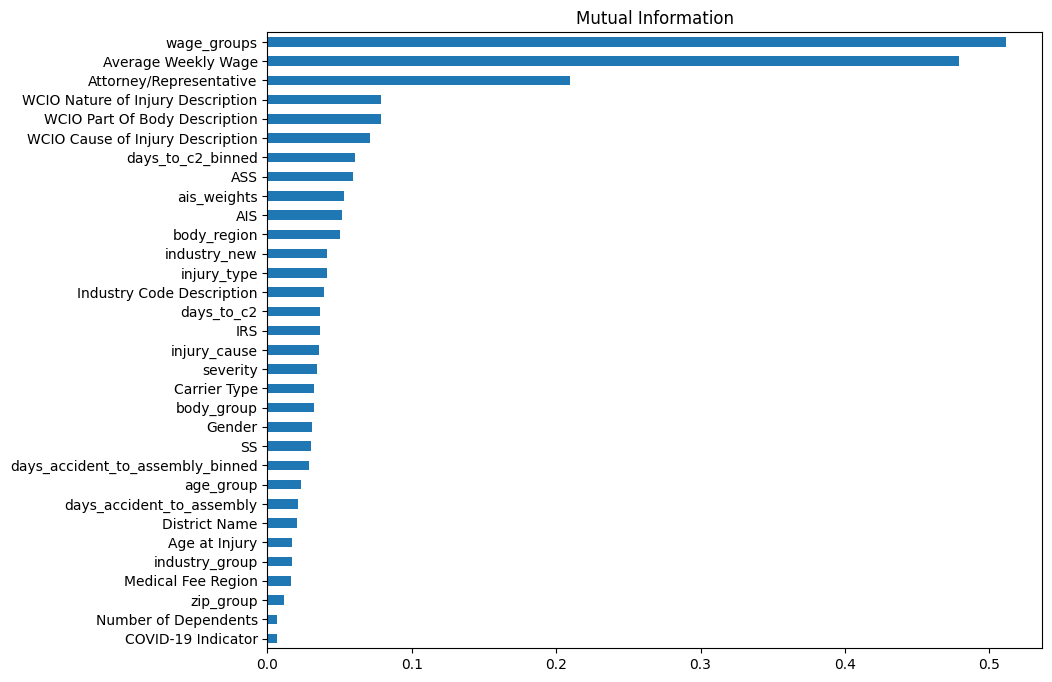

In [108]:
mi = mutual_info_classif(X_resampled, y_resampled)
mi = pd.Series(mi)
mi.index = X_resampled.columns
mi.sort_values(ascending=False)
mi.sort_values().plot(kind='barh', title = "Mutual Information", figsize=(10, 8))

In [185]:
def calculate_mutual_information(X, y):
    mi_scores = mutual_info_classif(X, y, discrete_features='auto', random_state=42)
    mi_scores_series = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)
    return mi_scores_series
# Calculate mutual information for the dataset
mi_scores = calculate_mutual_information(X_resampled, y_resampled)

# Display the mutual information scores
print("Mutual Information Scores:")
print(mi_scores)

# Features with low mutual information
low_mi_features = mi_scores[mi_scores < 0.025].index.tolist()
print("\nFeatures with Low Mutual Information:")
print(low_mi_features)

Mutual Information Scores:
Average Weekly Wage          0.479399
Attorney/Representative      0.210587
col_49                       0.121274
col_39                       0.082733
ASS                          0.060298
ais_weights                  0.052947
col_59                       0.047159
days_to_c2                   0.037569
IRS                          0.035853
col_21                       0.033015
Gender                       0.032316
col_26                       0.031172
SS                           0.030990
col_3                        0.023073
col_9                        0.023021
col_25                       0.022296
col_28                       0.022007
days_accident_to_assembly    0.020759
col_5                        0.020512
Age at Injury                0.016751
col_10                       0.015177
col_47                       0.015131
col_32                       0.014923
col_0                        0.014649
col_57                       0.014462
col_37                 

With a variance threshold of 0.01 and a correlation > 0.9 the method didn’t reduce the number of features, so the group changed the variance threshold to 0.1 and the correlation to 0.8

In [186]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import VarianceThreshold

### STEP 1: LOW VARIANCE FILTER
# Remove features with low variance
variance_threshold = 0.1
variance_filter = VarianceThreshold(threshold=variance_threshold)

X_train_low_variance = variance_filter.fit_transform(X_resampled)

X_val_low_variance = variance_filter.transform(X_val_scaled)

# Get the names of the remaining features
low_variance_selected_features = X_resampled.columns[variance_filter.get_support()]
print(f"Features after low variance filtering: {len(low_variance_selected_features)}")
print(f"{low_variance_selected_features}\n")

X_train_filtered = pd.DataFrame(X_train_low_variance, columns=low_variance_selected_features)
X_val_filtered = pd.DataFrame(X_val_low_variance, columns=low_variance_selected_features)

### STEP 2: CORRELATION-BASED FILTER
correlation_matrix = X_train_filtered.corr().abs()

upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# Find features with high correlation (correlation > 0.8)
correlation_threshold = 0.9
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > correlation_threshold)]

# Drop highly correlated features
X_train_final = X_train_filtered.drop(columns=to_drop)
X_val_final = X_val_filtered.drop(columns=to_drop)

# final list of selected features
final_selected_features = X_train_final.columns
print(f"Features after correlation filtering: {len(final_selected_features)}")
print(f"{final_selected_features}\n")

Features after low variance filtering: 58
Index(['col_0', 'col_3', 'col_4', 'col_5', 'col_6', 'col_7', 'col_8', 'col_9',
       'col_10', 'col_11', 'col_12', 'col_13', 'col_15', 'col_18', 'col_19',
       'col_20', 'col_21', 'col_22', 'col_24', 'col_25', 'col_26', 'col_27',
       'col_28', 'col_31', 'col_32', 'col_35', 'col_36', 'col_37', 'col_38',
       'col_39', 'col_41', 'col_42', 'col_43', 'col_44', 'col_45', 'col_46',
       'col_47', 'col_48', 'col_49', 'col_51', 'col_53', 'col_55', 'col_57',
       'col_58', 'col_59', 'col_60', 'col_61', 'col_62', 'col_63',
       'Age at Injury', 'Attorney/Representative', 'Average Weekly Wage',
       'Gender', 'Number of Dependents', 'days_to_c2',
       'days_accident_to_assembly', 'ais_weights', 'SS'],
      dtype='object')

Features after correlation filtering: 57
Index(['col_0', 'col_3', 'col_4', 'col_5', 'col_6', 'col_7', 'col_8', 'col_9',
       'col_10', 'col_11', 'col_12', 'col_13', 'col_15', 'col_18', 'col_19',
       'col_20', 'co

In [110]:
cor_spearman = X_resampled.corr(method ='spearman')
# check the name of the 2 variables that have a correlation higher than 0.5
for i in range(len(cor_spearman.columns)):
    for j in range(i):
        if abs(cor_spearman.iloc[i, j]) > 0.85:
            print(f"The columns: {cor_spearman.columns[i]} & {cor_spearman.columns[j]} have a correlation of: {cor_spearman.iloc[i, j]} \n")

The columns: wage_groups & Average Weekly Wage have a correlation of: -0.9578784148960674 

The columns: days_accident_to_assembly & days_to_c2 have a correlation of: 0.8771876704647396 

The columns: days_accident_to_assembly & days_to_c2_binned have a correlation of: -0.8635520940354581 

The columns: days_accident_to_assembly_binned & days_to_c2_binned have a correlation of: 0.9347200366183954 

The columns: days_accident_to_assembly_binned & days_accident_to_assembly have a correlation of: -0.901676220347799 

The columns: AIS & body_region have a correlation of: 1.0 

The columns: industry_new & Industry Code Description have a correlation of: 0.8508809493668309 



In [187]:
#making a correlation matrix between the variables and the target
cor_target = X_resampled.corrwith(y_resampled)
cor_target = cor_target.sort_values(ascending=False)
cor_target

Attorney/Representative      0.581123
col_39                       0.373323
Average Weekly Wage          0.303118
col_59                       0.301221
col_25                       0.146203
Age at Injury                0.106817
IRS                          0.106464
col_5                        0.085316
col_18                       0.084558
Gender                       0.075565
col_11                       0.065061
col_0                        0.064105
col_37                       0.051823
col_21                       0.044647
col_45                       0.044141
col_12                       0.042024
col_9                        0.041490
col_17                       0.040673
col_22                       0.035094
col_60                       0.034518
col_40                       0.034401
ASS                          0.033367
col_55                       0.030051
col_53                       0.029378
col_44                       0.029359
col_8                        0.028183
col_4       

com base no mutual information sai: 'days_to_c2', 'ais_weights', 'days_to_c2_binned', 'days_accident_to_assembly', 'injury_type', 'SS', 'injury_cause', 'body_group', 'Industry Code Description', 'Age at Injury', 'days_accident_to_assembly_binned', 'industry_risk_score', 'age_group', 'Carrier Type', 'Gender', 'District Name', 'Medical Fee Region', 'industry_group', 'COVID-19 Indicator', 'zip_group', 'Number of Dependents'

com base em variance e correlation sai: days_to_c2, Average Weekly Wage, WCIO Nature of Injury Description, Industry Code Description, days_accident_to_assembly

baseado no lasso sai: 'Average Weekly Wage', 'Carrier Type', 'COVID-19 Indicator', 'Industry Code Description', 'Number of Dependents', 'days_to_c2', 'days_to_c2_binned', 'body_group', 'injury_cause', 'industry_group', 'zip_group', 'days_accident_to_assembly', 'ASS', 'industry_risk_score'

## Embedded Methods

Embedded methods learn which features best contribute to the accuracy of the model while the model is being created, meaning that they integrate feature selection directly into the learning algorithm. The method the group chose was Lasso, a regression technique that works by reducing the coefficients of the least important features to zero. This means that it simultaneously indentifies those features and removes them from the model. The automatic feature selection that Lasso provides was the main reason to choose it over Ridge regression.

### LASSO Regression

In [188]:
def plot_importance(coef,name):
    imp_coef = coef.sort_values()
    plt.figure(figsize=(8,10))
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance using " + name + " Model")
    plt.show()

In [189]:
from sklearn.linear_model import LassoCV
import warnings
warnings.filterwarnings('ignore')

reg = LassoCV()

In [190]:
reg.fit(X_resampled, y_resampled)

LassoCV()

In [191]:
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)

Best alpha using built-in LassoCV: 0.584192


In [192]:
print("Best score using built-in LassoCV: %f" %reg.score(X_resampled, y_resampled))

Best score using built-in LassoCV: 0.099721


In [193]:
coef = pd.Series(reg.coef_, index = X_resampled.columns)

In [194]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 4 variables and eliminated the other 72 variables


In [195]:
coef.sort_values()

days_accident_to_assembly   -0.000075
col_0                        0.000000
col_2                       -0.000000
col_1                       -0.000000
col_4                        0.000000
col_5                        0.000000
col_6                       -0.000000
col_3                       -0.000000
col_8                        0.000000
col_9                        0.000000
col_10                      -0.000000
col_11                       0.000000
col_12                       0.000000
col_13                      -0.000000
col_14                       0.000000
col_7                       -0.000000
col_16                       0.000000
col_17                       0.000000
col_18                       0.000000
col_19                       0.000000
col_20                      -0.000000
col_21                       0.000000
col_22                       0.000000
col_23                       0.000000
col_24                       0.000000
col_25                       0.000000
col_26      

In [196]:
# features to drop
lasso_drop = coef[coef == 0].index
lasso_drop

Index(['col_0', 'col_1', 'col_2', 'col_3', 'col_4', 'col_5', 'col_6', 'col_7',
       'col_8', 'col_9', 'col_10', 'col_11', 'col_12', 'col_13', 'col_14',
       'col_15', 'col_16', 'col_17', 'col_18', 'col_19', 'col_20', 'col_21',
       'col_22', 'col_23', 'col_24', 'col_25', 'col_26', 'col_27', 'col_28',
       'col_29', 'col_30', 'col_31', 'col_32', 'col_33', 'col_34', 'col_35',
       'col_36', 'col_37', 'col_38', 'col_39', 'col_40', 'col_41', 'col_42',
       'col_43', 'col_44', 'col_45', 'col_46', 'col_47', 'col_48', 'col_49',
       'col_50', 'col_51', 'col_52', 'col_53', 'col_54', 'col_55', 'col_56',
       'col_57', 'col_58', 'col_59', 'col_60', 'col_61', 'col_62', 'col_63',
       'Attorney/Representative', 'COVID-19 Indicator', 'Gender',
       'Number of Dependents', 'ais_weights', 'SS', 'ASS', 'IRS'],
      dtype='object')

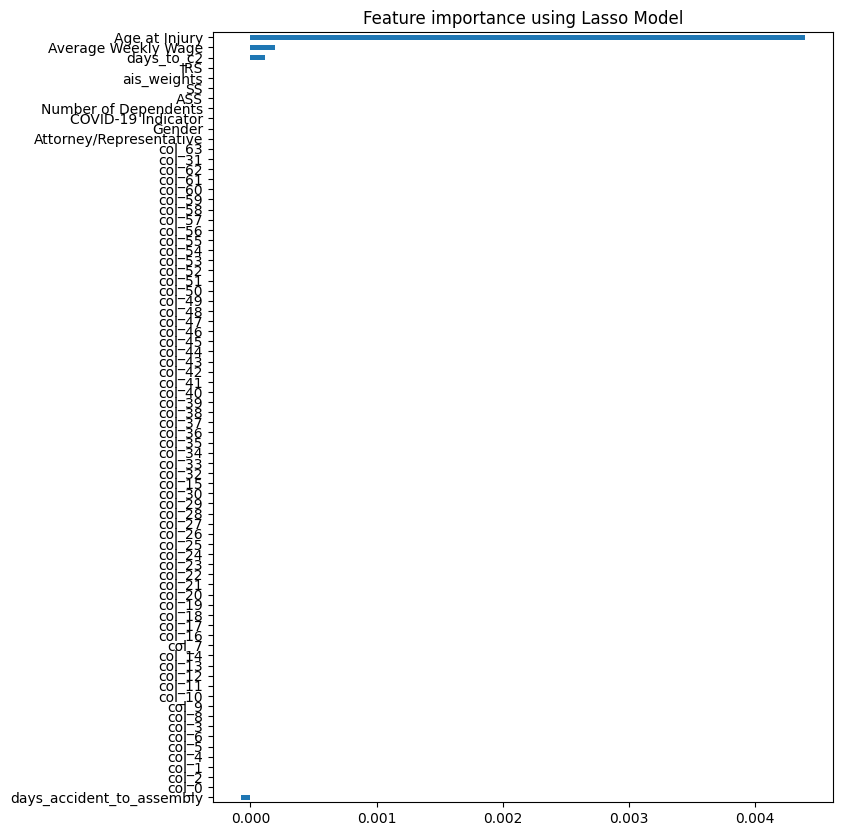

In [197]:
plot_importance(coef,'Lasso')

baseado no lasso sai: 'Average Weekly Wage', 'Carrier Type', 'COVID-19 Indicator', 'Industry Code Description', 'Number of Dependents', 'days_to_c2', 'days_to_c2_binned', 'body_group', 'injury_cause', 'industry_group', 'zip_group', 'days_accident_to_assembly', 'ASS', 'industry_risk_score'

### RIDGE Regression

In [133]:
# Ridge regularization
from sklearn.linear_model import RidgeCV
reg = RidgeCV()
reg.fit(X_resampled, y_resampled)
coef = pd.Series(reg.coef_, index = X_resampled.columns)

print("Ridge picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Ridge picked 32 variables and eliminated the other 0 variables


In [134]:
from sklearn.linear_model import RidgeCV
ridge = RidgeCV()

In [ ]:
ridge.fit(X_resampled, y_resampled)

In [ ]:
print("Best alpha using built-in RidgeCV: %f" % ridge.alpha_)

In [ ]:
print("Best score using built-in RidgeCV: %f" %ridge.score(X_resampled, y_resampled))

In [ ]:
# Ensure the ridge model is properly trained
if len(ridge.coef_) == len(X_resampled.columns):
	coef_ridge = pd.Series(ridge.coef_, index=X_resampled.columns)
	coef_ridge.sort_values()
else:
	print("Mismatch in the number of coefficients and features.")

In [ ]:
def plot_importance(coef, name):
	imp_coef = coef.sort_values()
	plt.figure(figsize=(8,10))
	imp_coef.plot(kind="barh")
	plt.title("Feature importance using " + name + " Model")
	plt.show()

plot_importance(coef_ridge, 'Ridge')

### Elastic Net

In [ ]:
from sklearn.linear_model import ElasticNetCV
import pandas as pd

elastic_net = ElasticNetCV(cv=5, l1_ratio=[0.1, 0.5, 0.7, 0.9, 1.0], random_state=13)

In [ ]:
elastic_net.fit(X_resampled, y_resampled)

In [ ]:
print("Best alpha using built-in ElasticNetCV: %f" % elastic_net.alpha_)

In [ ]:
print("Best l1_ratio using built-in ElasticNetCV: %f" % elastic_net.l1_ratio_)

In [ ]:
print("Best score using built-in ElasticNetCV: %f" % elastic_net.score(X_resampled, y_resampled))

In [ ]:
coef_elastic_net = pd.Series(elastic_net.coef_, index=X_resampled.columns)
coef_elastic_net = coef_elastic_net.sort_values()

print(coef_elastic_net)

In [ ]:
plot_importance(coef_elastic_net, 'Elastic Net')

# Modelation

## Model 1: Decision Tree Classifier

The first model that was tried was a decision tree. This model was picked based on its implementation simplicity. The group tried various iterations of the model based on the feature selection methods but the results weren't as good as expected so the group moved to a more complex model.

In [ ]:
# from sklearn.model_selection import train_test_split
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.metrics import classification_report, accuracy_score
# from sklearn.metrics import f1_score
# from sklearn.metrics import confusion_matrix

In [ ]:
# X_train_encoded_model = X_train_encoded[['wage_groups', 'days_accident_to_assembly', 'injury_type', 'industry_group', 'COVID-19 Indicator',
#                                          'Attorney/Representative', 'days_to_c2', 'Alternative Dispute Resolution', 'Age at Injury', 'Gender', 'District Name']]

# X_val_encoded_model = X_val_encoded[['wage_groups', 'days_accident_to_assembly', 'injury_type', 'industry_group', 'COVID-19 Indicator',
#                                      'Attorney/Representative', 'days_to_c2', 'Alternative Dispute Resolution', 'Age at Injury', 'Gender', 'District Name']]

# clf = DecisionTreeClassifier(random_state=13)
# clf.fit(X_train_encoded_model, y_train)

# # Predict and evaluate
# y_pred = clf.predict(X_val_encoded_model)
# accuracy = accuracy_score(y_pred, y_val)
# report = classification_report(y_val, y_pred)
# f1 = f1_score(y_val, y_pred, average='weighted')

# print(f"Accuracy: {accuracy:.2f}")
# print(f"F1 Score: {f1:.2f}")
# print("Classification Report:")
# print(report)

In [ ]:
# X_test_encoded_model = X_test_encoded[['wage_groups', 'days_accident_to_assembly', 'injury_type', 'industry_group', 'COVID-19 Indicator',
#                                      'Attorney/Representative', 'days_to_c2', 'Alternative Dispute Resolution', 'Age at Injury', 'Gender', 'District Name']]

In [ ]:
# y_pred = clf.predict(X_test_encoded_model)
# len(y_pred)

In [ ]:
# df_train['Claim Injury Type'].unique()

In [ ]:
# import pandas as pd

# y_pred_series = pd.Series(y_pred)
# y_pred_mapped = y_pred_series.map({1:'1. CANCELLED', 2:'2. NON-COMP', 3:'3. MED ONLY', 4:'4. TEMPORARY', 5:'5. PPD SCH LOSS', 6:'6. PPD NSL', 7:'7. PTD', 8:'8. DEATH'})
# print(y_pred_mapped)

In [ ]:
# y_pred_df = pd.DataFrame({'Claim Identifier': X_test['Claim Identifier'], 'Predicted Claim Injury Type': y_pred_mapped})

In [ ]:
# export_csv = y_pred_df.to_csv('y_pred.csv', index = None, header=True)

## Model 2: Random Forest

After testing the decision tree model, the group decided to try the next model: Random Forest. <br>
This model, to put it simply, combines an ensemble of decision trees to improve overall accuracy and reduce the risk of overfitting.<br>
Like the Decision Tree, this model underwent many iterations with different combinations of features and 'n_estimators' (the number of decision trees in the forest). Its performance was much better than the previous model, but after a certain number of iterations, the model plateaued, and the search for an optimal model began again.

In [87]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score
import pandas as pd

# X_train_encoded_model = X_train_scaled
# #previous feature selection
# #[['wage_groups', 'days_accident_to_assembly', 'injury_type', 'industry_group', 'COVID-19 Indicator',
#                                         # 'Attorney/Representative', 'days_to_c2', 'Alternative Dispute Resolution', 'Age at Injury', 'Gender', 'District Name']]

# X_val_encoded_model = X_val_scaled
# #previous feature selection
# #[['wage_groups', 'days_accident_to_assembly', 'injury_type', 'industry_group', 'COVID-19 Indicator',
#                                     # 'Attorney/Representative', 'days_to_c2', 'Alternative Dispute Resolution', 'Age at Injury', 'Gender', 'District Name']]


In [88]:
f6_list = ['Attorney/Representative', 'wage_groups', 'days_to_c2_binned', 'Carrier Type', 'ASS', 'IRS', 'SS', 'Average Weekly Wage', 'Age at Injury', 'ais_weights', 'WCIO Cause of Injury Description', 'WCIO Nature of Injury Description', 'WCIO Part Of Body Description']

In [93]:
X_val_encoded

,Age at Injury,Attorney/Representative,Average Weekly Wage,Carrier Type,COVID-19 Indicator,District Name,Gender,Industry Code Description,Medical Fee Region,WCIO Cause of Injury Description,...,days_accident_to_assembly,days_accident_to_assembly_binned,body_region,AIS,ais_weights,severity,SS,ASS,industry_new,IRS
Claim Identifier,,,,,,,,,,,,,,,,,,,,,
5713803,0.289157,1,0.002517,1.000000,0,1.000000,1,0.308903,1.000000,0.059985,...,0.000585,0.979567,9238,9238,1.000000,146416,0.166667,0.064696,28703,0.165159
5638483,0.325301,0,0.000000,1.000000,0,1.000000,1,0.437543,0.087276,0.192740,...,0.000266,1.000000,90629,90629,0.884194,146416,0.166667,0.043033,40540,0.772091
5845425,0.120482,0,0.000000,1.000000,1,0.156268,1,0.437543,0.221486,0.403394,...,0.000638,0.979567,24175,24175,0.751174,20879,0.833333,0.580211,40540,0.772091
5824359,0.108434,1,0.001454,1.000000,0,0.212875,1,0.168449,0.087276,0.102935,...,0.000266,1.000000,90629,90629,0.884194,25908,0.500000,0.373829,32327,0.145579
5860845,0.313253,0,0.004575,1.000000,0,1.000000,1,0.077976,1.000000,1.000000,...,0.001011,0.979567,90629,90629,0.884194,186635,0.333333,0.208431,27353,0.154087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5684330,0.024096,0,0.001658,1.000000,0,0.153502,0,1.000000,0.440867,0.120720,...,0.000160,1.000000,134448,134448,0.884194,186635,0.333333,0.208431,125604,0.172471
5548944,0.240964,0,0.000000,1.000000,0,0.307825,0,1.000000,0.221486,1.000000,...,0.074955,0.001122,54393,54393,0.832551,186635,0.333333,0.189110,125604,0.172471
6029859,0.132530,0,0.000000,0.181648,0,0.136224,0,1.000000,0.440867,0.426264,...,0.000000,1.000000,90629,90629,0.884194,146416,0.166667,0.043033,125604,0.172471


In [89]:
clf = RandomForestClassifier(random_state=13, n_estimators=100)
clf.fit(X_resampled[f6_list], y_resampled)

RandomForestClassifier(random_state=13)

In [92]:
y_pred = clf.predict(X_val_encoded[f6_list])
accuracy = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred)
f1 = f1_score(y_val, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")
print("Classification Report:")
print(report)

Accuracy: 0.75
F1 Score: 0.71
Classification Report:
              precision    recall  f1-score   support

           1       0.64      0.44      0.52      3119
           2       0.84      0.94      0.88     72769
           3       0.24      0.07      0.11     17227
           4       0.69      0.83      0.75     37127
           5       0.61      0.48      0.54     12070
           6       0.03      0.00      0.01      1053
           7       0.00      0.00      0.00        24
           8       0.21      0.03      0.05       117

    accuracy                           0.75    143506
   macro avg       0.41      0.35      0.36    143506
weighted avg       0.70      0.75      0.71    143506



In [ ]:
# X_test_encoded_model = X_test_scaled
# #previous feature selection
# #[['wage_groups', 'days_accident_to_assembly', 'injury_type', 'industry_group', 'COVID-19 Indicator',
#                                       # 'Attorney/Representative', 'days_to_c2', 'Alternative Dispute Resolution', 'Age at Injury', 'Gender', 'District Name']]

# y_pred = clf.predict(X_test_encoded_model)

In [ ]:
# y_pred_series = pd.Series(y_pred)
# y_pred_mapped = y_pred_series.map({
#     1: '1. CANCELLED', 2: '2. NON-COMP', 3: '3. MED ONLY', 4: '4. TEMPORARY', 
#     5: '5. PPD SCH LOSS', 6: '6. PPD NSL', 7: '7. PTD', 8: '8. DEATH'
# })

In [ ]:
# y_pred_df = pd.DataFrame({'Claim Identifier': X_test['Claim Identifier'], 'Predicted Claim Injury Type': y_pred_mapped})
# export_csv = y_pred_df.to_csv('y_pred.csv', index=False, header=True)

## Model 3: Light GBM

The final model the group ended up choosing to present in this phase of the project was the Light GBM (short for Light Gradient Boosting Machine). Like in the previous models, this model type suffered through many iterations and in the end the best combination was created using all features generated with the 64 lockers in the 'hashing trick'. In the future the group plans to retrace some steps a take a second look at important sections such as imputation, dealing with outliers and the aforementioned filter, embedded and wrapper methods.

Light GBM is a model that, much like a random forest, uses an ensemble of models, combining them sequentially. The objective is that each model corrects the previous models mistakes. The models are optimized based on the gradient of a loss function (in this case 'multi_logloss). The choice of this metric can be atributed to  to its suitability for multiclass classification. Several key parameters were fine-tuned (by trial and error) to optimize model performance:
- 'learning_rate' controls the speed of learning, with lower values enabling more gradual, precise learning.
- 'num_leaves' and 'max_depth' determine the complexity of each tree, allowing for more detailed splits.
- 'is_unbalanced' helps the model handle class imbalance by adjusting the weight of each class in the loss function, in this case the target is unbalanced and as no resampling was done this parameter is added to counter it.
- 'feature_fraction' and 'bagging_fraction' control feature and instance sampling, which helps reduce overfitting by ensuring diversity in each iteration.

References:

https://lightgbm.readthedocs.io/en/latest/Python-Intro.html# <br>
https://www.geeksforgeeks.org/lightgbm-light-gradient-boosting-machine/ <br>
https://medium.com/@pritmanvar/lightgbm-essentials-how-it-works-and-why-its-fast-586b83dda7af <br>
https://medium.com/@soyoungluna/simple-explanation-of-lightgbm-without-complicated-mathematics-973998ec848f <br>
https://lightgbm.readthedocs.io/en/latest/Features.html <br>

The target variable needed a slight adjustment, this is due to the constrains of the light gbm model. This model expects the classes to start at 0, so 1 is subtracet to each value in the train and validation set and afterwards the map function is changed.

In [166]:
y_train_adjusted = y_train - 1
y_val_adjusted = y_val - 1

### LightGBM with Cross Validation 

After testing the performance of LightGBM model, the group decided to test LightGBM with cross-validation to gain a more reliable performance estimate.<br>
Kfold cross validation splits the data into k subsets (folds) and then train and test the model on each fold, each time using one fold as the test set and the remaning k-1 folds as the training set. This approach ensures that all data is used for both training and testing, providing a more accurate estimate of the model's performance on unseen data.

The highest score on Kaggle (0.37385) was obtained by using Light GBM model with Cross-Validation. However, this model was left commented as running it was very time-intensive, taking approximately 50 minutes to run, compared to only 10 minutes for the version without cross-validation. To avoid long waiting times, we used the model without cross validation while working on the project.


References: <br>
https://pub.aimind.so/kfold-cross-validation-for-the-lightgbm-classifier-7915aed9b19e

In [ ]:
# features_to_reject = ['days_to_c2', 'days_accident_to_assembly', 'Average Weekly Wage', 'Industry Code Description', 
#                       'Carrier Type', 'Number of Dependents', 'body_group', 'injury_cause', 'industry_group', 'zip_group', 
#                       'days_to_c2_binned', 'days_accident_to_assembly_binned']

# #X_train_copy = X_resampled.copy()
# #X_val_copy = X_val_scaled.copy()
# #X_test_copy = X_test_scaled.copy()
# X_train.drop(columns=features_to_reject, inplace=True)
# X_val.drop(columns=features_to_reject, inplace=True)
# # X_test.drop(columns=features_to_reject, inplace=True)

In [11]:
# f1_list = ['ASS', 'IRS', 'Attorney/Representative', 'wage_groups', 'days_to_c2_binned']

#f2_list = ['Attorney/Representative', 'wage_groups', 'days_to_c2_binned', 'Carrier Type', 'body_region', 'severity']

#f3_list = ['ASS', 'IRS', 'SS', 'Average Weekly Wage', 'Age at Injury', 'ais_weights']

#f4_list = ['Attorney/Representative', 'wage_groups', 'days_to_c2_binned', 'Carrier Type', 'ASS', 'IRS', 'SS', 'Average Weekly Wage', 'Age at Injury', 'ais_weights']

#f5_list = ['Attorney/Representative', 'wage_groups', 'days_to_c2_binned', 'Carrier Type', 'ASS', 'Average Weekly Wage', 'Age at Injury', 'IRS']

f_list = ['Attorney/Representative', 'wage_groups', 'days_to_c2_binned', 'Carrier Type', 'ASS', 'IRS', 'SS', 'Average Weekly Wage', 'Age at Injury', 'ais_weights', 'WCIO Cause of Injury Description', 'WCIO Nature of Injury Description', 'WCIO Part Of Body Description']

#f7_list = ['Attorney/Representative', 'wage_groups', 'days_to_c2_binned', 'Carrier Type', 'ASS', 'Average Weekly Wage', 'Age at Injury', 'WCIO Cause of Injury Description', 'WCIO Nature of Injury Description', 'WCIO Part Of Body Description']

#f8_list = ["wage_groups", "Attorney/Representative", "Average Weekly Wage", "days_to_c2_binned", "WCIO Nature of Injury Description", "body_region"]

#f9_list = ["wage_groups", "Attorney/Representative", "days_to_c2_binned", "WCIO Nature of Injury Description", "body_region"]

#f10_list = ['Attorney/Representative', 'wage_groups', 'days_to_c2_binned', 'Carrier Type', 'Average Weekly Wage', 'Age at Injury', 'WCIO Cause of Injury Description', 'WCIO Nature of Injury Description', 'WCIO Part Of Body Description']

#f11_list = ["Average Weekly Wage", "days_to_c2", "Age at Injury", "days_accident_to_assembly"]




Accuracy: 0.7539545384861956
F1-Score (Weighted): 0.686246800334058
Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.26      0.36      3119
           1       0.81      0.99      0.89     72769
           2       0.45      0.01      0.01     17227
           3       0.67      0.88      0.76     37127
           4       0.67      0.24      0.35     12070
           5       0.00      0.00      0.00      1053
           6       0.00      0.00      0.00        24
           7       0.00      0.00      0.00       117

    accuracy                           0.75    143506
   macro avg       0.40      0.30      0.30    143506
weighted avg       0.71      0.75      0.69    143506



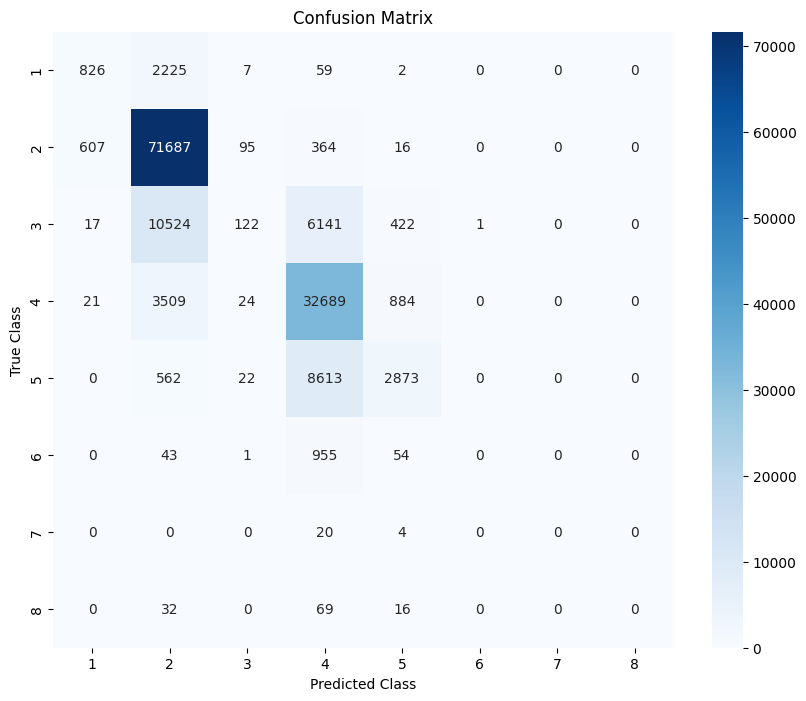

In [199]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

y_train_adjusted = y_resampled - 1
y_val_adjusted = y_val - 1

train_data = lgb.Dataset(X_resampled[f_list], label=y_train_adjusted)
val_data = lgb.Dataset(X_val_encoded[f_list], label=y_val_adjusted, reference=train_data)

params = {
    'objective': 'multiclass',
    'metric': 'multi_logloss',
    'num_class': 8,
    'learning_rate': 0.01,
    'num_leaves': 64,
    'max_depth': 6,
    'min_data_in_leaf': 50,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'lambda_l2': 2.0,
    'verbose': -1,
    'is_unbalance': True
}

model = lgb.train(params, train_data, num_boost_round=1000, valid_sets=[val_data])

y_pred_proba = model.predict(X_val_encoded[f_list])
y_pred = np.argmax(y_pred_proba, axis=1)

accuracy = accuracy_score(y_val_adjusted, y_pred)
print("Accuracy:", accuracy)

f1 = f1_score(y_val_adjusted, y_pred, average='weighted')
print("F1-Score (Weighted):", f1)
print("Classification Report:\n", classification_report(y_val_adjusted, y_pred))

cm = confusion_matrix(y_val_adjusted, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(1, 9), yticklabels=range(1, 9))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

In [169]:
y_pred_proba = model.predict(X_test_scaled[f_list])
y_pred = np.argmax(y_pred_proba, axis=1)

# Mapping dictionary to convert the integer predictions to the full labels
label_mapping = {
    0: '1. CANCELED',
    1: '2. NON-COMP',
    2: '3. MED ONLY',
    3: '4. TEMPORARY',
    4: '5. PPD SCH LOSS',
    5: '6. PPD NSL',
    6: '7. PTD',
    7: '8. DEATH'
}
test_predictions_full_labels = [label_mapping[pred] for pred in y_pred]

submission_df = pd.DataFrame({
    'Claim Identifier': X_test.index,
    'Claim Injury Type': test_predictions_full_labels
})

# Export the submission DataFrame to a CSV file
submission_df.to_csv("Group13_Version55.csv", index=False, header=True)

In [82]:
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

params = {
    'objective': 'multiclass',
    'metric': 'multi_logloss',
    'num_class': 8, 
    'learning_rate': 0.01, 
    'num_leaves': 64,  
    'max_depth': 6,  
    'min_data_in_leaf': 50,  
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'lambda_l2': 2.0,  
    'verbose': -1,
    'is_unbalanced': True
}

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
accuracies = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_resampled[f_list], y_train_adjusted)):
    print(f"Training fold {fold + 1}...")
    
    X_train_fold, X_val_fold = X_resampled[f_list].iloc[train_idx], X_resampled[f_list].iloc[val_idx]
    y_train_fold, y_val_fold = y_train_adjusted.iloc[train_idx], y_train_adjusted.iloc[val_idx]

    train_data = lgb.Dataset(X_train_fold, label=y_train_fold)
    val_data = lgb.Dataset(X_val_fold, label=y_val_fold, reference=train_data)

    model = lgb.train(
        params,
        train_data,
        num_boost_round=1000,
        valid_sets=[val_data]
    )

    y_pred_proba = model.predict(X_val_fold) 
    y_pred = np.argmax(y_pred_proba, axis=1)  

    accuracy = accuracy_score(y_val_fold, y_pred)
    accuracies.append(accuracy)

    print(f"Fold {fold + 1} Accuracy: {accuracy:.4f}")

print(f"\nMean Accuracy across folds: {np.mean(accuracies):.4f}")

Training fold 1...
Fold 1 Accuracy: 0.7733
Training fold 2...
Fold 2 Accuracy: 0.7740
Training fold 3...
Fold 3 Accuracy: 0.7721
Training fold 4...
Fold 4 Accuracy: 0.7707
Training fold 5...
Fold 5 Accuracy: 0.7721
Training fold 6...
Fold 6 Accuracy: 0.7719
Training fold 7...
Fold 7 Accuracy: 0.7726
Training fold 8...
Fold 8 Accuracy: 0.7719
Training fold 9...
Fold 9 Accuracy: 0.7711
Training fold 10...
Fold 10 Accuracy: 0.7727

Mean Accuracy across folds: 0.7722


In [ ]:
y_pred_proba = model.predict(X_test_scaled[feature_list])
y_pred = np.argmax(y_pred_proba, axis=1)

# Mapping dictionary to convert the integer predictions to the full labels
label_mapping = {
    0: '1. CANCELED',
    1: '2. NON-COMP',
    2: '3. MED ONLY',
    3: '4. TEMPORARY',
    4: '5. PPD SCH LOSS',
    5: '6. PPD NSL',
    6: '7. PTD',
    7: '8. DEATH'
}
test_predictions_full_labels = [label_mapping[pred] for pred in y_pred]

submission_df = pd.DataFrame({
    'Claim Identifier': X_test.index,
    'Claim Injury Type': test_predictions_full_labels
})

# Export the submission DataFrame to a CSV file
submission_df.to_csv("submission_5_12.csv", index=False, header=True)

In [ ]:
# y_pred_series = pd.Series(y_pred)
# y_pred_mapped = y_pred_series.map({
#     0: '1. CANCELLED', 1: '2. NON-COMP', 2: '3. MED ONLY', 3: '4. TEMPORARY', 
#     4: '5. PPD SCH LOSS', 5: '6. PPD NSL', 6: '7. PTD', 7: '8. DEATH'
# })

In [ ]:
# y_pred_df = pd.DataFrame({'Claim Identifier': X_test['Claim Identifier'], 'Predicted Claim Injury Type': y_pred_mapped})
# export_csv = y_pred_df.to_csv('y_pred.csv', index=False, header=True)

### Random Search

In [ ]:
import pickle
import os
import time
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
import lightgbm as lgb

# Adjust labels for training
y_train_adjusted = y_resampled - 1

# Define the LightGBM model
lgb_model = lgb.LGBMClassifier(objective='multiclass', num_class=8, is_unbalance=True, verbose=-1)

# Define the parameter grid for random search
param_dist = {
    'learning_rate': uniform(0.005, 0.295),  # Learning rate between 0.005 and 0.3
    'num_leaves': randint(20, 150),  # Number of leaves
    'max_depth': randint(3, 15),  # Maximum depth
    'min_data_in_leaf': randint(50, 500),  # Minimum data in leaf
    'feature_fraction': uniform(0.7, 0.3),  # Fraction of features used
    'bagging_fraction': uniform(0.7, 0.3),  # Bagging fraction
    'bagging_freq': randint(1, 5),  # Bagging frequency
    'lambda_l2': uniform(0, 10),  # L2 regularization
    'n_estimators': randint(100, 1000)  # Number of estimators
}

# Checkpoint file name
checkpoint_file = 'random_search_checkpoint.pkl'

# Check if a checkpoint exists
if os.path.exists(checkpoint_file):
    with open(checkpoint_file, 'rb') as f:
        random_search = pickle.load(f)
    print("Checkpoint loaded. Resuming from saved progress.")
else:
    # Create a new RandomizedSearchCV object
    random_search = RandomizedSearchCV(
        estimator=lgb_model,
        param_distributions=param_dist,
        n_iter=200,  # Total number of iterations
        scoring='f1_weighted',
        cv=3,  # Number of cross-validation folds
        verbose=2,
        n_jobs=-1,
        random_state=42
    )

# Start timer
start_time = time.time()
time_limit = 5 * 3600  # 5 hours in seconds
save_interval = 30 * 60  # 30 minutes in seconds
last_save_time = start_time

# Track completed iterations
completed_iterations = 0

try:
    for i, _ in enumerate(random_search.fit(X_resampled[f_list], y_train_adjusted), 1):
        completed_iterations += 1
        current_time = time.time()
        elapsed_time = current_time - start_time

        # Print progress every 10 iterations
        if completed_iterations % 10 == 0:
            print(f"Iteration {completed_iterations}: Elapsed time {elapsed_time / 3600:.2f} hours.")
        
        # Save progress periodically
        if current_time - last_save_time > save_interval:
            print(f"Checkpointing progress after {elapsed_time / 3600:.2f} hours...")
            with open(checkpoint_file, 'wb') as f:
                pickle.dump(random_search, f)
            last_save_time = current_time

        # Stop if time limit is reached
        if elapsed_time > time_limit:
            print("Time limit reached. Stopping search.")
            break

except KeyboardInterrupt:
    print("Search interrupted manually. Saving progress...")
    with open(checkpoint_file, 'wb') as f:
        pickle.dump(random_search, f)
    print("Progress saved.")
    raise  # Re-raise exception to stop execution

# Save final progress
print("Random search completed or stopped. Saving final progress...")
with open(checkpoint_file, 'wb') as f:
    pickle.dump(random_search, f)

# Display best results
if hasattr(random_search, 'cv_results_'):
    print("Best Parameters:", random_search.best_params_)
    print("Best F1-Score:", random_search.best_score_)
else:
    print("No results to display. Checkpoint might be incomplete.")

Fitting 3 folds for each of 200 candidates, totalling 600 fits


KeyboardInterrupt: 

## Model 4: Neural Networks

### ADAM

In [115]:
import warnings
warnings.filterwarnings('ignore')
import time
from sklearn.neural_network import MLPClassifier
import pandas as pd

In [ ]:
for col in X_train_scaled.columns:
    print(col)

In [113]:
f6_list = ['Attorney/Representative', 'wage_groups', 'days_to_c2_binned', 'Carrier Type', 'ASS', 'IRS', 'SS', 'Average Weekly Wage', 'Age at Injury', 'ais_weights',
            'WCIO Cause of Injury Description', 'WCIO Nature of Injury Description', 'WCIO Part Of Body Description']

In [116]:
X_train_adam = X_resampled[f6_list]
X_val_adam = X_val_scaled[f6_list]
X_test_adam = X_test_scaled[f6_list]

model_adam = MLPClassifier(solver= 'adam', random_state=13)
model_adam.fit(X_train_adam, y_resampled)

MLPClassifier(random_state=13)

In [118]:
model_adam.score(X_train_adam, y_resampled)

0.7660539164448409

In [119]:
y_pred = model_adam.predict(X_val_adam)

In [122]:
#check accurazy of the model
accuracy = accuracy_score(y_val, y_pred)
accuracy

#check the f1 score of the model
f1_val = f1_score(y_val, y_pred, average='weighted')
f1_train = f1_score(y_train, model_adam.predict(X_train_adam), average='weighted')
print(f"F1 Score (Train): {f1_train:f}")
print(f"F1 Score (Validation): {f1_val:f}")

#classification report
f1 = f1_score(y_val_adjusted, y_pred, average='weighted')
print("F1-Score (Weighted):", f1)
print("Classification Report:\n", classification_report(y_val_adjusted, y_pred))

F1 Score (Train): 0.706141
F1 Score (Validation): 0.705738
F1-Score (Weighted): 0.052754812594895686
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      3119
           1       0.34      0.01      0.02     72769
           2       0.12      0.59      0.20     17227
           3       0.25      0.00      0.00     37127
           4       0.14      0.56      0.23     12070
           5       0.01      0.08      0.02      1053
           6       0.00      0.00      0.00        24
           7       0.00      0.00      0.00       117
           8       0.00      0.00      0.00         0

    accuracy                           0.12    143506
   macro avg       0.10      0.14      0.05    143506
weighted avg       0.26      0.12      0.05    143506



In [ ]:
y_pred = model_adam.predict(X_test_adam)

In [ ]:
# Mapping dictionary to convert the integer predictions to the full labels
label_mapping = {
    1: '1. CANCELED',
    2: '2. NON-COMP',
    3: '3. MED ONLY',
    4: '4. TEMPORARY',
    5: '5. PPD SCH LOSS',
    6: '6. PPD NSL',
    7: '7. PTD',
    8: '8. DEATH'
}
test_predictions_full_labels = [label_mapping[pred] for pred in y_pred]

submission_df = pd.DataFrame({
    'Claim Identifier': X_test_scaled.index,
    'Claim Injury Type': test_predictions_full_labels
})

# Export the submission DataFrame to a CSV file
submission_df.to_csv("submission_rf.csv", index=False, header=True)

### SGD

In [ ]:
feature_list = ['Attorney/Representative', 'Carrier Type', 'COVID-19 Indicator', 'District Name', 'Gender', 
                'Industry Code Description', 'Medical Fee Region', 'WCIO Cause of Injury Description',
                'WCIO Nature of Injury Description', 'WCIO Part Of Body Description', 'age_group', 'wage_groups', 'body_group',
                'injury_type', 'injury_cause', 'industry_group', 'days_accident_to_assembly', 'zip_group', 'days_to_c2_binned']

In [ ]:
from sklearn.neural_network import MLPClassifier

model_constant = MLPClassifier(solver='sgd', learning_rate='adaptive', random_state=42)
model_constant.fit(X_train_scaled[feature_list], y_train)

In [ ]:
y_pred = model_constant.predict(X_val_scaled[feature_list])

In [ ]:
#check the f1 score of the model
f1_val = f1_score(y_val, y_pred, average='weighted')
f1_train = f1_score(y_train, model_constant.predict(X_train_scaled[feature_list]), average='weighted')
print(f"F1 Score (Train): {f1_train:f}")
print(f"F1 Score (Validation): {f1_val:f}")

In [ ]:
y_pred = model_constant.predict(X_test_scaled[feature_list])

In [ ]:
# Mapping dictionary to convert the integer predictions to the full labels
label_mapping = {
    1: '1. CANCELED',
    2: '2. NON-COMP',
    3: '3. MED ONLY',
    4: '4. TEMPORARY',
    5: '5. PPD SCH LOSS',
    6: '6. PPD NSL',
    7: '7. PTD',
    8: '8. DEATH'
}
test_predictions_full_labels = [label_mapping[pred] for pred in y_pred]

submission_df = pd.DataFrame({
    'Claim Identifier': X_test_scaled.index,
    'Claim Injury Type': test_predictions_full_labels
})

# Export the submission DataFrame to a CSV file
submission_df.to_csv("submission_rf.csv", index=False, header=True)